In [5]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

#필요한 임포트

In [6]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#틀린 데이터를 출력하기 위해 선언한 레이블 배열

In [7]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"PyTorch 버전: {torch.__version__}, Device: {DEVICE}")

#학습에 필요한 DEVICE 선언, CodeSpace는 별도의 GPU가 없어 CPU를 사용 (테스트를 위해 잠깐 local에서 돌리기 위해 위와 같은 코드를 작성하였다.

PyTorch 버전: 2.2.2+cu121, Device: cpu


In [8]:
train_dataset = datasets.FashionMNIST(root='202220960_FMNIST/', train=True, download=True, transform=transforms.ToTensor()) 
#학습 데이터

test_dataset = datasets.FashionMNIST(root='202220960_FMNIST/', train=False, download=True, transform=transforms.ToTensor())
#테스트할 데이터

In [9]:
#기존 학습 데이터셋중 85퍼센트를 학습 데이터, 15퍼센트를 validation 데이터 세트로 둬서 과적합을 방지
train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)])

In [10]:
BATCH_SIZE = 64 #배치 사이즈 지정

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
class MyCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        #첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_channels=1, #흑백 사진이니까 in_channels는 1
                               out_channels=32,
                               kernel_size=3, padding=1)

        #두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3, padding=1)

        #풀링 레이어
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):
        data = self.conv1(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 7 * 7 * 64)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

In [12]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

#SGD, Adam, RMSProp, Adagrad 등 다양한 최적화 알고리즘 중 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [13]:
def model_train(dataloader, model, loss_function, optimizer): #모델 훈련 함수
    model.train() #모델 훈련 모드 지정
    
    #loss, accuracy, total 변수 선언
    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        #Forward Propagation 진행
        outputs = model(x_train)

        #loss 산출
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()

        #오차 역전파 진행
        loss.backward()

        #계산된 Gradient를 업데이트
        optimizer.step()

        train_loss_sum += loss.item()
        
        train_total += y_train.size(0)
        #모델 정확도 업데이트
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    #평균 loss, accuracy 산출
    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [14]:
def model_evaluate(dataloader, model, loss_function):
    model.eval() #평가 모드 전환

    with torch.no_grad(): #평가 모드에서는 Gridient 업데이트 방지
        #loss, accuracy, total 변수 선언
        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            #Forward Propagation 진행
            outputs = model(x_val)

            #loss 산출
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            #모델 정확도 업데이트
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        #평균 loss, accuracy 산출
        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [15]:
def model_test(dataloader, model, loss_function): #최종 평가, evaluate와 유사하다.
    model.eval() #평가 모드 전환

    with torch.no_grad(): #평가 모드에서는 Gridient 업데이트 방지
        #loss, accuracy, total 변수 선언
        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        #틀린 데이터 출력하기 위해 저장해둘 리스트
        wrong_predictions = []

        
        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

            #잘못된 결과인지 체크하기
            incorrect_mask = torch.argmax(outputs, 1) != y_test
            for i in range(len(incorrect_mask)):
                if incorrect_mask[i]: #잘못된 결과면 추가해준다.
                    wrong_predictions.append((x_test[i], torch.argmax(outputs[i]).item(), y_test[i].item()))

        
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('Test Accuracy:', test_avg_accuracy)
        print('Test Loss:', test_avg_loss)

        print("\nWrong Predictions:") 
        for img, pred, actual in wrong_predictions:
            print("Predicted:", class_labels[pred], "Actual:", class_labels[actual]) #예측 정보와 실제 정보 출력
            img = img.cpu().numpy().transpose(1, 2, 0)
            plt.imshow(img)
            plt.show()

In [16]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20 #20번 진행, 일정 회수가 지나면 더 이상 향상되지 않는다.

print('학습 시작')

for epoch in range(EPOCHS):
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    print('Epoch:', '%02d' % (epoch + 1))
    print('train loss =', '{:.3f}'.format(train_avg_loss), 'train accuracy =', '{:.3f}'.format(train_avg_accuracy))
    print('validation loss =', '{:.3f}'.format(val_avg_loss), 'validation accuracy =', '{:.3f}'.format(val_avg_accuracy))
    print('-' * 100)

end_time = datetime.now()
print('경과 시간 => ', end_time-start_time)

학습 시작


Epoch: 01
train loss = 0.587 train accuracy = 78.427
validation loss = 0.382 validation accuracy = 85.667
----------------------------------------------------------------------------------------------------
Epoch: 02
train loss = 0.391 train accuracy = 85.863
validation loss = 0.293 validation accuracy = 89.456
----------------------------------------------------------------------------------------------------
Epoch: 03
train loss = 0.333 train accuracy = 87.847
validation loss = 0.262 validation accuracy = 90.278
----------------------------------------------------------------------------------------------------
Epoch: 04
train loss = 0.302 train accuracy = 89.035
validation loss = 0.237 validation accuracy = 91.367
----------------------------------------------------------------------------------------------------
Epoch: 05
train loss = 0.284 train accuracy = 89.669
validation loss = 0.233 validation accuracy = 91.544
------------------------------------------------------------------

Test Accuracy: 92.71
Test Loss: 0.23537081050550102

Wrong Predictions:
Predicted: Pullover Actual: Shirt


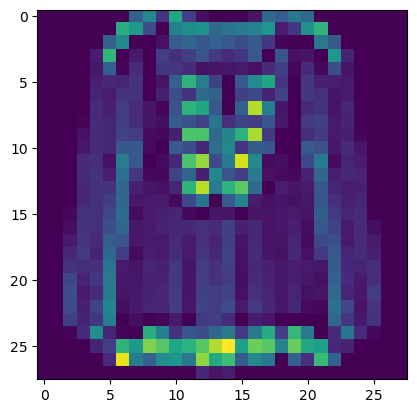

Predicted: Coat Actual: Shirt


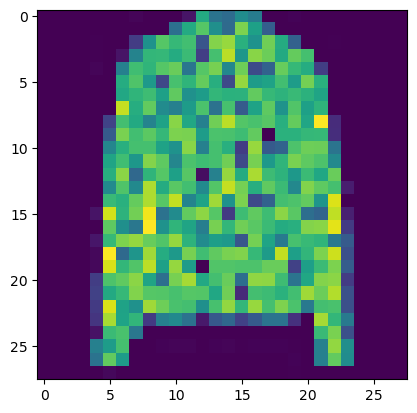

Predicted: Coat Actual: Shirt


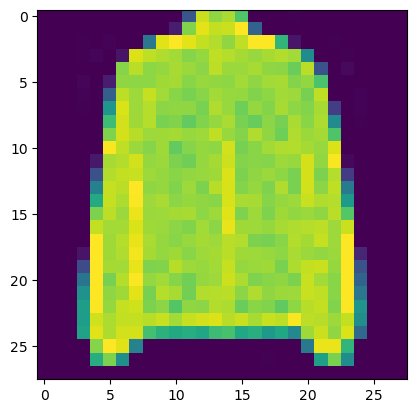

Predicted: Shirt Actual: T-shirt/top


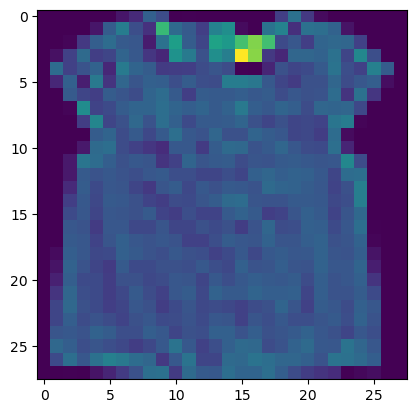

Predicted: Pullover Actual: T-shirt/top


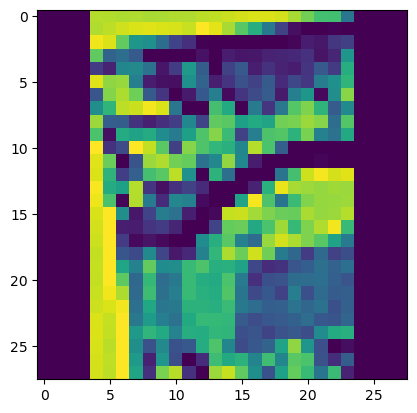

Predicted: Coat Actual: Shirt


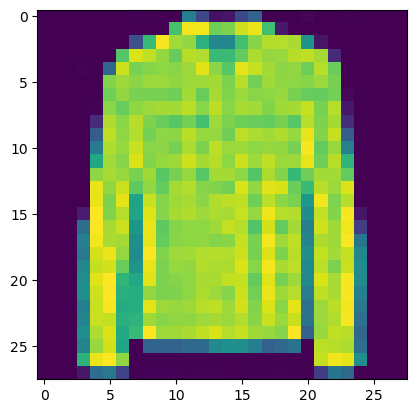

Predicted: Coat Actual: Dress


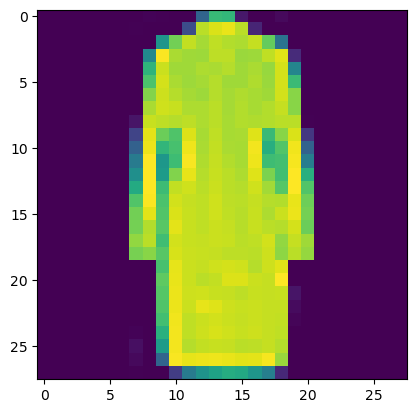

Predicted: Shirt Actual: Dress


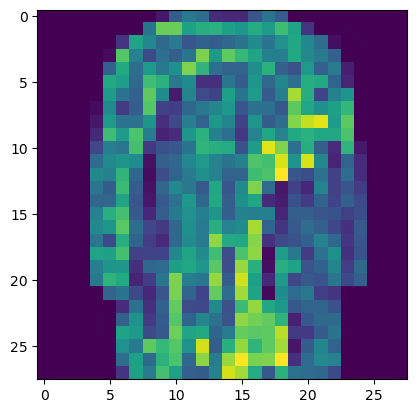

Predicted: Coat Actual: Dress


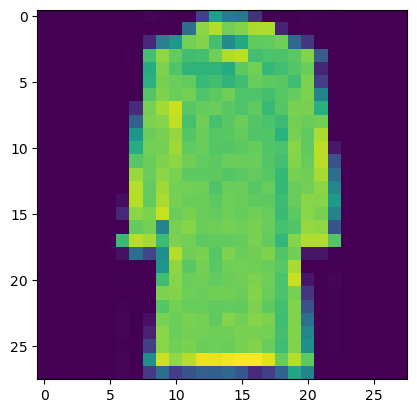

Predicted: Coat Actual: Shirt


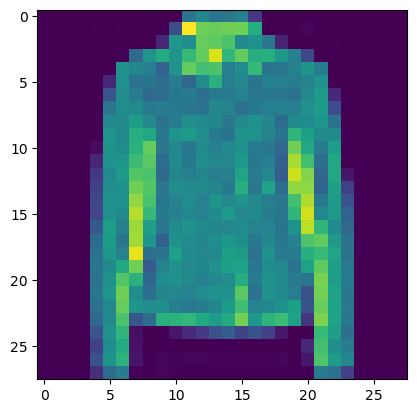

Predicted: Sneaker Actual: Ankle boot


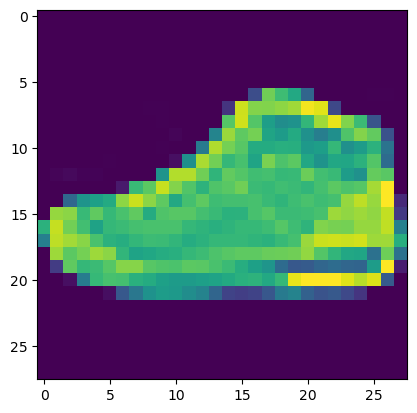

Predicted: Shirt Actual: T-shirt/top


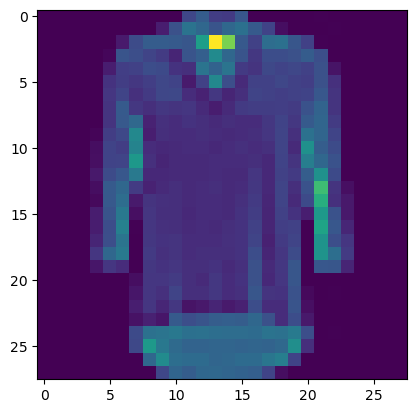

Predicted: Pullover Actual: Coat


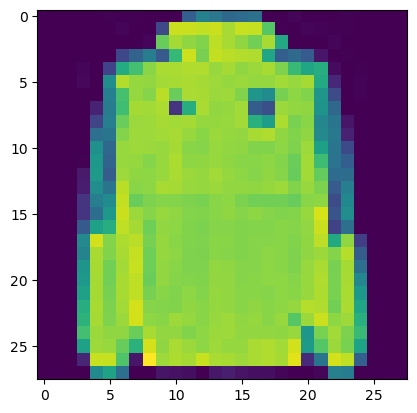

Predicted: Shirt Actual: Dress


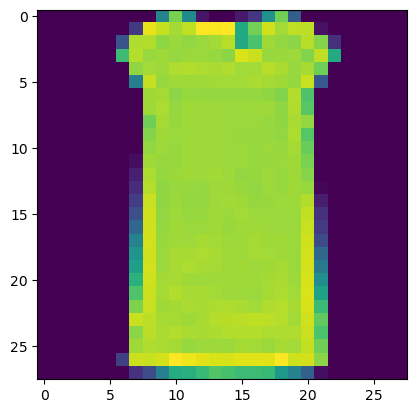

Predicted: T-shirt/top Actual: Shirt


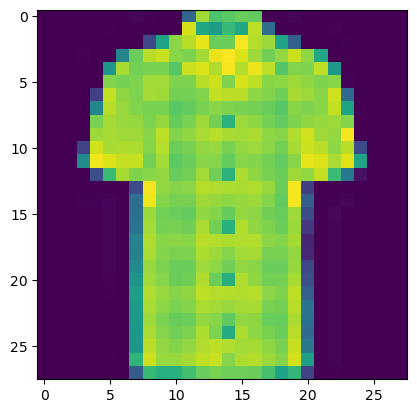

Predicted: Coat Actual: Shirt


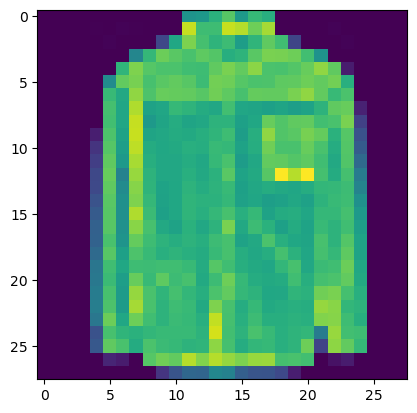

Predicted: Sneaker Actual: Sandal


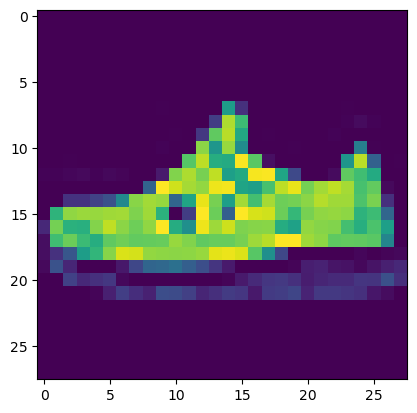

Predicted: Shirt Actual: T-shirt/top


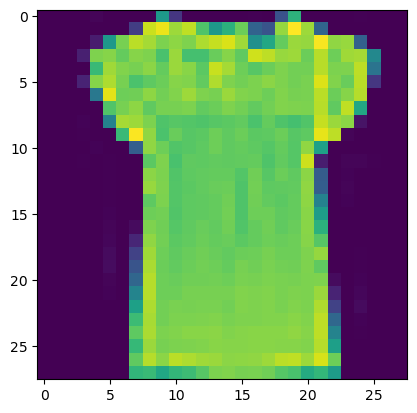

Predicted: T-shirt/top Actual: Dress


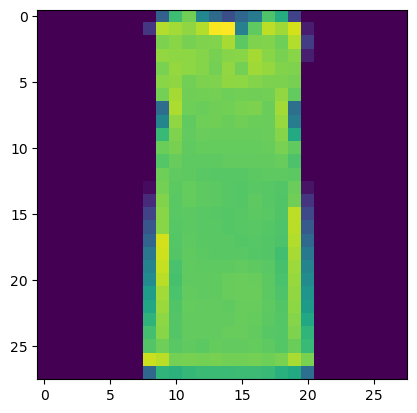

Predicted: Coat Actual: Shirt


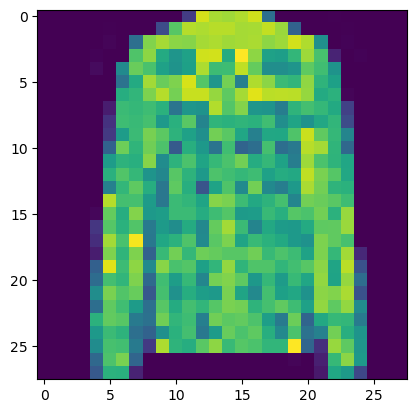

Predicted: Shirt Actual: Coat


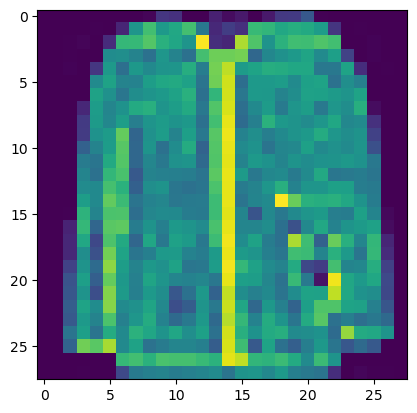

Predicted: Coat Actual: Shirt


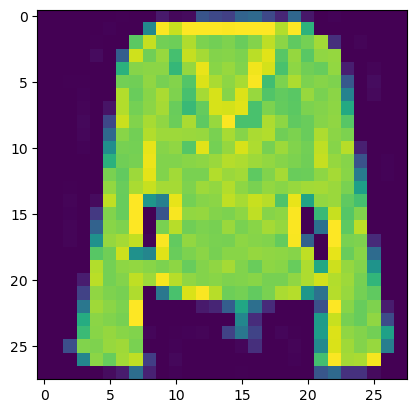

Predicted: Pullover Actual: Shirt


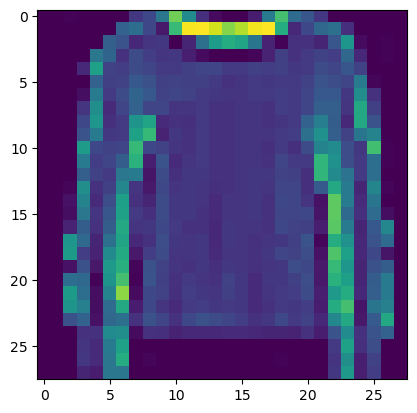

Predicted: Pullover Actual: Coat


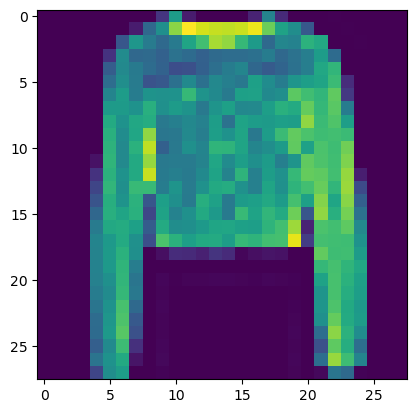

Predicted: Coat Actual: Shirt


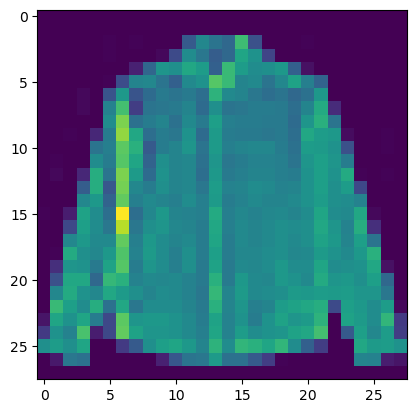

Predicted: T-shirt/top Actual: Dress


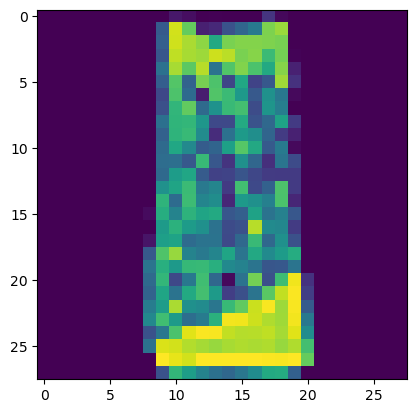

Predicted: Coat Actual: Shirt


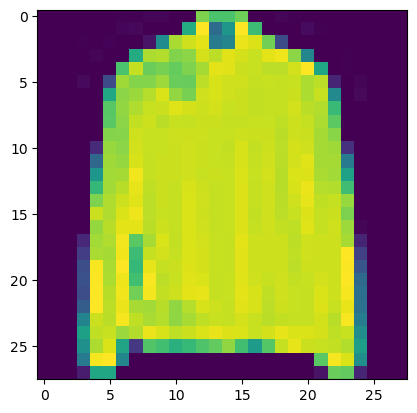

Predicted: Coat Actual: Shirt


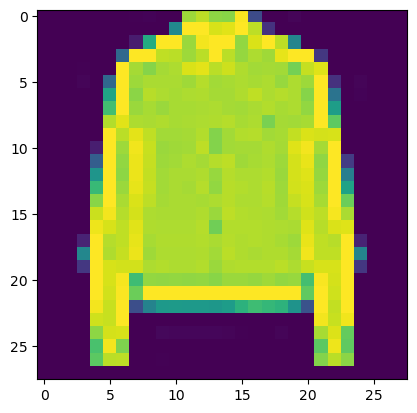

Predicted: Dress Actual: Shirt


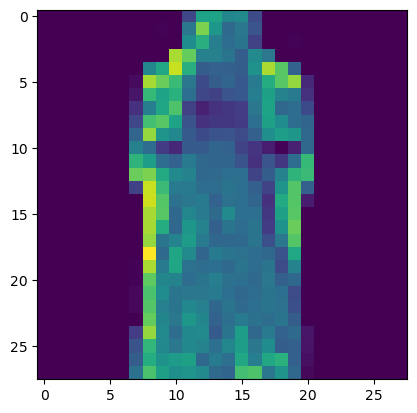

Predicted: Pullover Actual: Coat


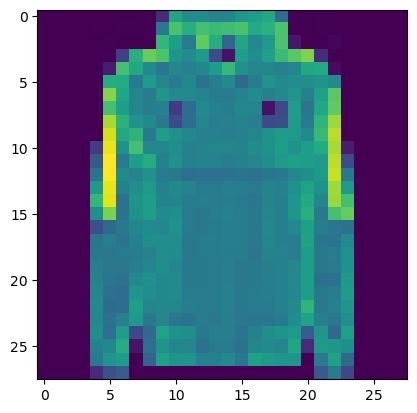

Predicted: Pullover Actual: Shirt


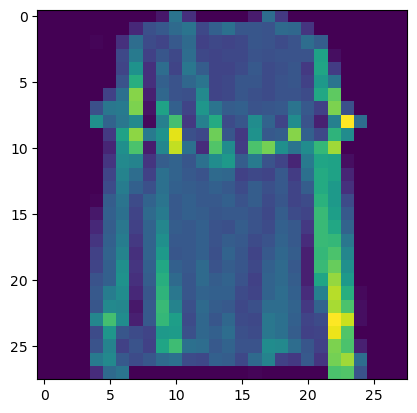

Predicted: Bag Actual: Shirt


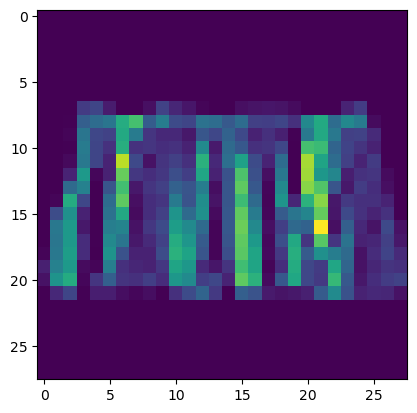

Predicted: Sneaker Actual: Ankle boot


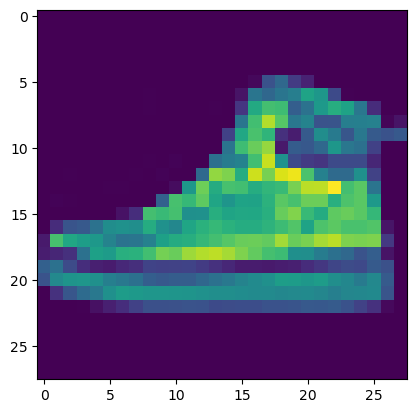

Predicted: Bag Actual: T-shirt/top


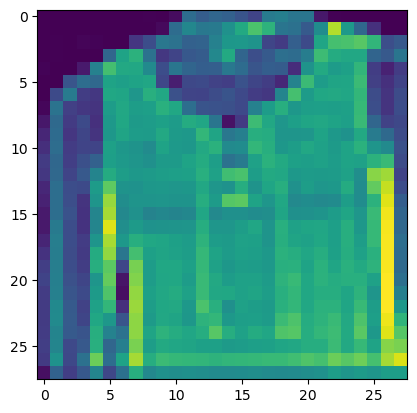

Predicted: T-shirt/top Actual: Pullover


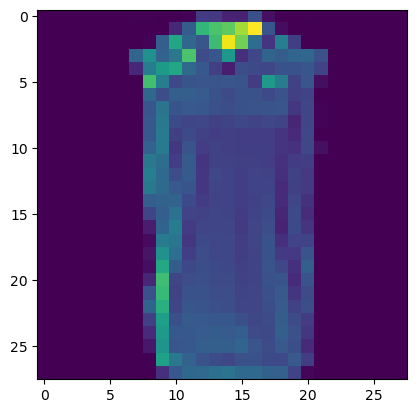

Predicted: Shirt Actual: Dress


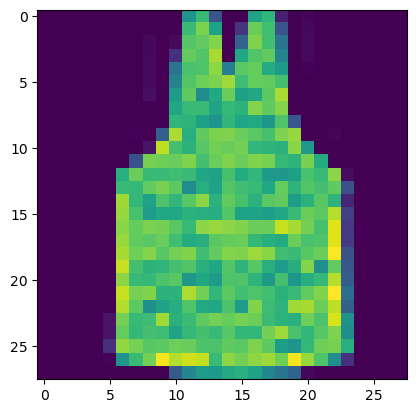

Predicted: Shirt Actual: Coat


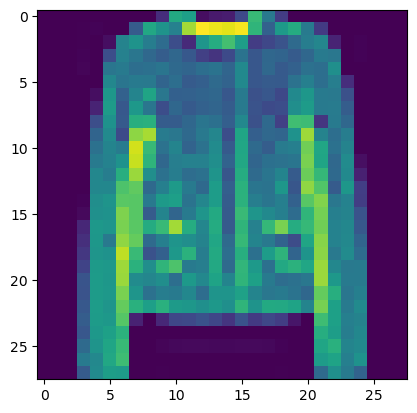

Predicted: T-shirt/top Actual: Shirt


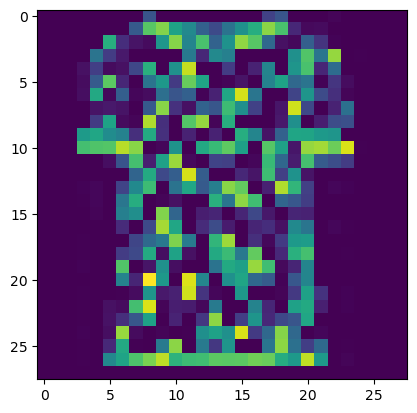

Predicted: Sandal Actual: Sneaker


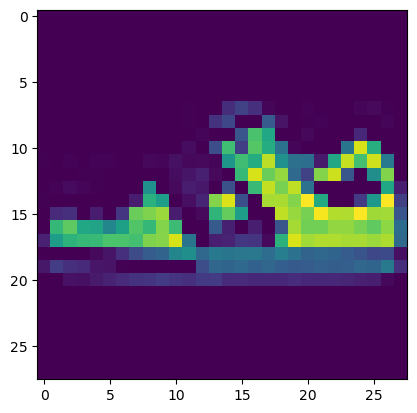

Predicted: Dress Actual: T-shirt/top


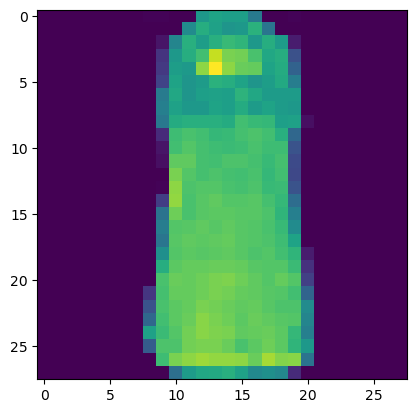

Predicted: T-shirt/top Actual: Shirt


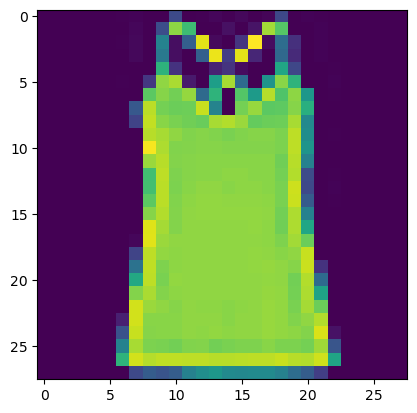

Predicted: Shirt Actual: Dress


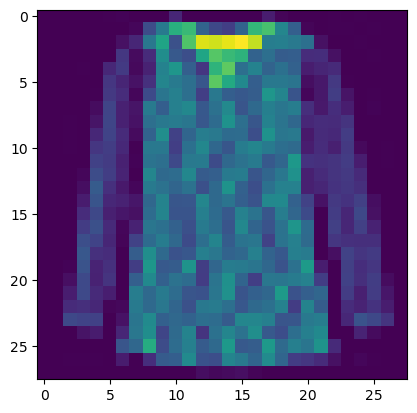

Predicted: Shirt Actual: T-shirt/top


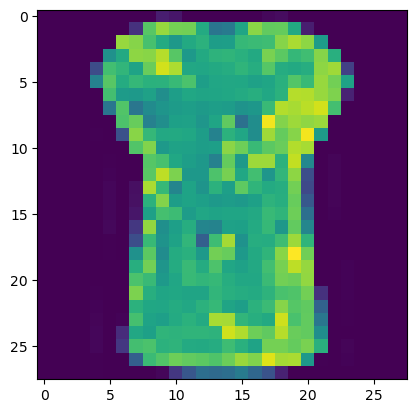

Predicted: Dress Actual: Trouser


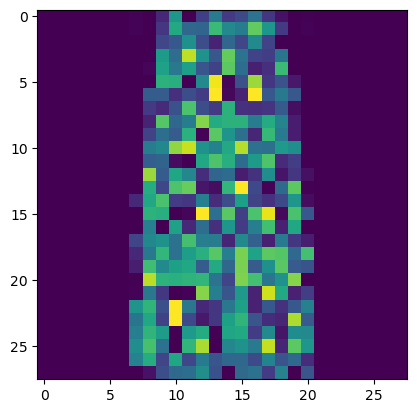

Predicted: Pullover Actual: T-shirt/top


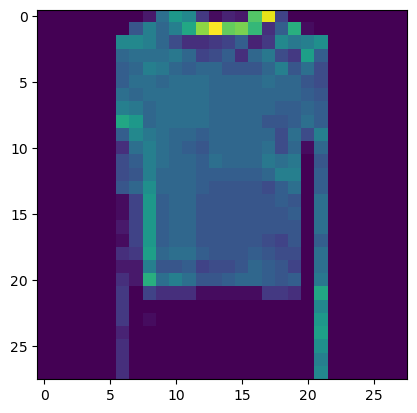

Predicted: Pullover Actual: Shirt


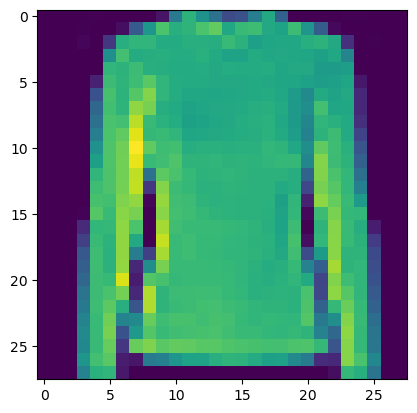

Predicted: Coat Actual: Dress


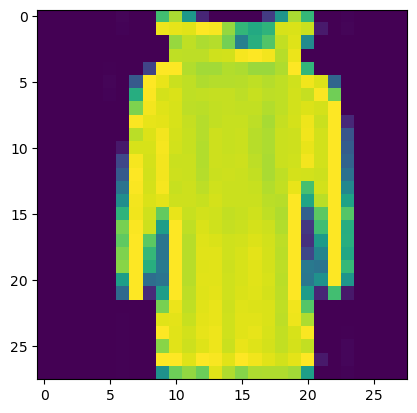

Predicted: Shirt Actual: Pullover


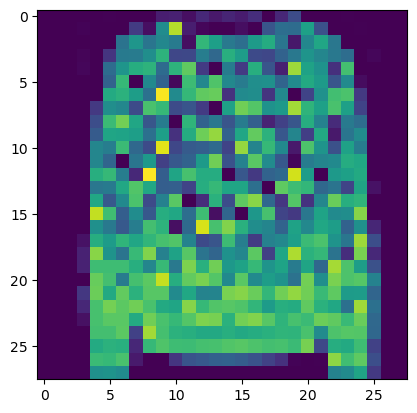

Predicted: T-shirt/top Actual: Shirt


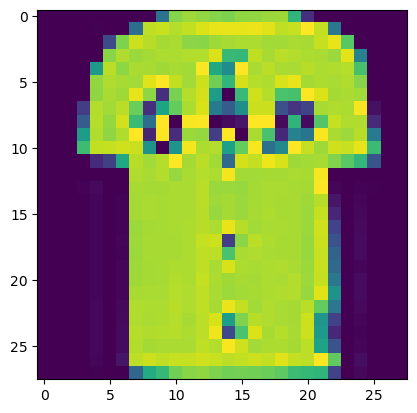

Predicted: T-shirt/top Actual: Dress


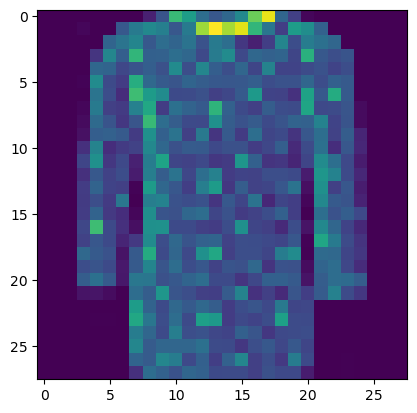

Predicted: T-shirt/top Actual: Pullover


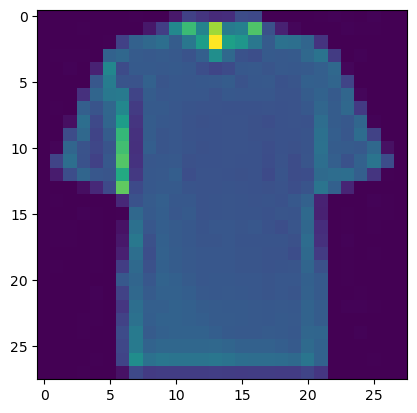

Predicted: Pullover Actual: Shirt


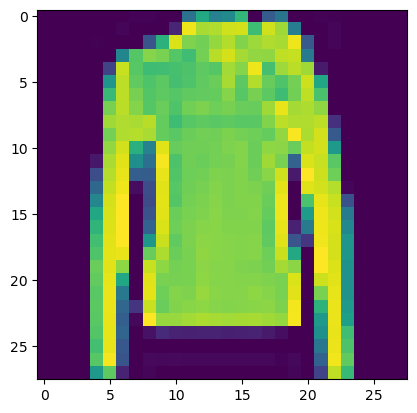

Predicted: Sneaker Actual: Sandal


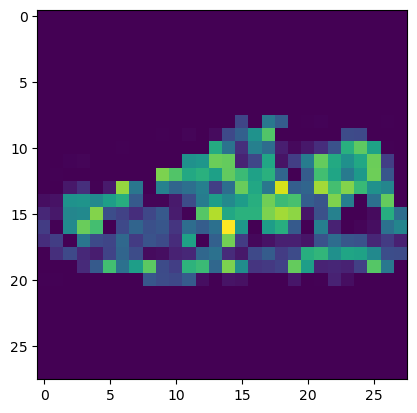

Predicted: Pullover Actual: T-shirt/top


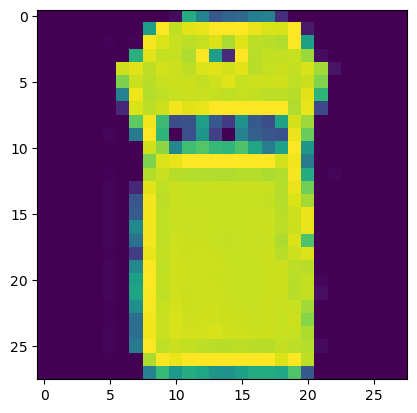

Predicted: Pullover Actual: Coat


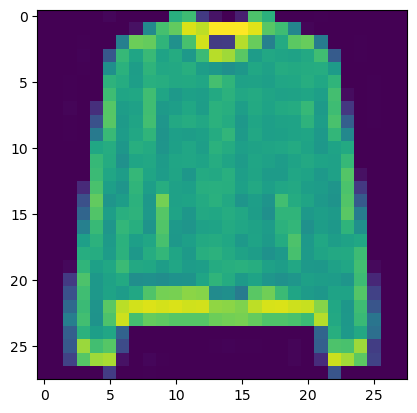

Predicted: Shirt Actual: T-shirt/top


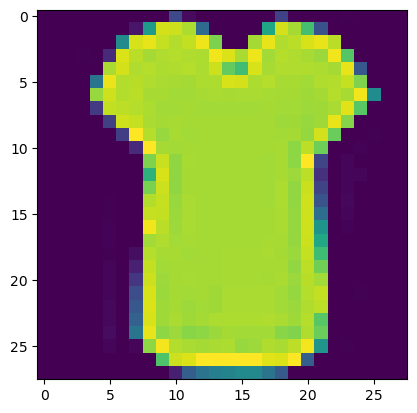

Predicted: Shirt Actual: T-shirt/top


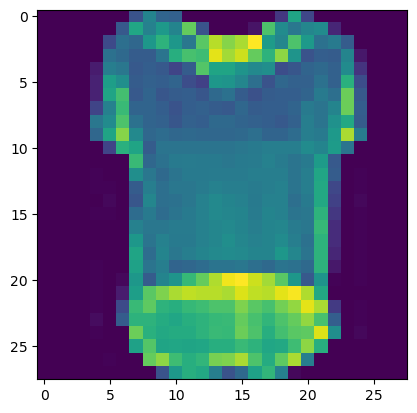

Predicted: T-shirt/top Actual: Shirt


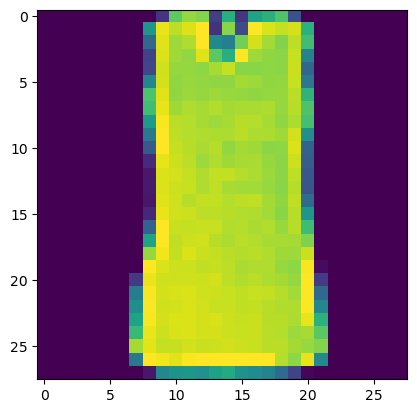

Predicted: T-shirt/top Actual: Shirt


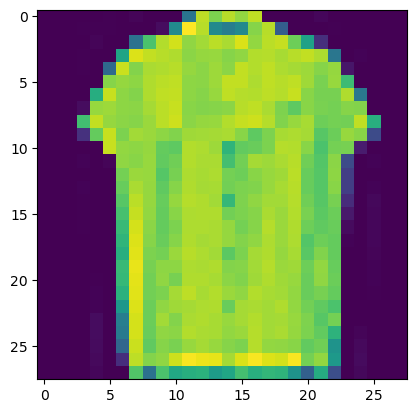

Predicted: Shirt Actual: Trouser


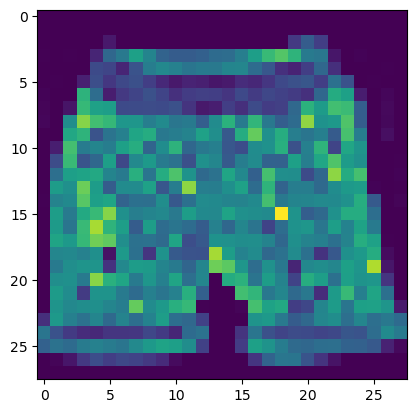

Predicted: T-shirt/top Actual: Shirt


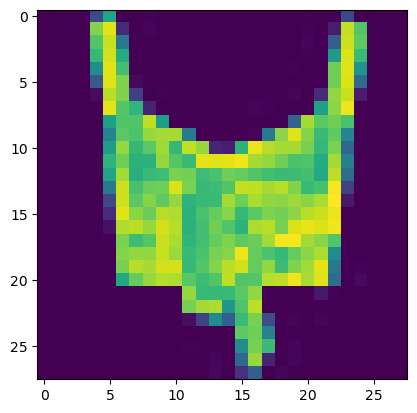

Predicted: T-shirt/top Actual: Shirt


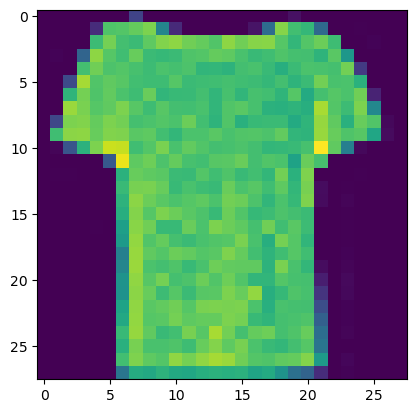

Predicted: T-shirt/top Actual: Pullover


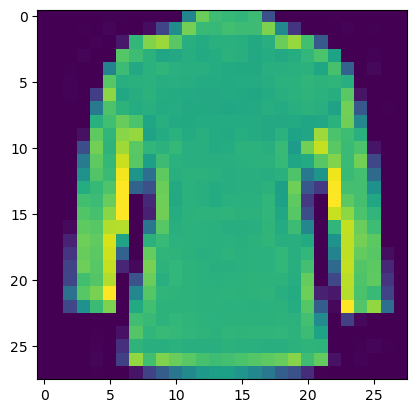

Predicted: T-shirt/top Actual: Dress


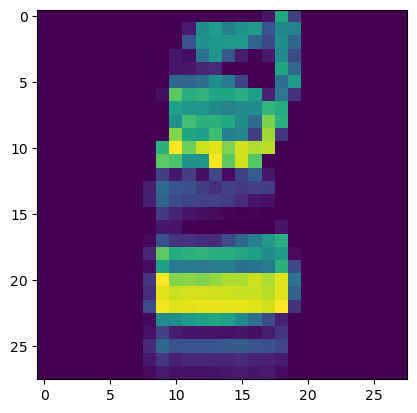

Predicted: Pullover Actual: Shirt


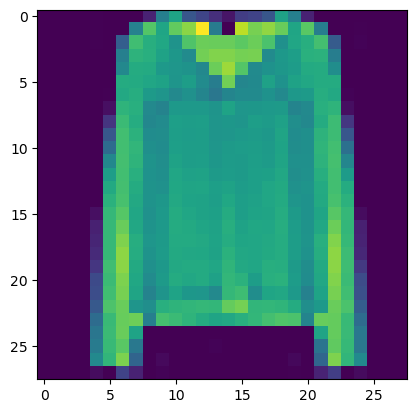

Predicted: Pullover Actual: Coat


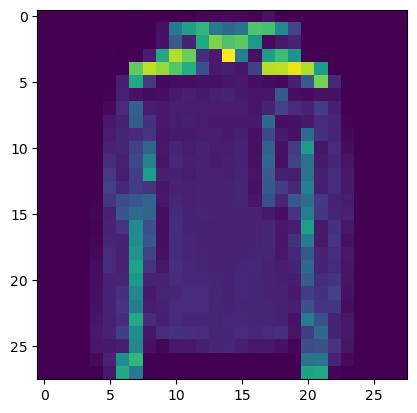

Predicted: Shirt Actual: T-shirt/top


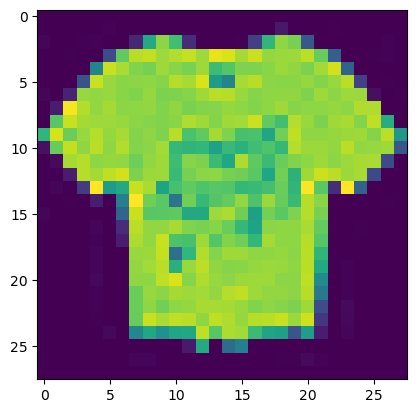

Predicted: Shirt Actual: T-shirt/top


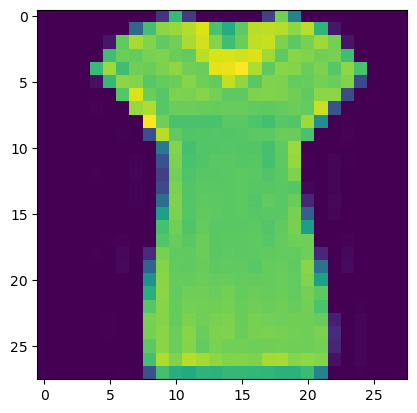

Predicted: Pullover Actual: Coat


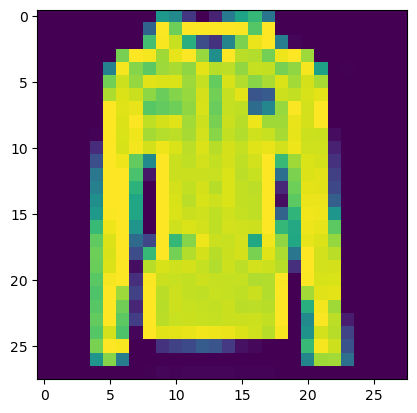

Predicted: T-shirt/top Actual: Shirt


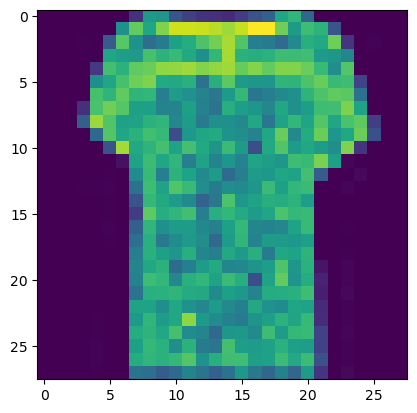

Predicted: T-shirt/top Actual: Shirt


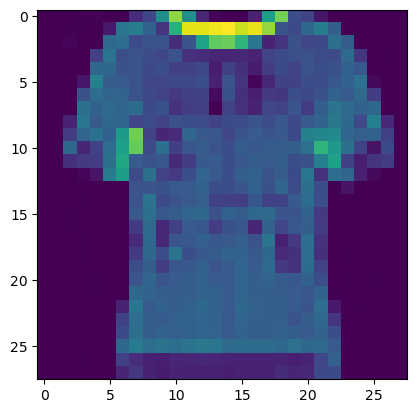

Predicted: Shirt Actual: T-shirt/top


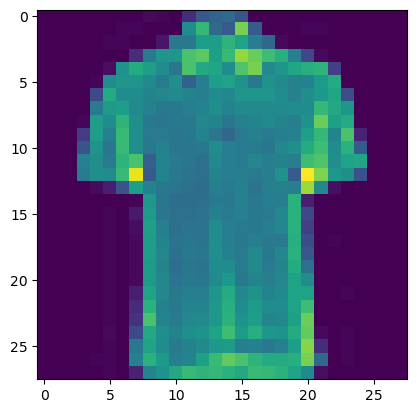

Predicted: Coat Actual: Pullover


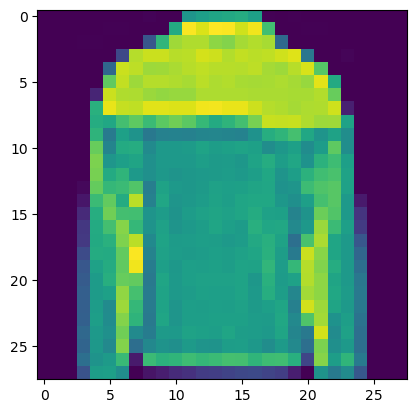

Predicted: Shirt Actual: Pullover


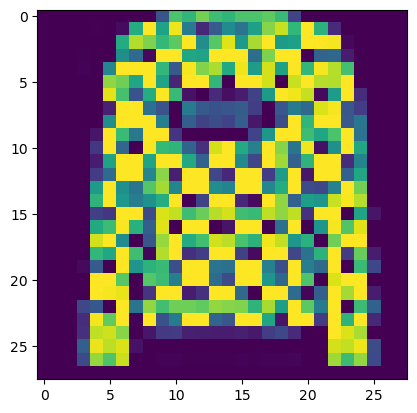

Predicted: Pullover Actual: Shirt


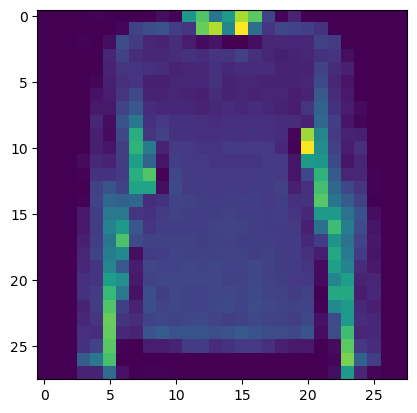

Predicted: Sneaker Actual: Ankle boot


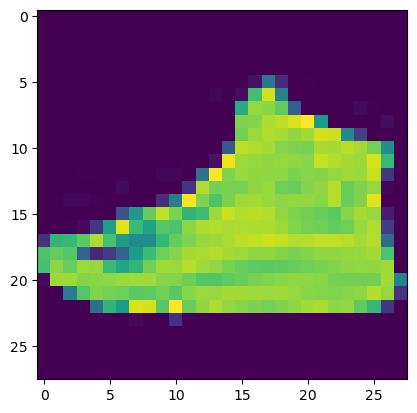

Predicted: Pullover Actual: Shirt


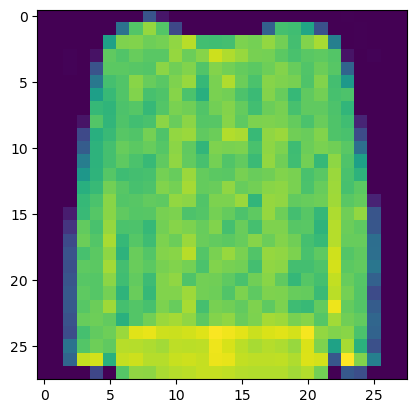

Predicted: Pullover Actual: Shirt


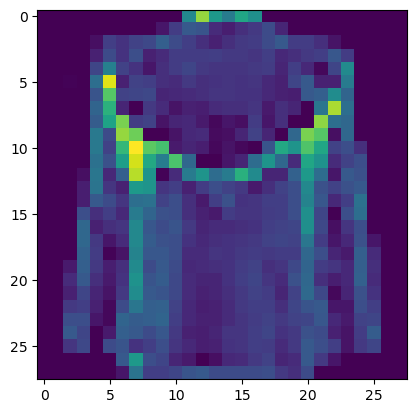

Predicted: T-shirt/top Actual: Shirt


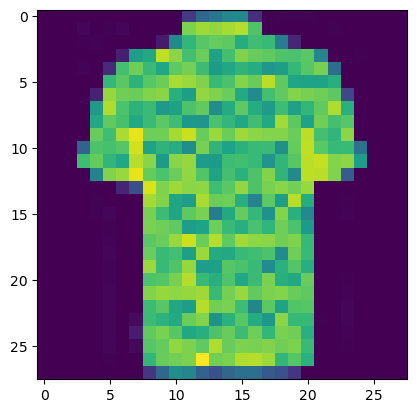

Predicted: Shirt Actual: Coat


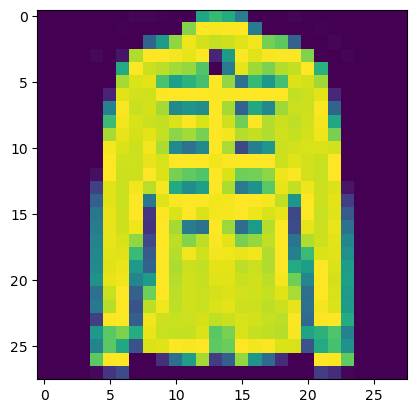

Predicted: Shirt Actual: Pullover


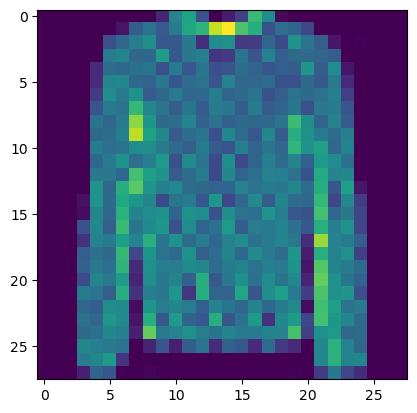

Predicted: T-shirt/top Actual: Shirt


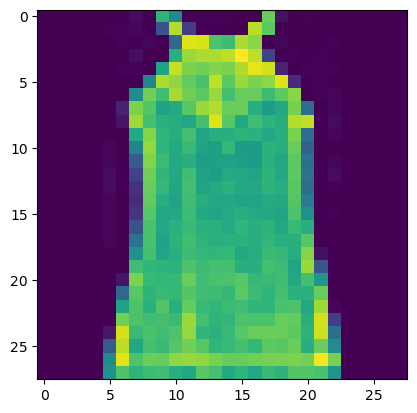

Predicted: Shirt Actual: Dress


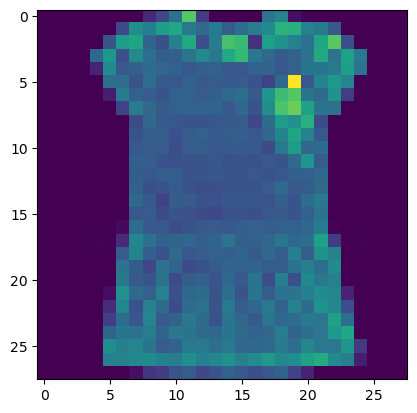

Predicted: Coat Actual: Dress


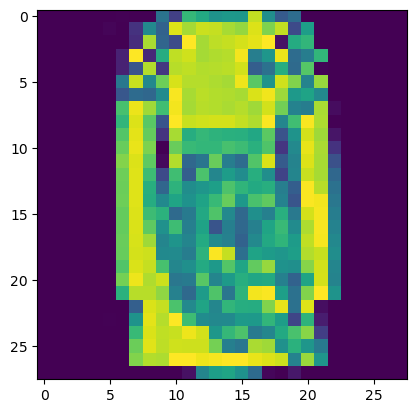

Predicted: Dress Actual: Shirt


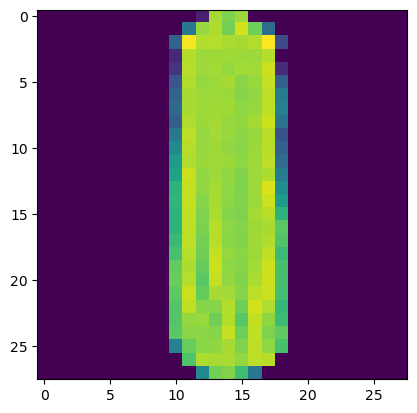

Predicted: Shirt Actual: Pullover


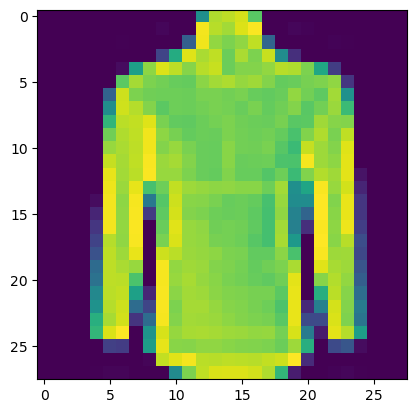

Predicted: Coat Actual: Pullover


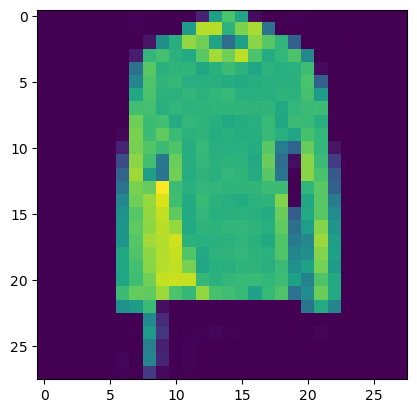

Predicted: Ankle boot Actual: Sneaker


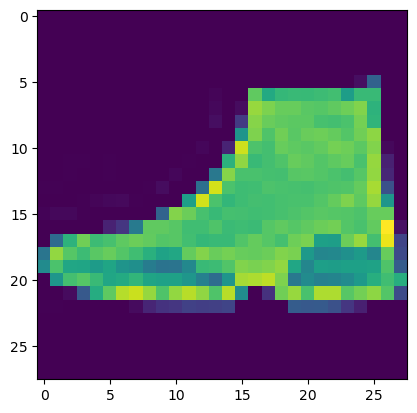

Predicted: Dress Actual: Coat


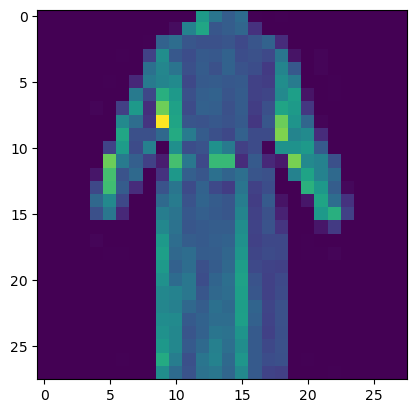

Predicted: Shirt Actual: Pullover


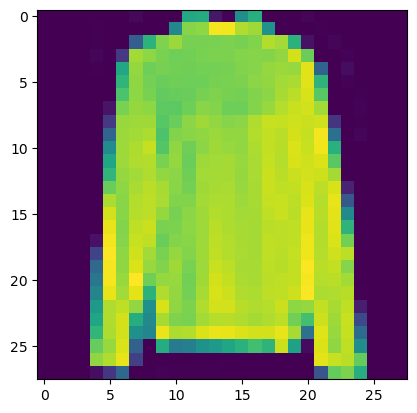

Predicted: Pullover Actual: Coat


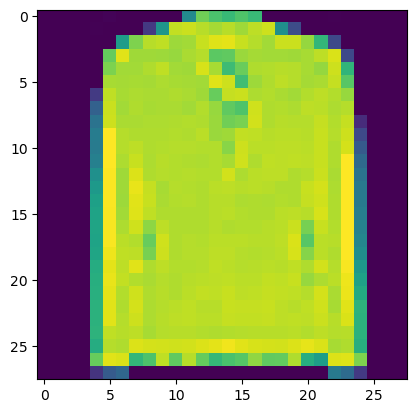

Predicted: Coat Actual: Shirt


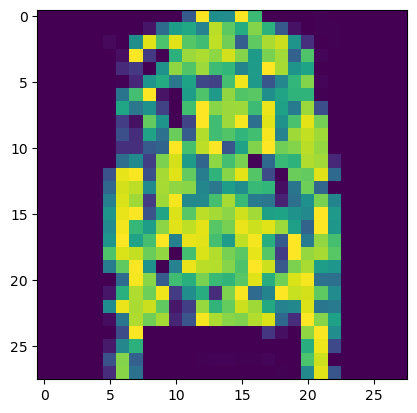

Predicted: T-shirt/top Actual: Shirt


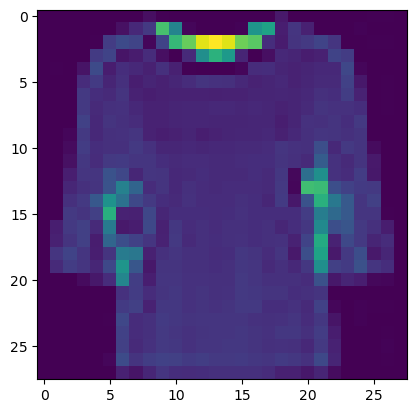

Predicted: Shirt Actual: Pullover


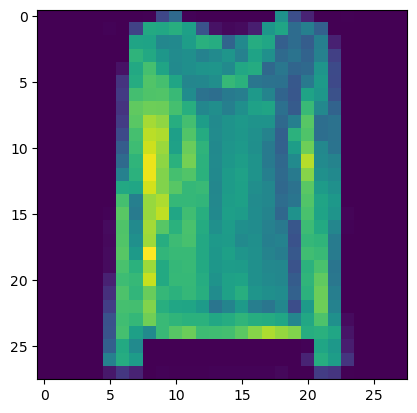

Predicted: Shirt Actual: T-shirt/top


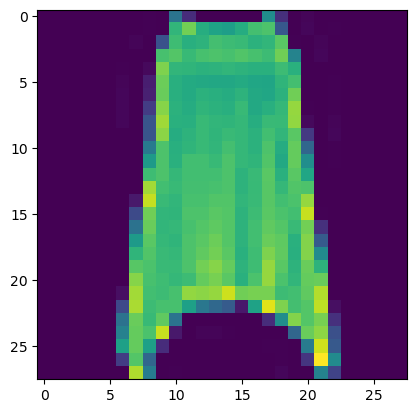

Predicted: Shirt Actual: Dress


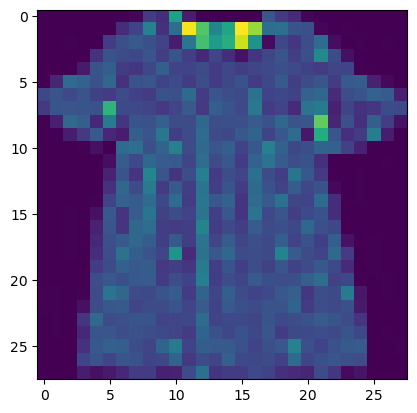

Predicted: Coat Actual: Shirt


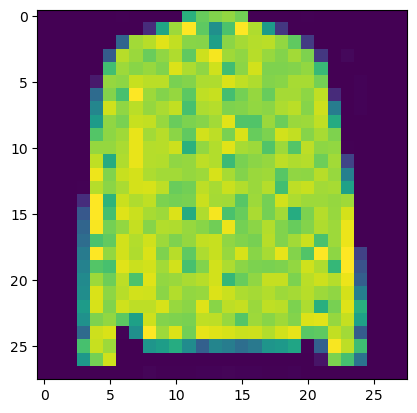

Predicted: Shirt Actual: T-shirt/top


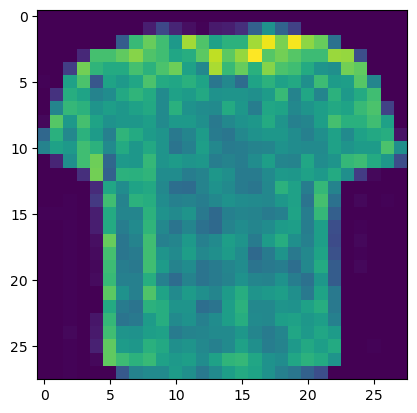

Predicted: Pullover Actual: Coat


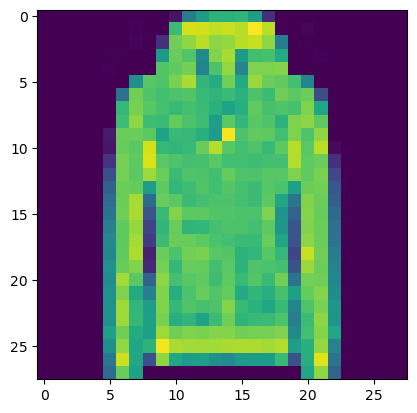

Predicted: Shirt Actual: T-shirt/top


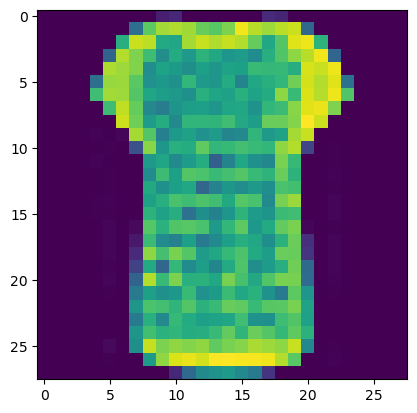

Predicted: T-shirt/top Actual: Shirt


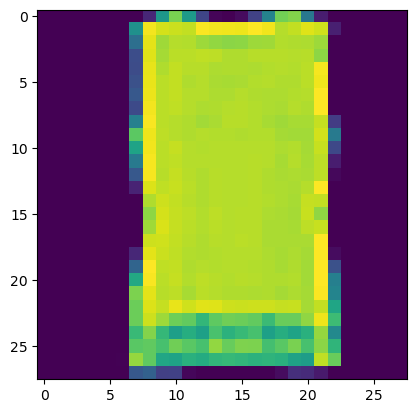

Predicted: Shirt Actual: Pullover


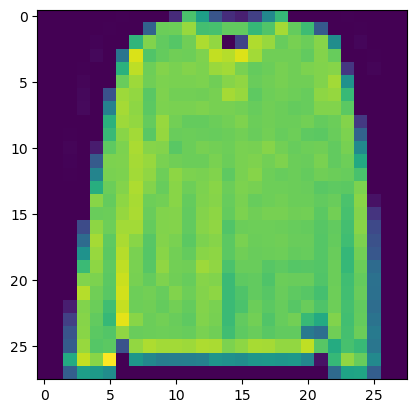

Predicted: Dress Actual: Shirt


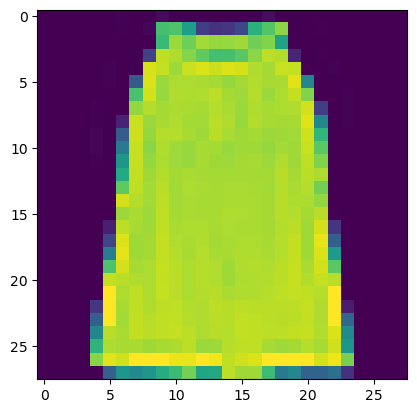

Predicted: T-shirt/top Actual: Shirt


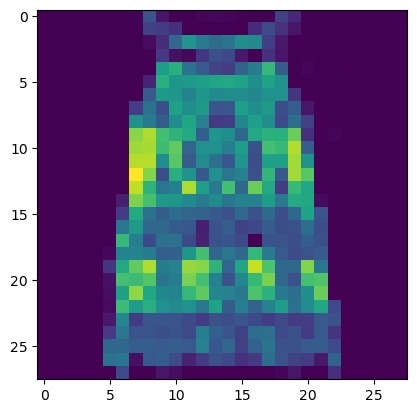

Predicted: Pullover Actual: Coat


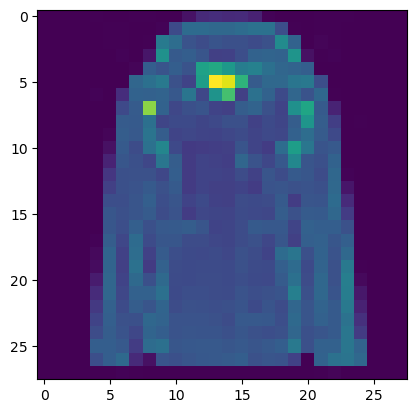

Predicted: Shirt Actual: T-shirt/top


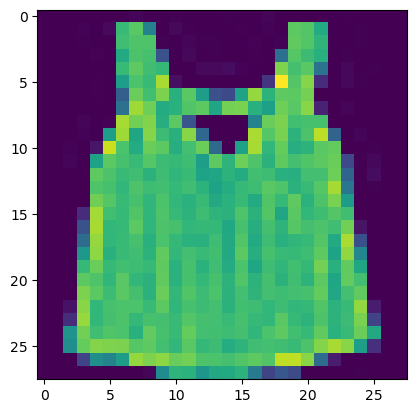

Predicted: Dress Actual: Pullover


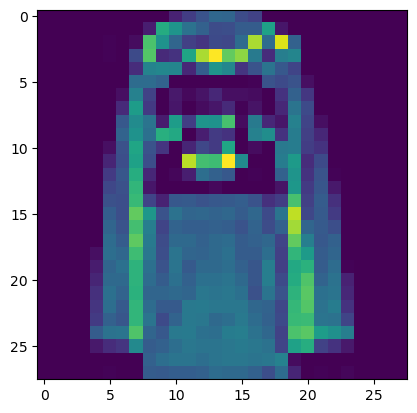

Predicted: Pullover Actual: Shirt


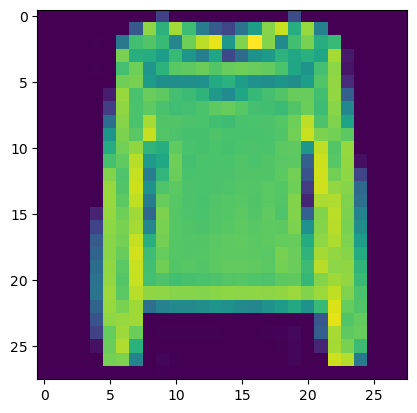

Predicted: Shirt Actual: Dress


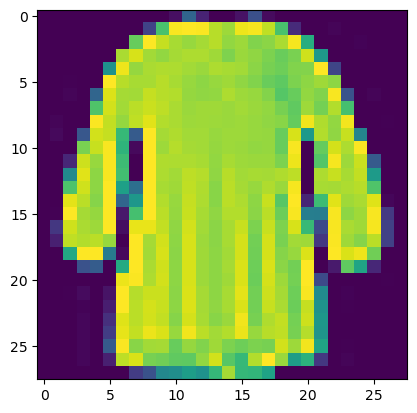

Predicted: Dress Actual: Pullover


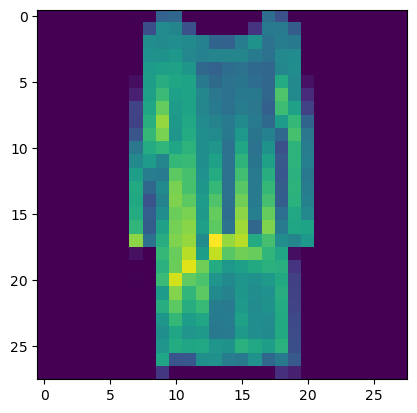

Predicted: Pullover Actual: Coat


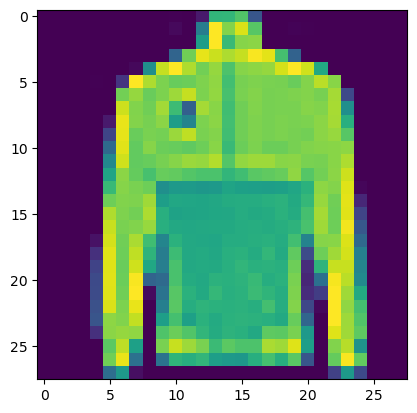

Predicted: Dress Actual: Shirt


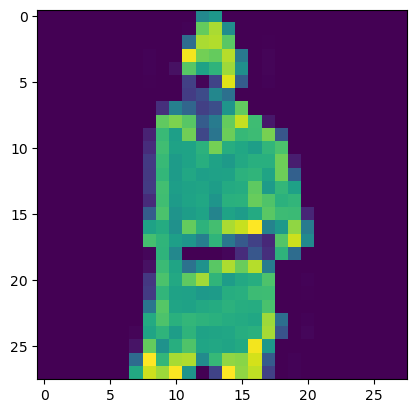

Predicted: Sneaker Actual: Sandal


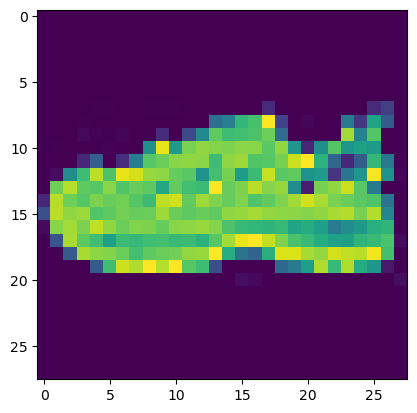

Predicted: T-shirt/top Actual: Pullover


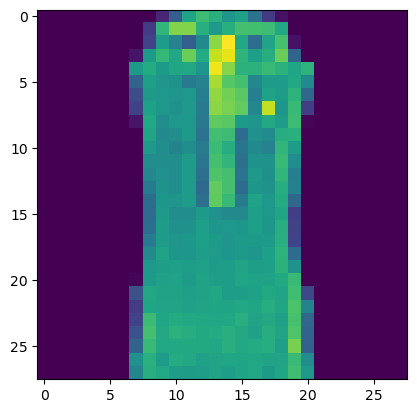

Predicted: T-shirt/top Actual: Shirt


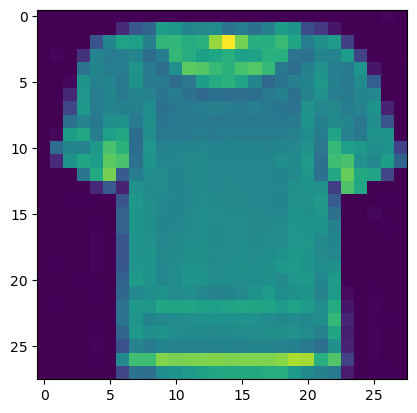

Predicted: Shirt Actual: T-shirt/top


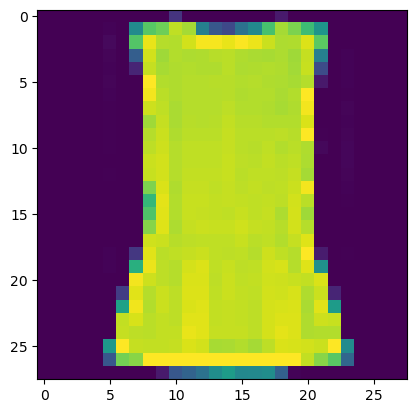

Predicted: Pullover Actual: Shirt


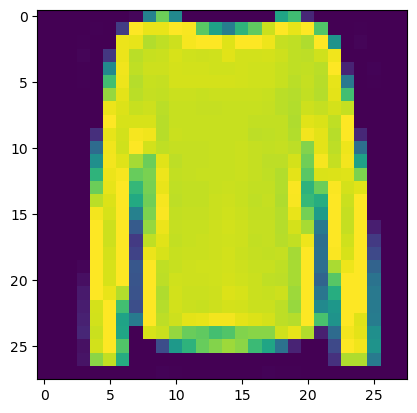

Predicted: Pullover Actual: Coat


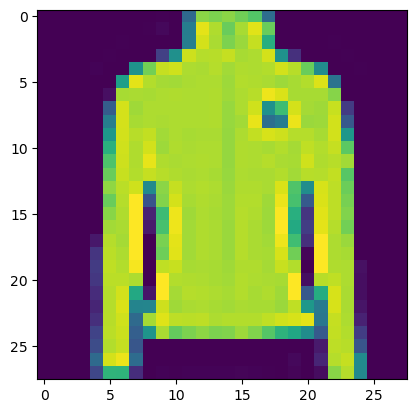

Predicted: Sneaker Actual: Ankle boot


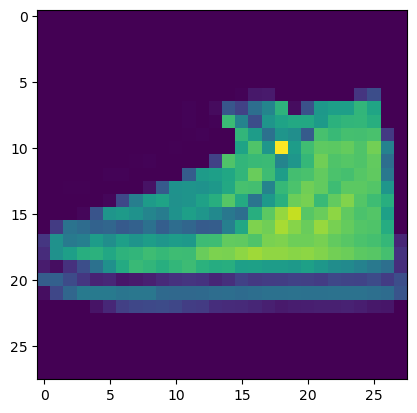

Predicted: Coat Actual: Pullover


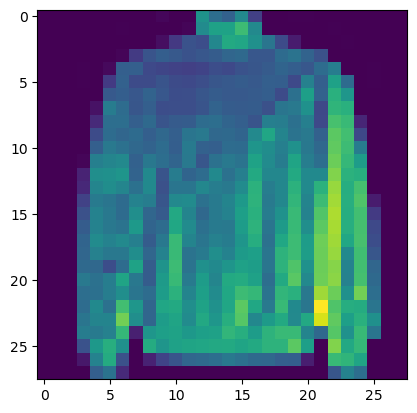

Predicted: Coat Actual: Shirt


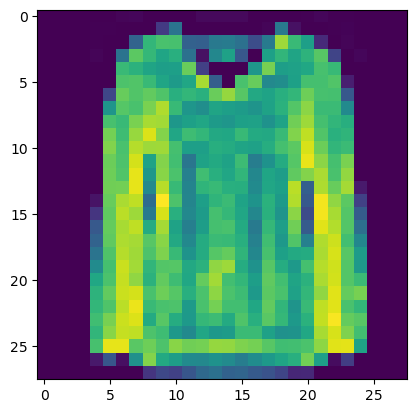

Predicted: Shirt Actual: Pullover


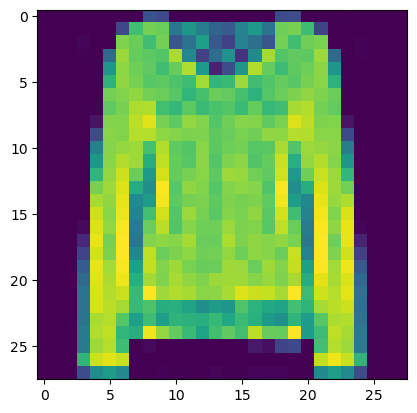

Predicted: Shirt Actual: Pullover


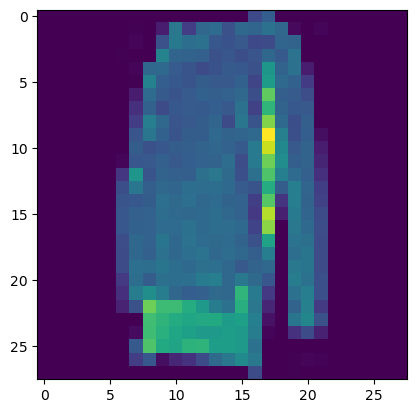

Predicted: Shirt Actual: Pullover


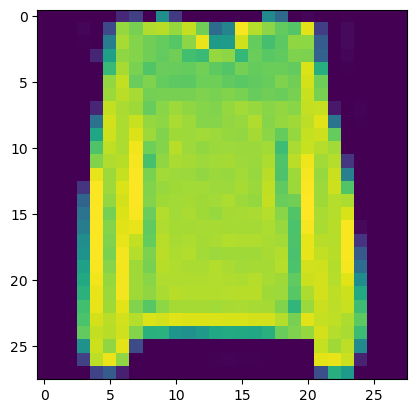

Predicted: Coat Actual: Shirt


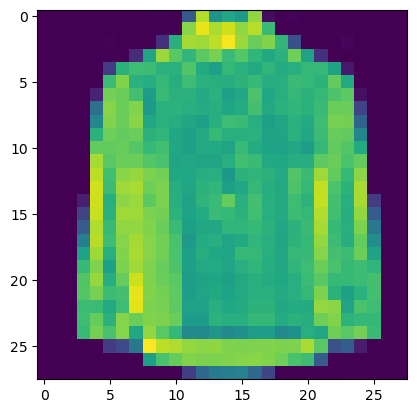

Predicted: T-shirt/top Actual: Shirt


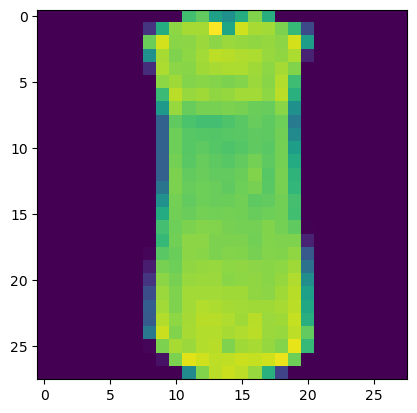

Predicted: T-shirt/top Actual: Shirt


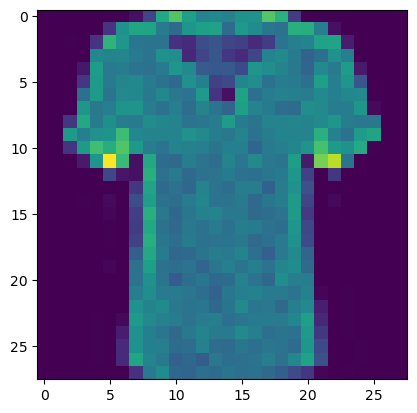

Predicted: Coat Actual: Shirt


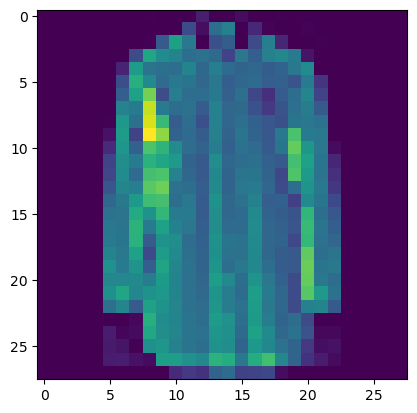

Predicted: Sneaker Actual: Ankle boot


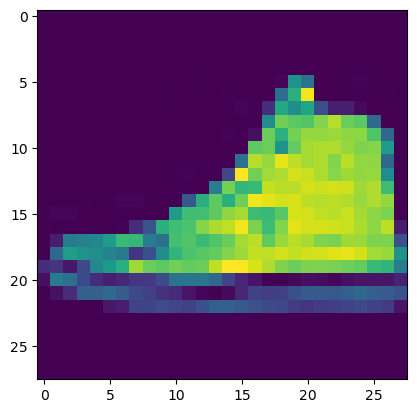

Predicted: T-shirt/top Actual: Shirt


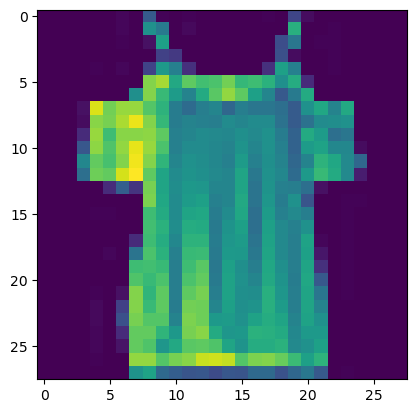

Predicted: Shirt Actual: Pullover


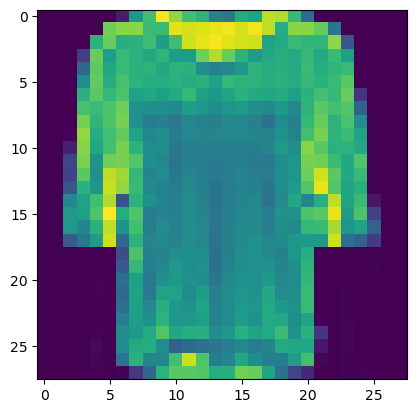

Predicted: Pullover Actual: Shirt


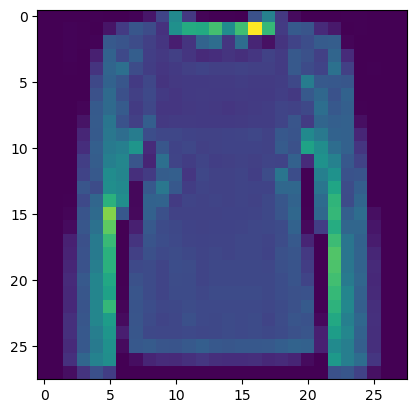

Predicted: Coat Actual: Shirt


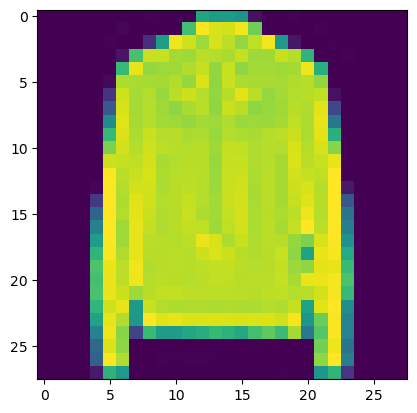

Predicted: Shirt Actual: Coat


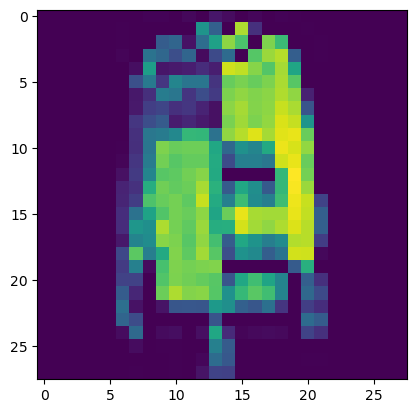

Predicted: Dress Actual: Shirt


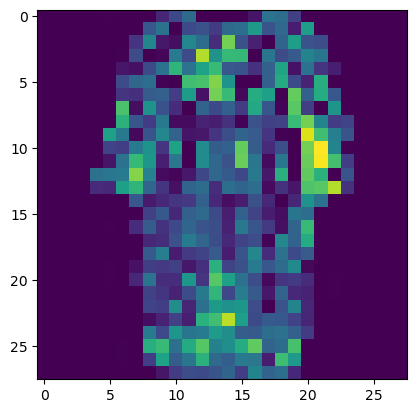

Predicted: Coat Actual: Pullover


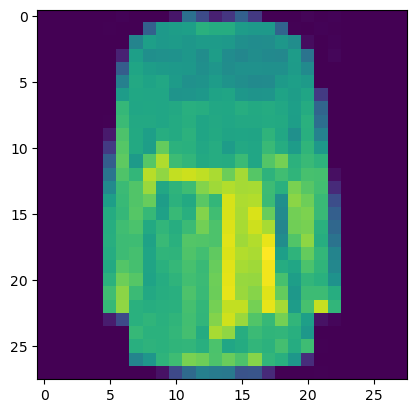

Predicted: T-shirt/top Actual: Shirt


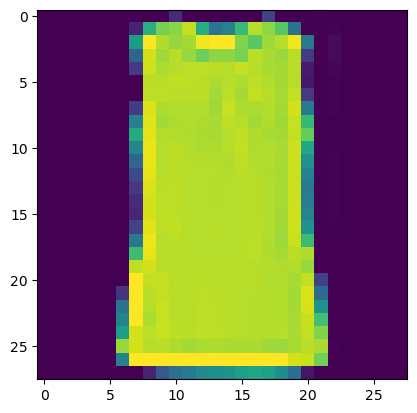

Predicted: Bag Actual: T-shirt/top


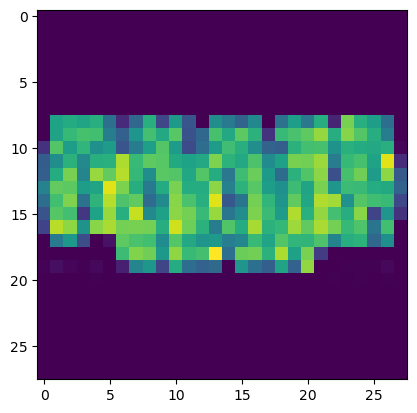

Predicted: Pullover Actual: Dress


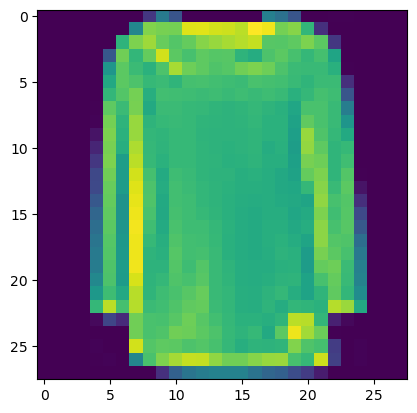

Predicted: Sneaker Actual: Ankle boot


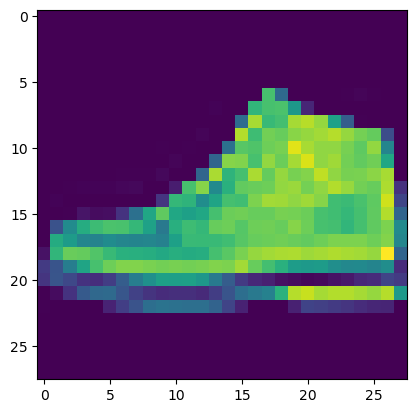

Predicted: T-shirt/top Actual: Shirt


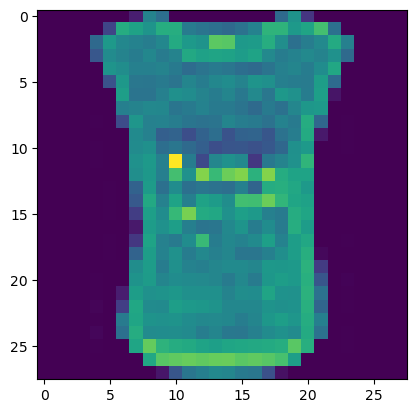

Predicted: T-shirt/top Actual: Shirt


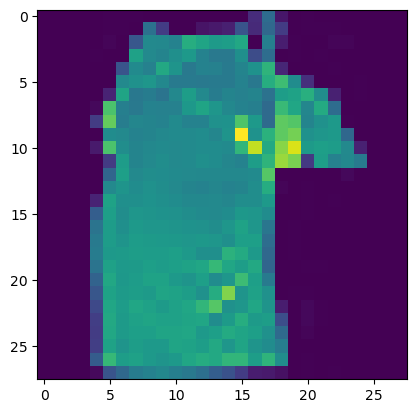

Predicted: Pullover Actual: Coat


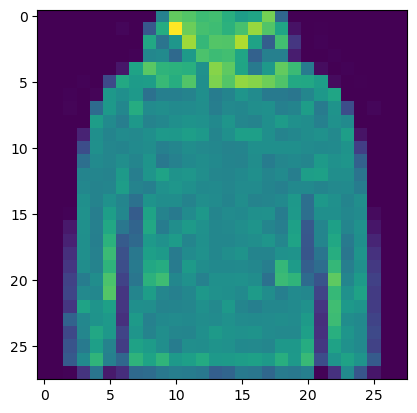

Predicted: T-shirt/top Actual: Shirt


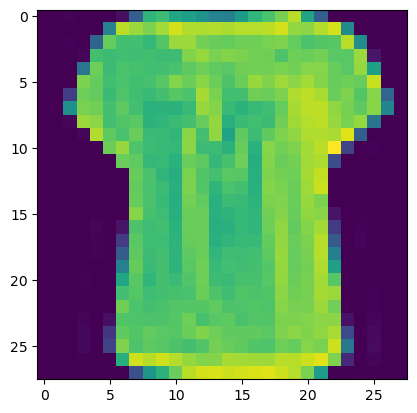

Predicted: T-shirt/top Actual: Shirt


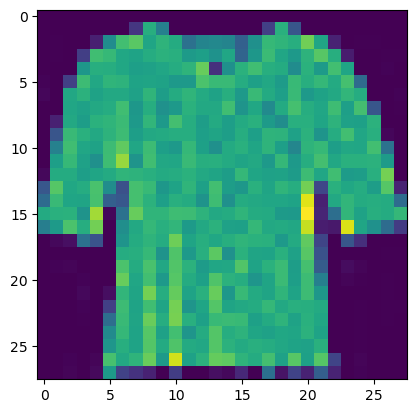

Predicted: T-shirt/top Actual: Bag


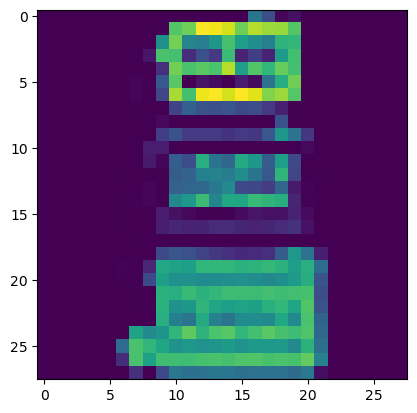

Predicted: Pullover Actual: Coat


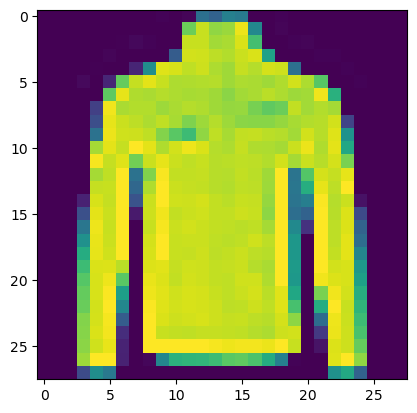

Predicted: T-shirt/top Actual: Shirt


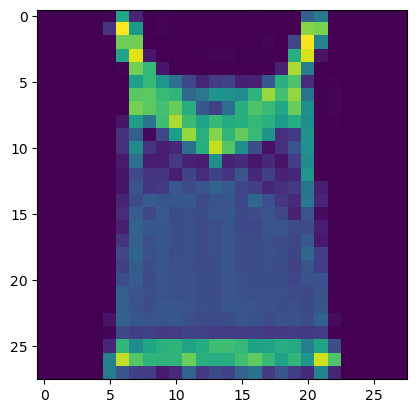

Predicted: Coat Actual: Shirt


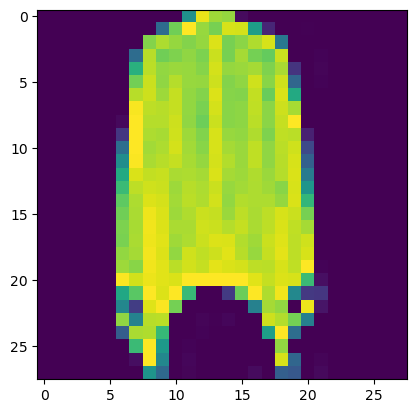

Predicted: Sneaker Actual: Ankle boot


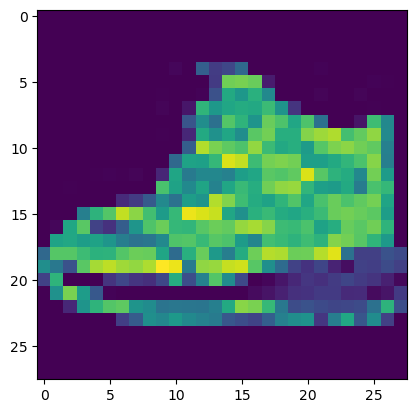

Predicted: Pullover Actual: Shirt


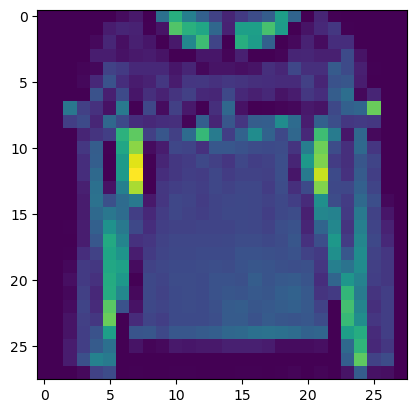

Predicted: Pullover Actual: Coat


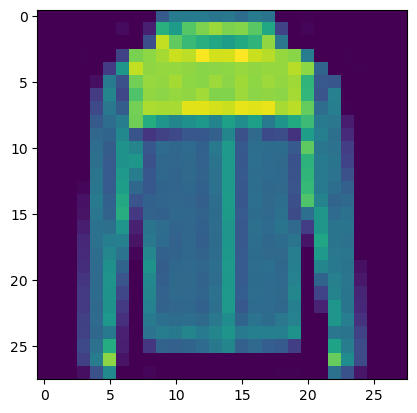

Predicted: Pullover Actual: Coat


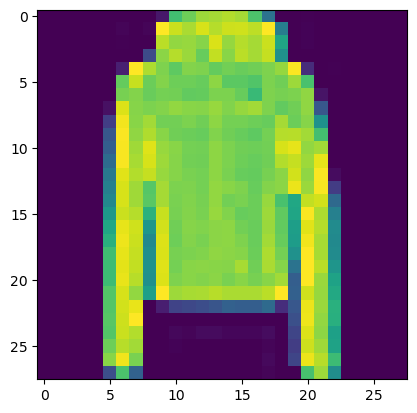

Predicted: Shirt Actual: T-shirt/top


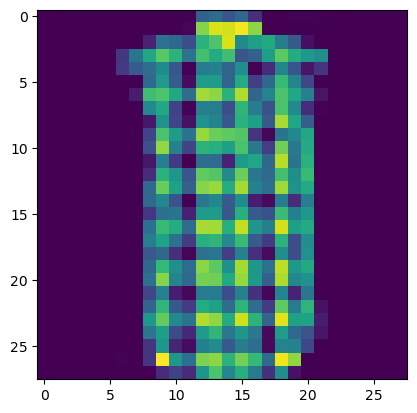

Predicted: Shirt Actual: Coat


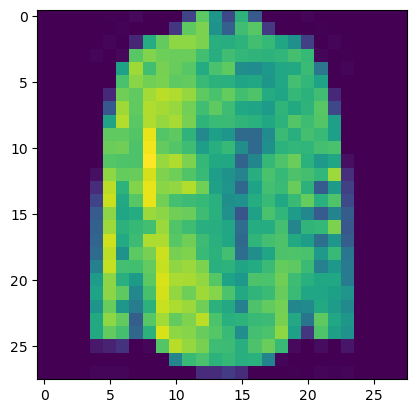

Predicted: Coat Actual: Shirt


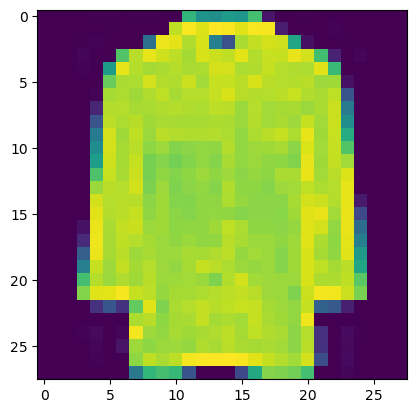

Predicted: Sandal Actual: Sneaker


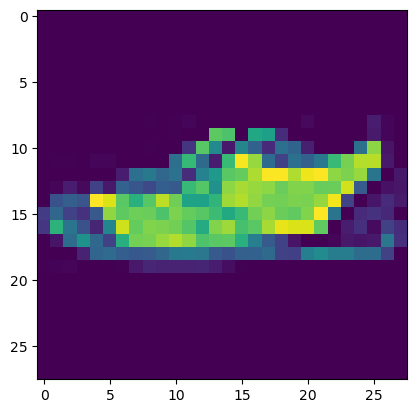

Predicted: Sneaker Actual: Ankle boot


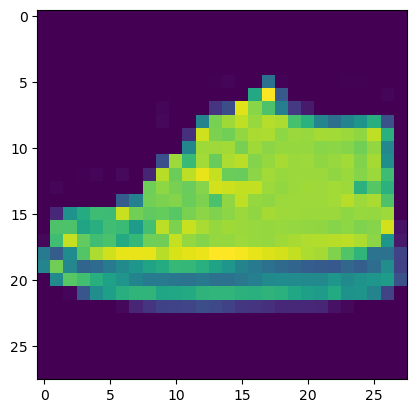

Predicted: Shirt Actual: T-shirt/top


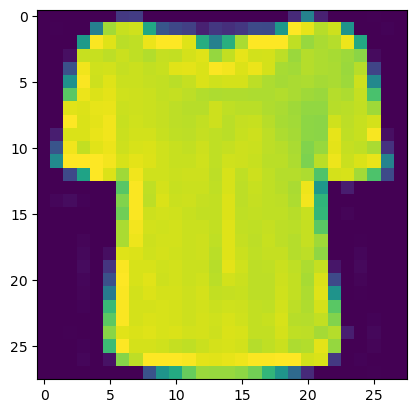

Predicted: Sneaker Actual: T-shirt/top


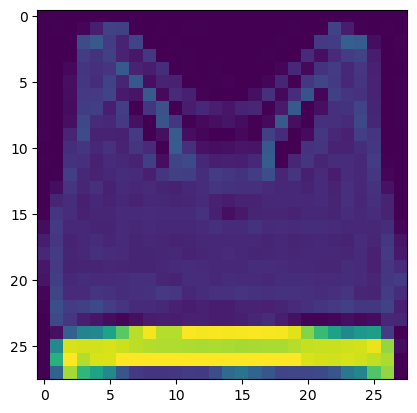

Predicted: Sneaker Actual: Ankle boot


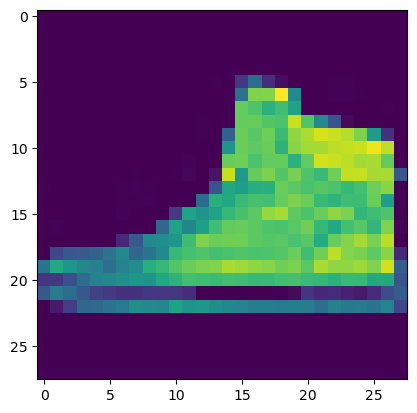

Predicted: Dress Actual: Trouser


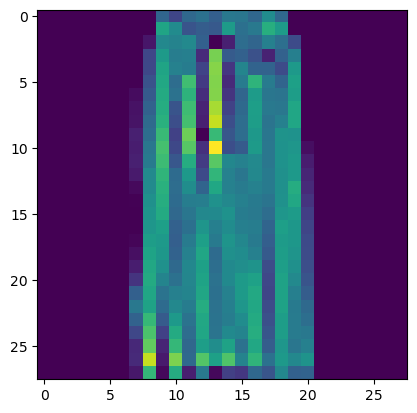

Predicted: Pullover Actual: Shirt


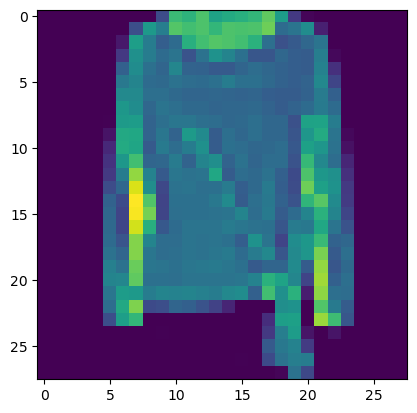

Predicted: Sneaker Actual: Ankle boot


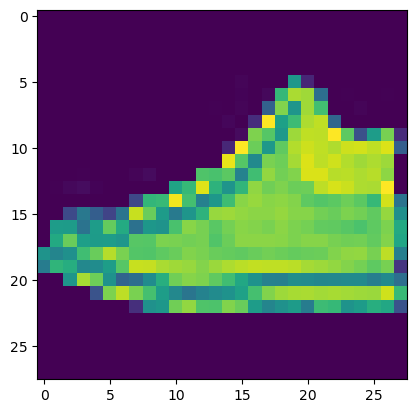

Predicted: Pullover Actual: Shirt


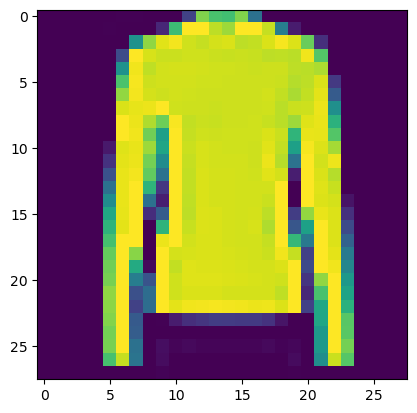

Predicted: Dress Actual: Pullover


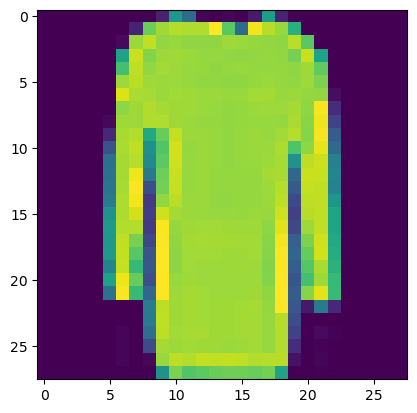

Predicted: Coat Actual: Dress


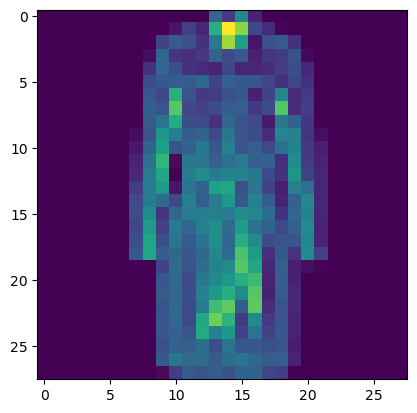

Predicted: T-shirt/top Actual: Shirt


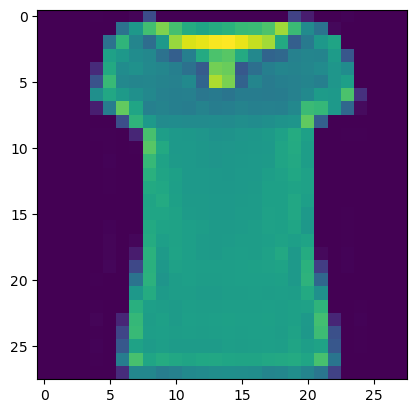

Predicted: T-shirt/top Actual: Shirt


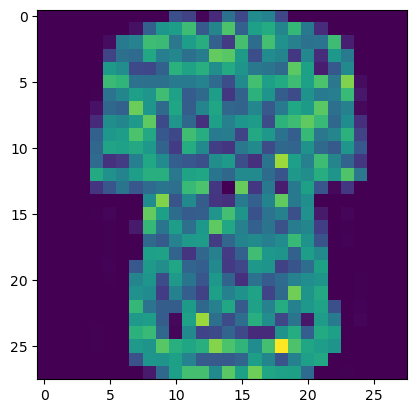

Predicted: T-shirt/top Actual: Ankle boot


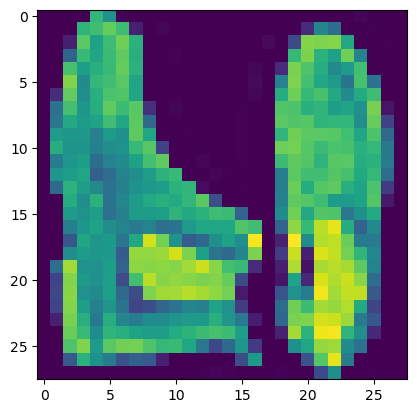

Predicted: T-shirt/top Actual: Pullover


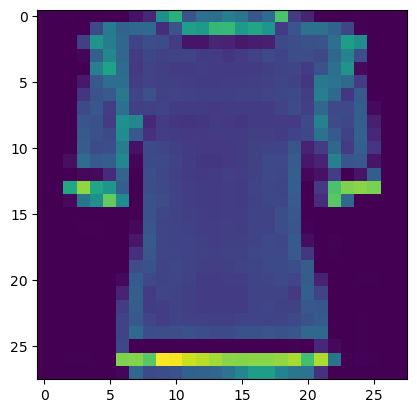

Predicted: Shirt Actual: Coat


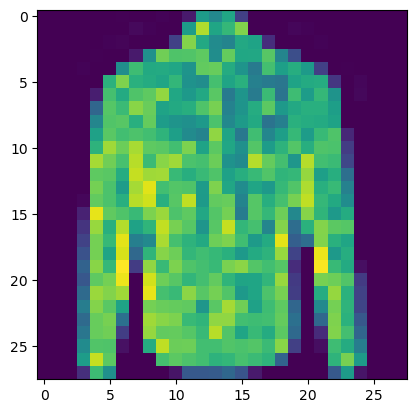

Predicted: Sneaker Actual: Sandal


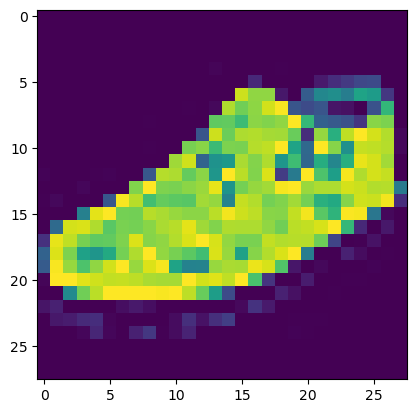

Predicted: Coat Actual: Pullover


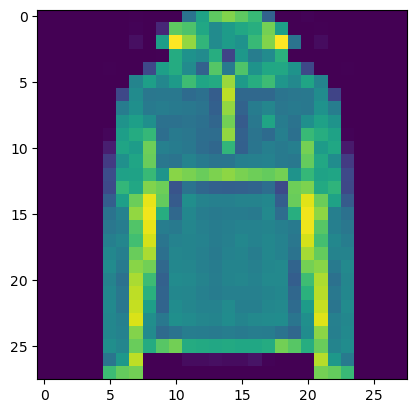

Predicted: Shirt Actual: Pullover


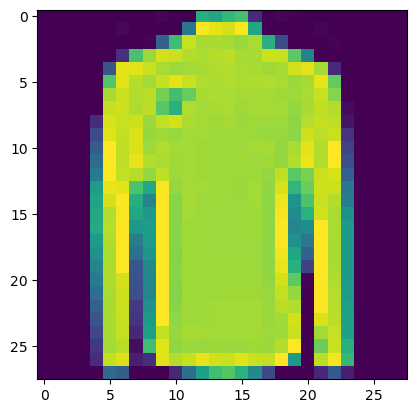

Predicted: Pullover Actual: Coat


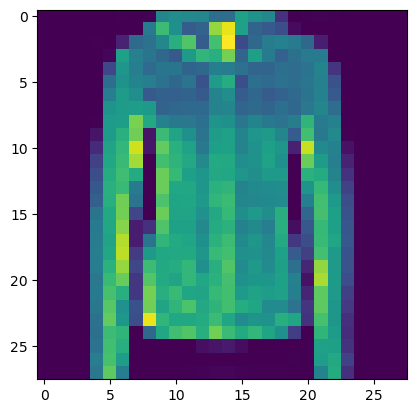

Predicted: T-shirt/top Actual: Shirt


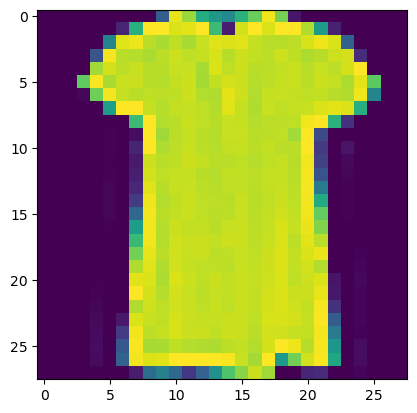

Predicted: T-shirt/top Actual: Pullover


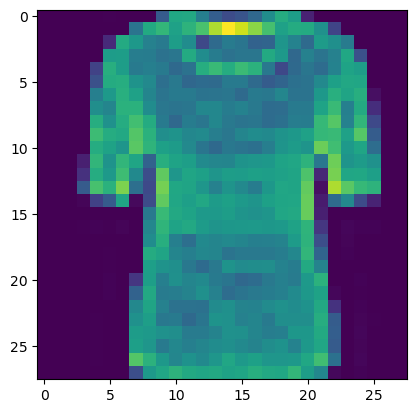

Predicted: Dress Actual: Bag


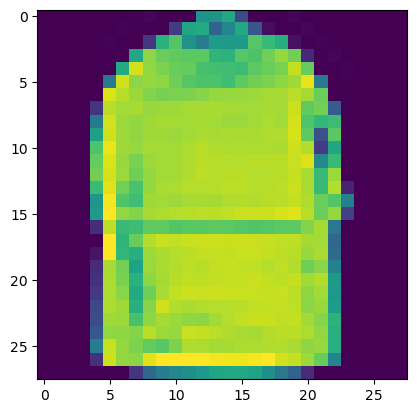

Predicted: T-shirt/top Actual: Shirt


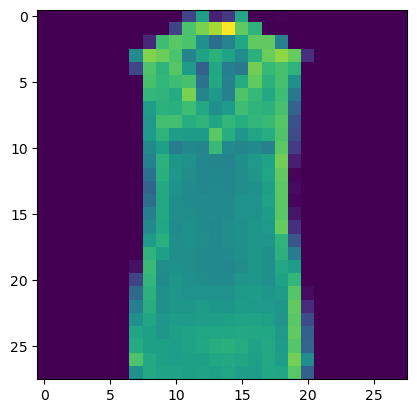

Predicted: Shirt Actual: Coat


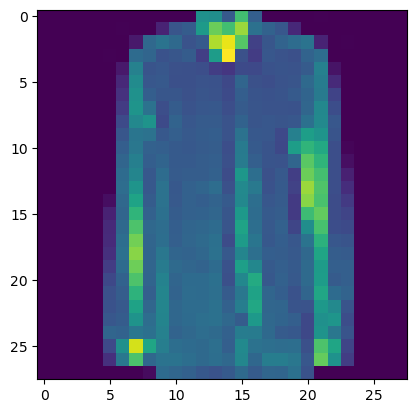

Predicted: Shirt Actual: Dress


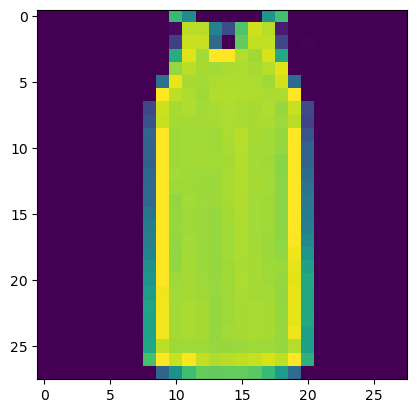

Predicted: Pullover Actual: Coat


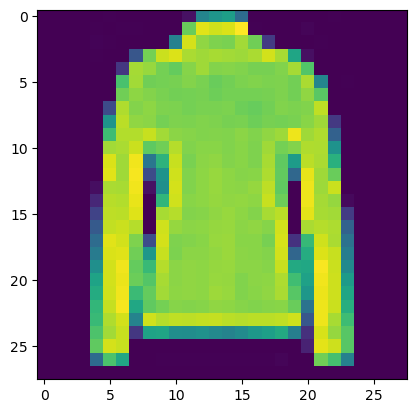

Predicted: Pullover Actual: Coat


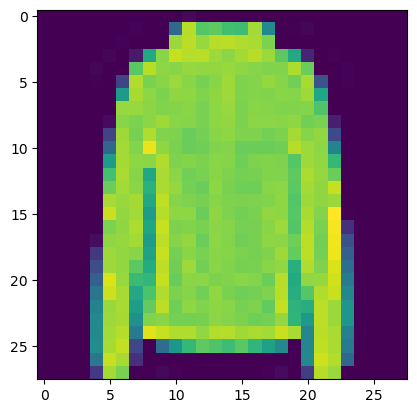

Predicted: Pullover Actual: Coat


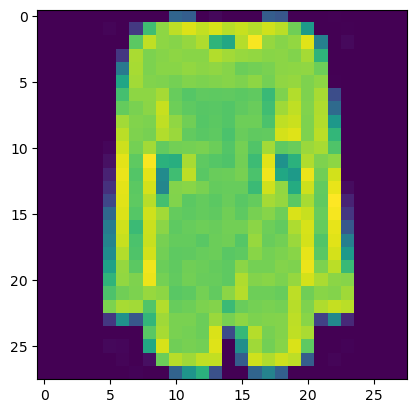

Predicted: Pullover Actual: Dress


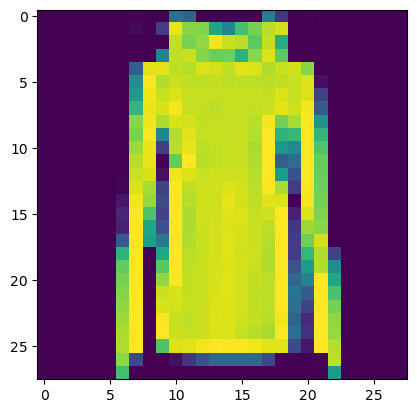

Predicted: Coat Actual: Shirt


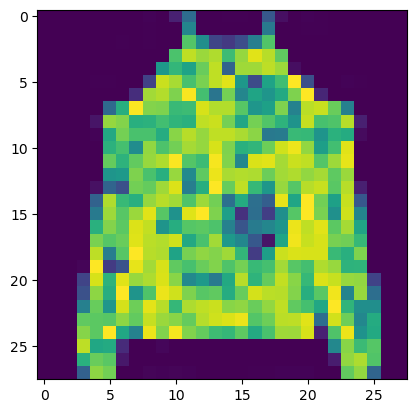

Predicted: Coat Actual: Pullover


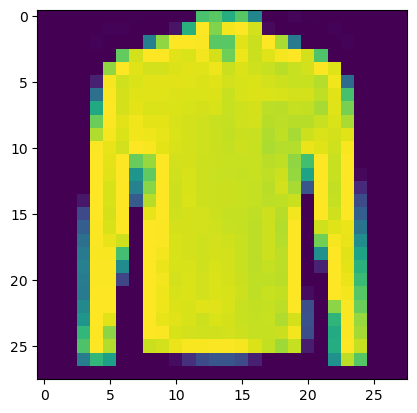

Predicted: Dress Actual: Shirt


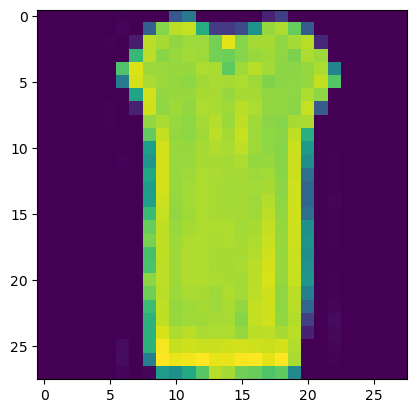

Predicted: Shirt Actual: Trouser


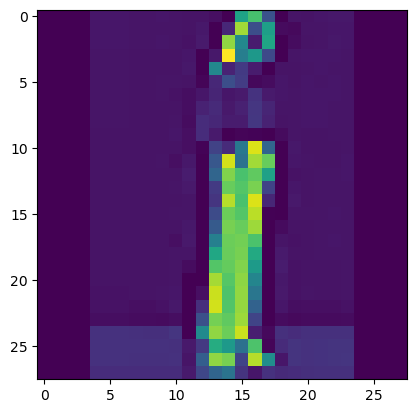

Predicted: Coat Actual: Shirt


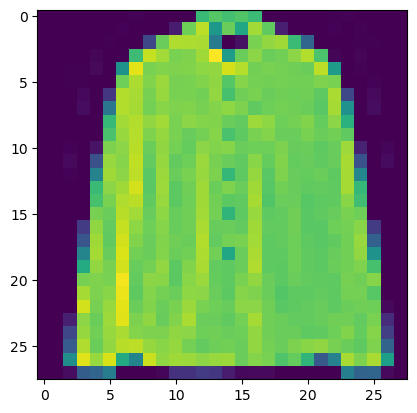

Predicted: Shirt Actual: Coat


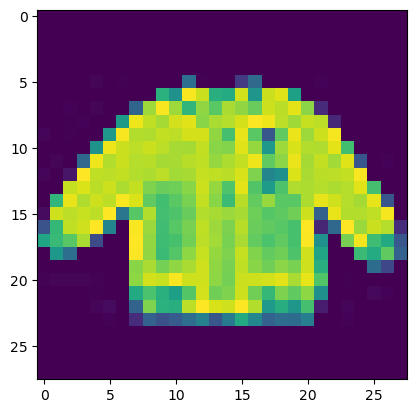

Predicted: Pullover Actual: Shirt


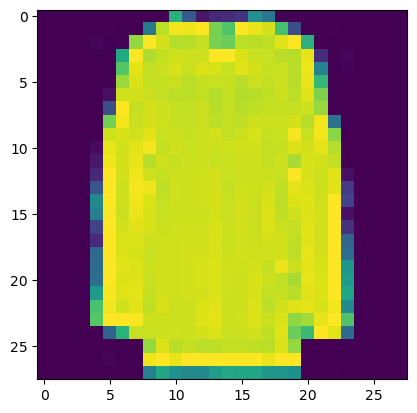

Predicted: Coat Actual: Shirt


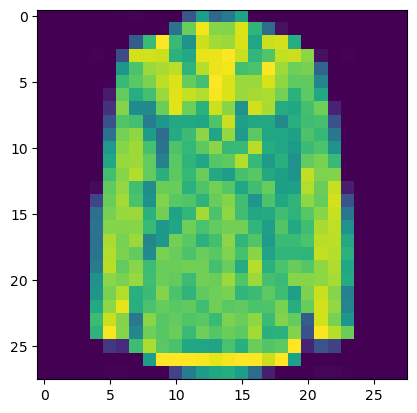

Predicted: Trouser Actual: Dress


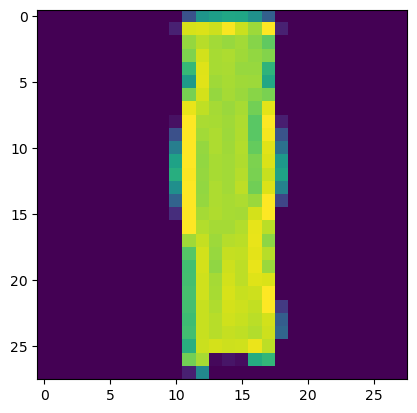

Predicted: Shirt Actual: T-shirt/top


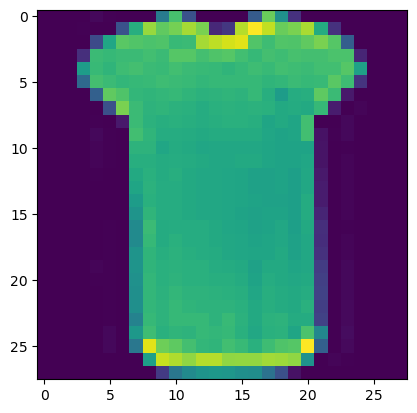

Predicted: Shirt Actual: T-shirt/top


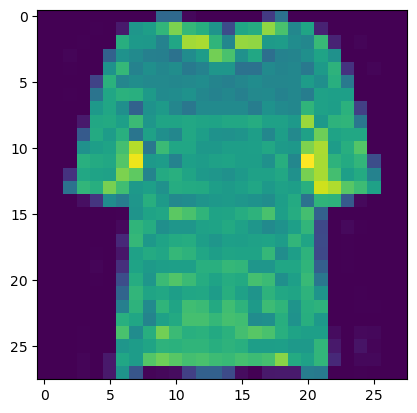

Predicted: Pullover Actual: Shirt


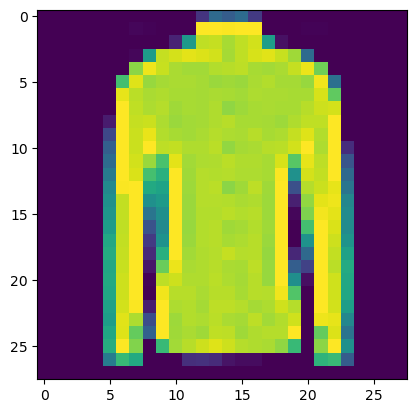

Predicted: Shirt Actual: T-shirt/top


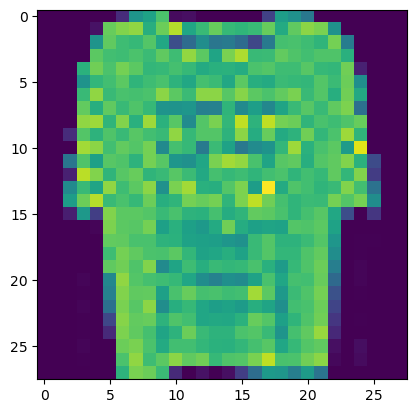

Predicted: Coat Actual: Shirt


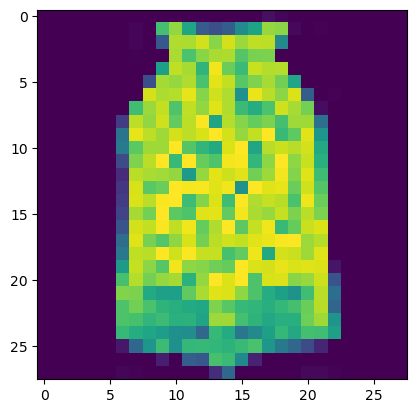

Predicted: Coat Actual: Pullover


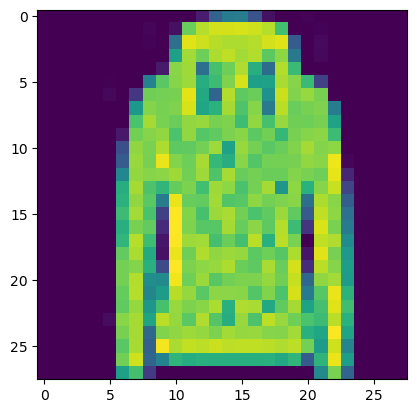

Predicted: Ankle boot Actual: Sneaker


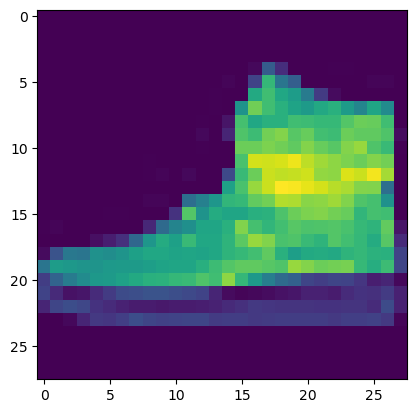

Predicted: Shirt Actual: Dress


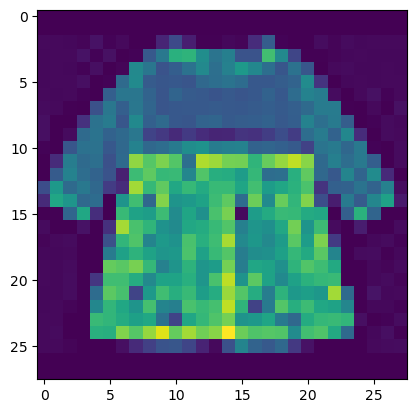

Predicted: Coat Actual: Pullover


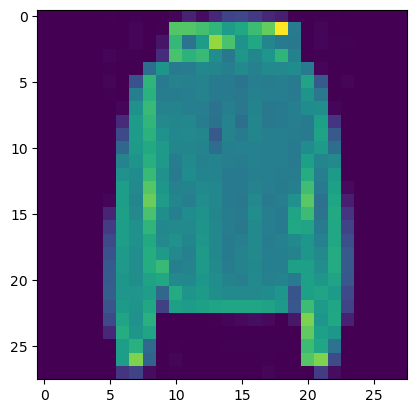

Predicted: Shirt Actual: Coat


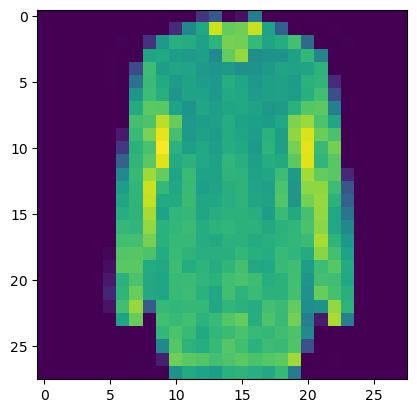

Predicted: T-shirt/top Actual: Dress


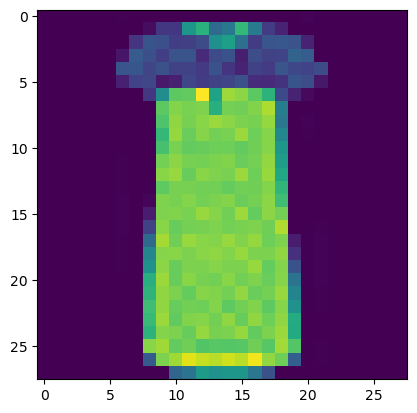

Predicted: Dress Actual: Coat


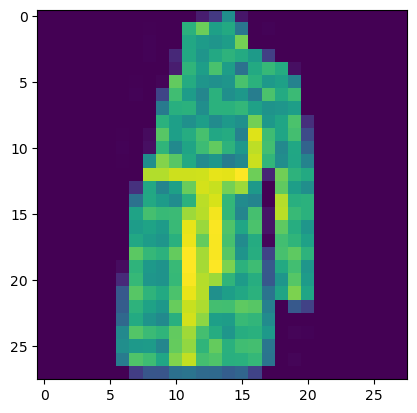

Predicted: Shirt Actual: Coat


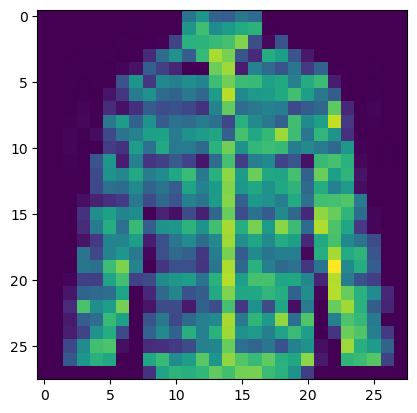

Predicted: T-shirt/top Actual: Shirt


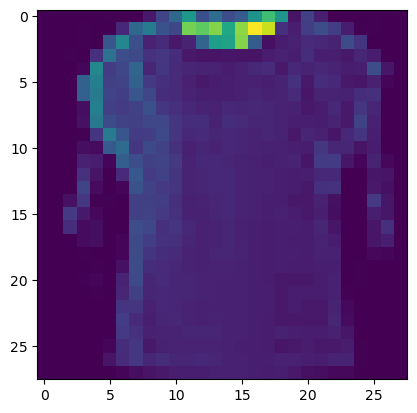

Predicted: Shirt Actual: Pullover


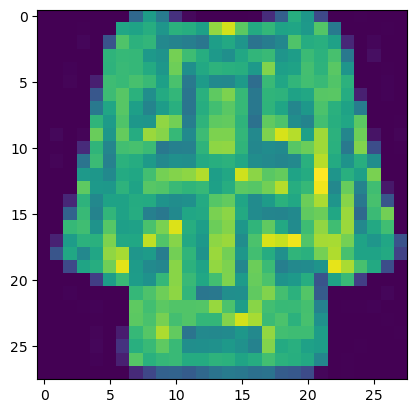

Predicted: T-shirt/top Actual: Dress


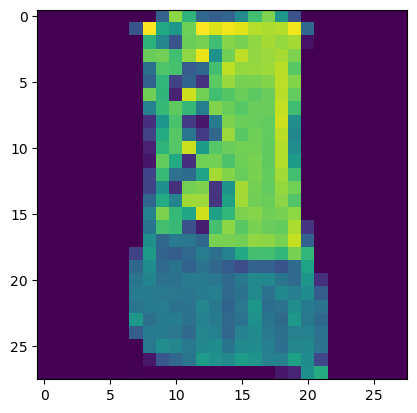

Predicted: Pullover Actual: Coat


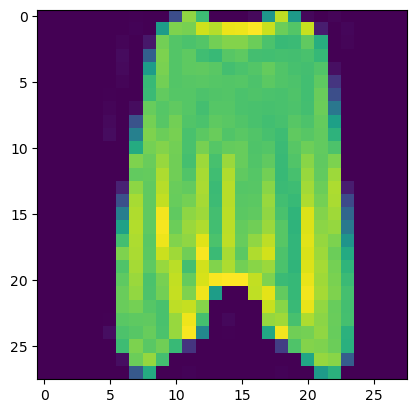

Predicted: T-shirt/top Actual: Shirt


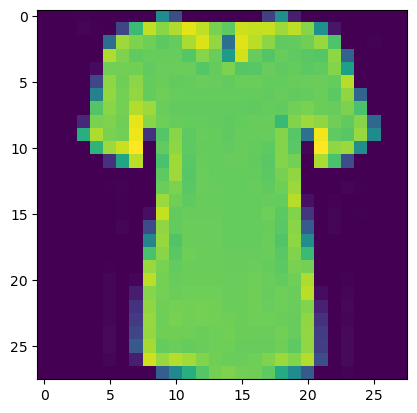

Predicted: Coat Actual: Shirt


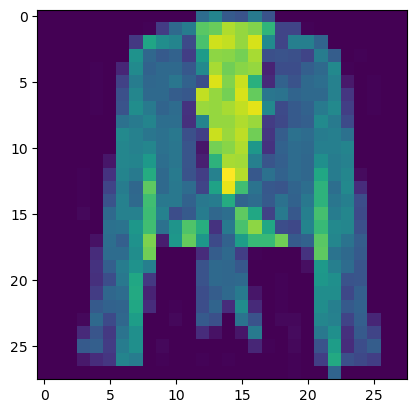

Predicted: Dress Actual: Shirt


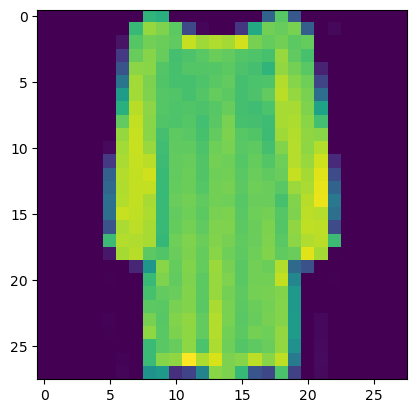

Predicted: T-shirt/top Actual: Shirt


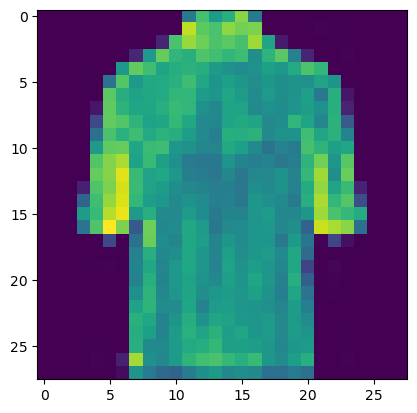

Predicted: Coat Actual: Dress


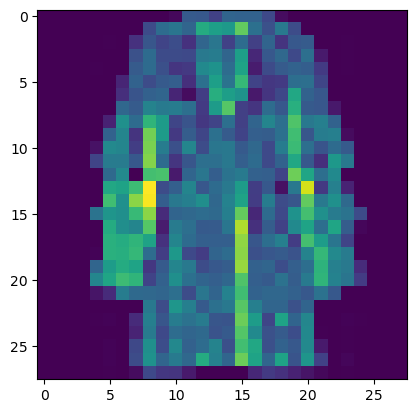

Predicted: Shirt Actual: T-shirt/top


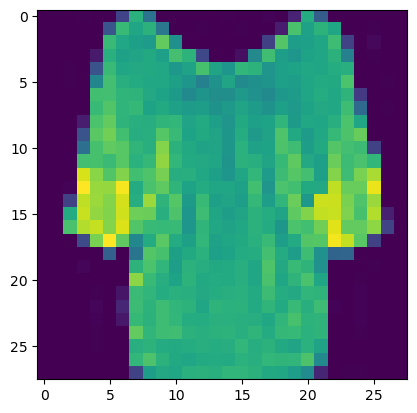

Predicted: Coat Actual: Shirt


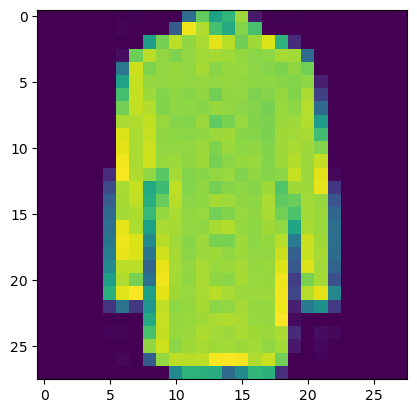

Predicted: Dress Actual: Shirt


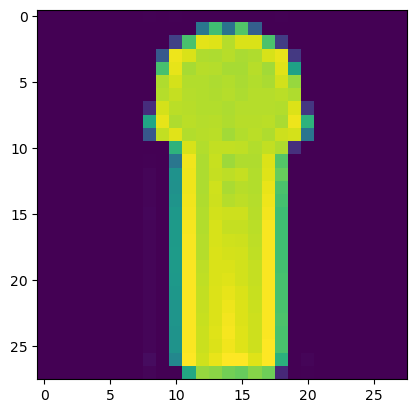

Predicted: Pullover Actual: Coat


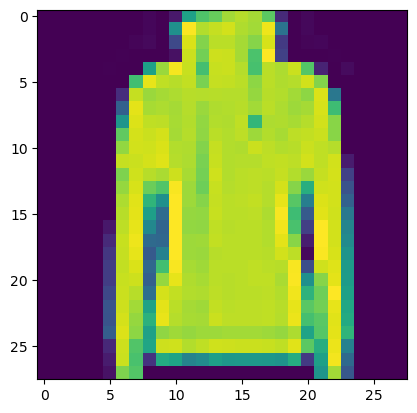

Predicted: Dress Actual: Shirt


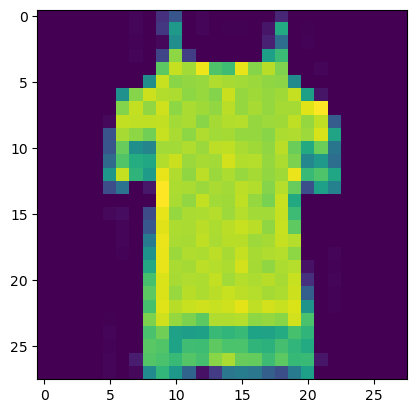

Predicted: T-shirt/top Actual: Dress


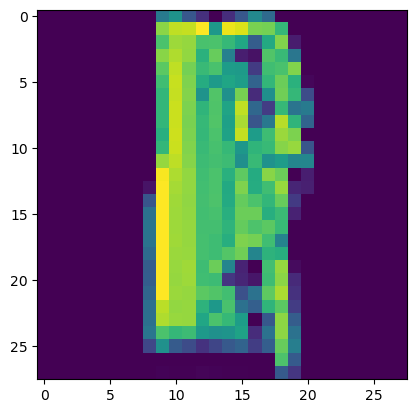

Predicted: Shirt Actual: T-shirt/top


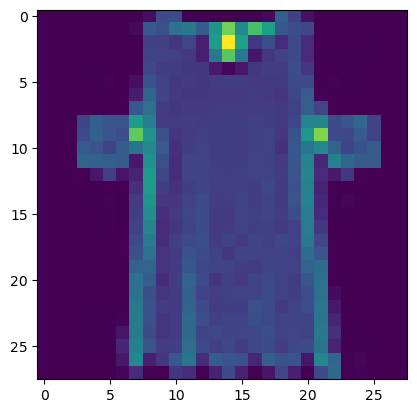

Predicted: Shirt Actual: T-shirt/top


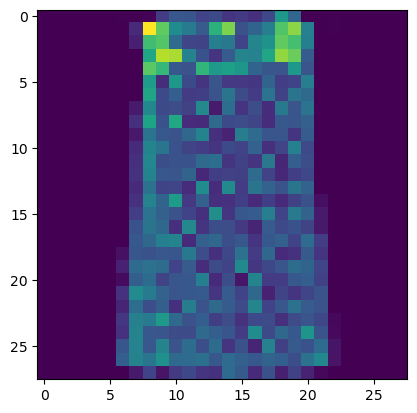

Predicted: Dress Actual: Pullover


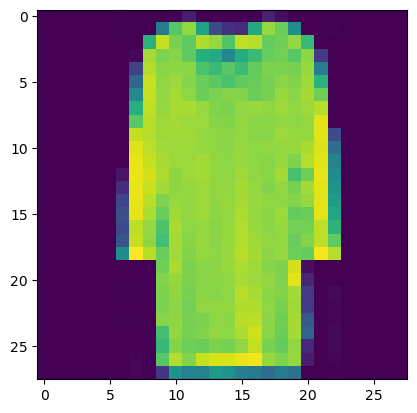

Predicted: T-shirt/top Actual: Shirt


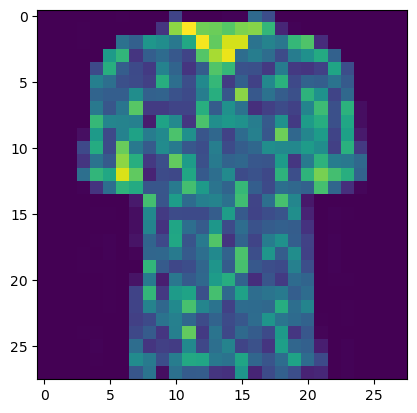

Predicted: Coat Actual: Pullover


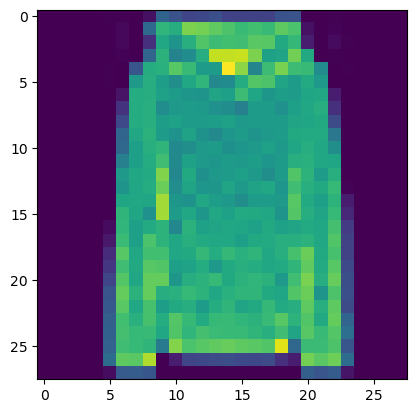

Predicted: Sandal Actual: Ankle boot


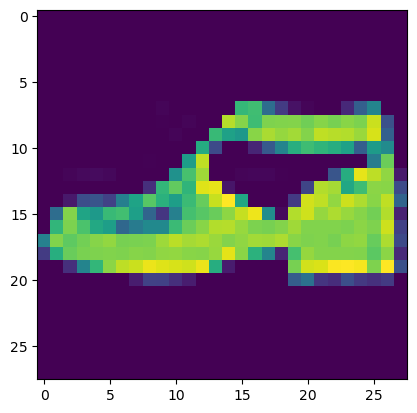

Predicted: Coat Actual: Shirt


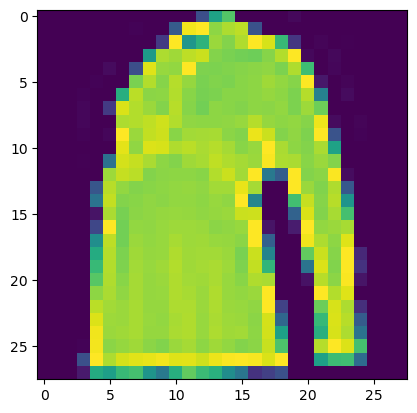

Predicted: Dress Actual: Trouser


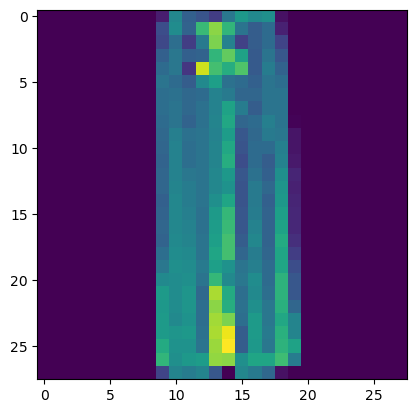

Predicted: Dress Actual: T-shirt/top


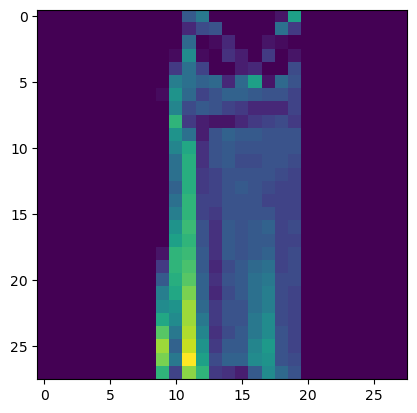

Predicted: Shirt Actual: Trouser


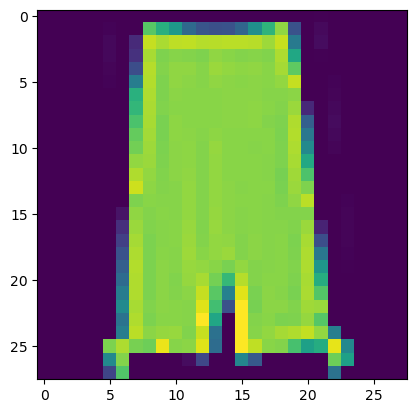

Predicted: Coat Actual: Pullover


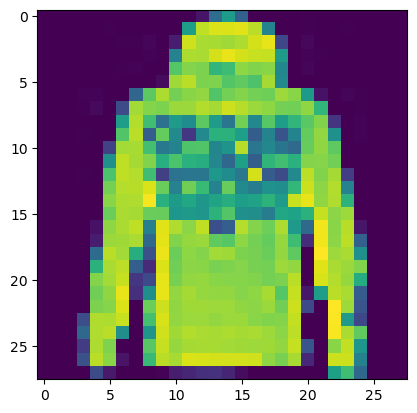

Predicted: Sneaker Actual: Ankle boot


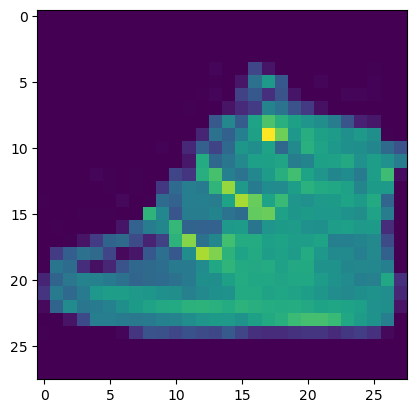

Predicted: T-shirt/top Actual: Shirt


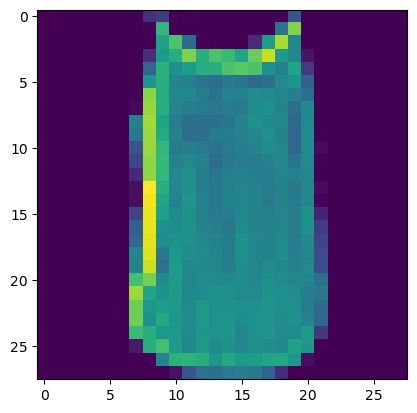

Predicted: T-shirt/top Actual: Shirt


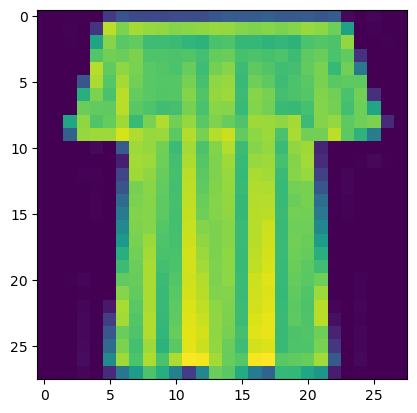

Predicted: Shirt Actual: T-shirt/top


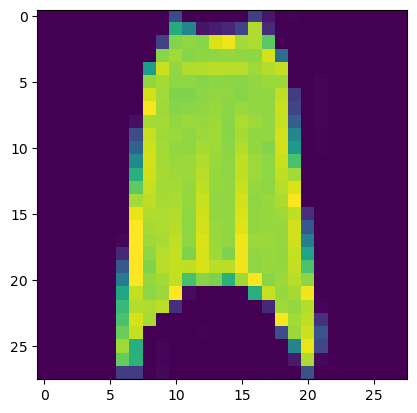

Predicted: T-shirt/top Actual: Pullover


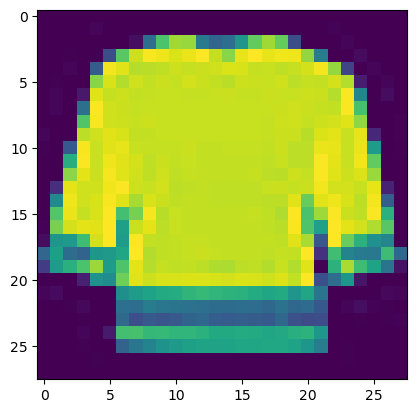

Predicted: T-shirt/top Actual: Shirt


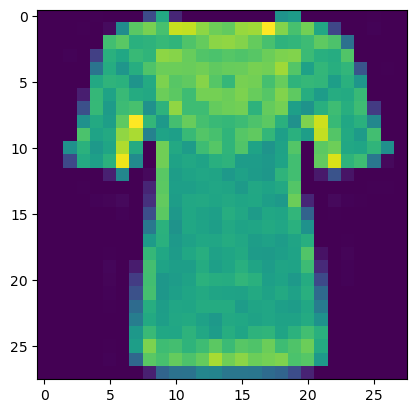

Predicted: Shirt Actual: Coat


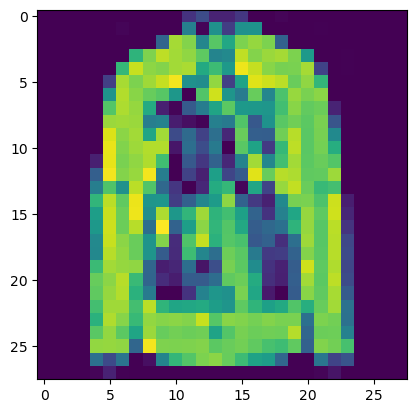

Predicted: Pullover Actual: Dress


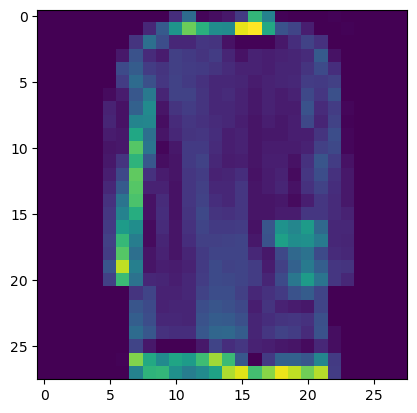

Predicted: Shirt Actual: Coat


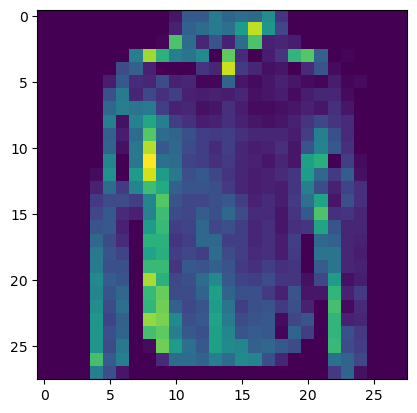

Predicted: Dress Actual: Trouser


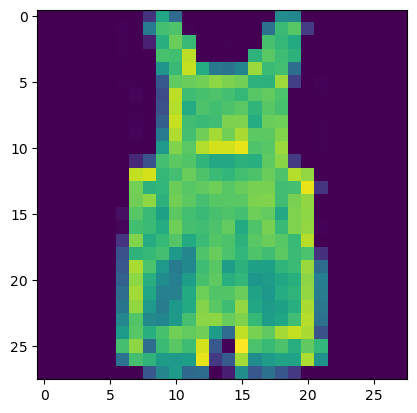

Predicted: Shirt Actual: T-shirt/top


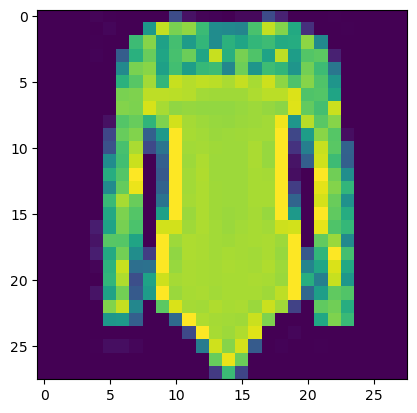

Predicted: Coat Actual: Pullover


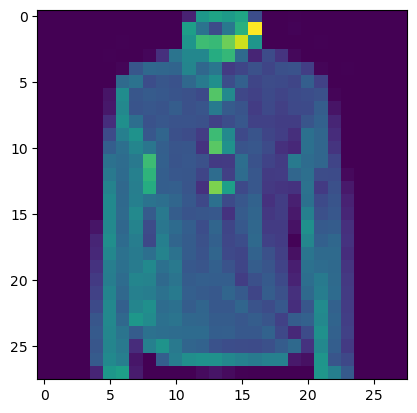

Predicted: Coat Actual: Shirt


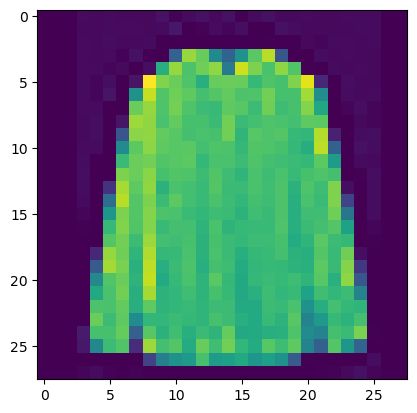

Predicted: Dress Actual: Trouser


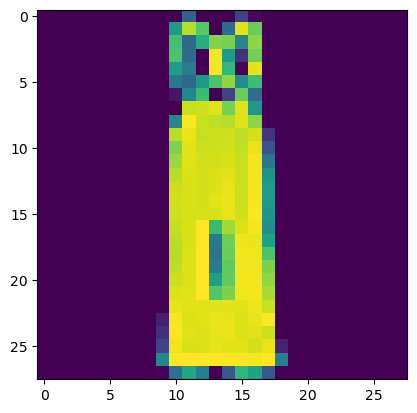

Predicted: Pullover Actual: Coat


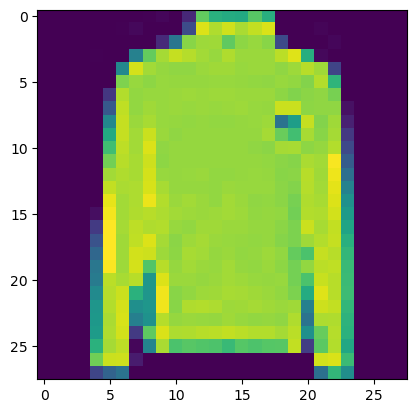

Predicted: Sneaker Actual: Sandal


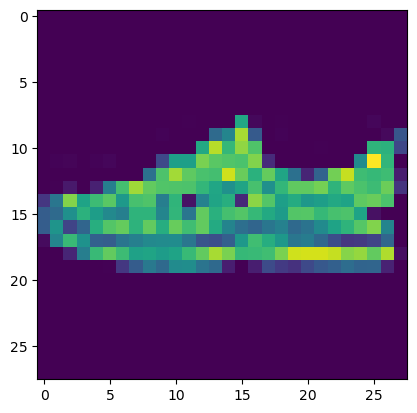

Predicted: Shirt Actual: Dress


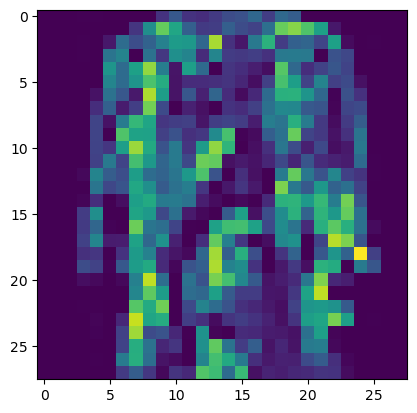

Predicted: T-shirt/top Actual: Shirt


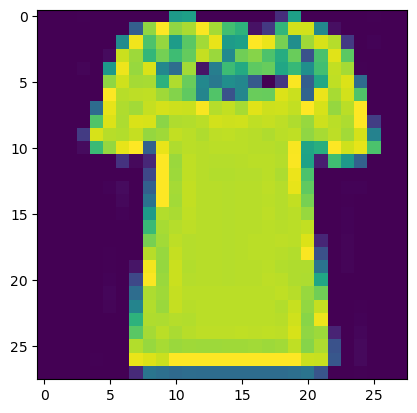

Predicted: Sneaker Actual: Ankle boot


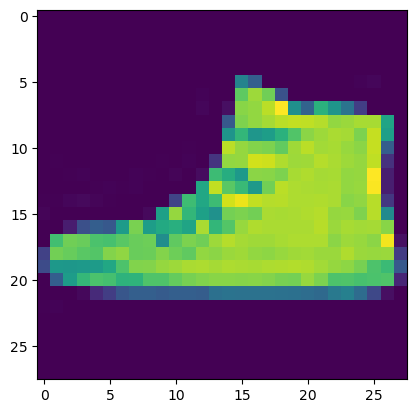

Predicted: T-shirt/top Actual: Pullover


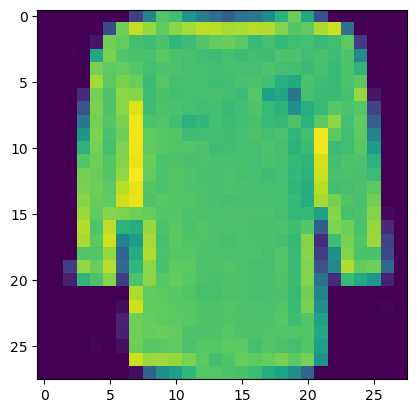

Predicted: Shirt Actual: T-shirt/top


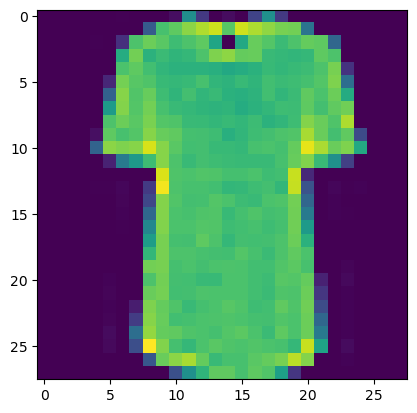

Predicted: Sneaker Actual: Ankle boot


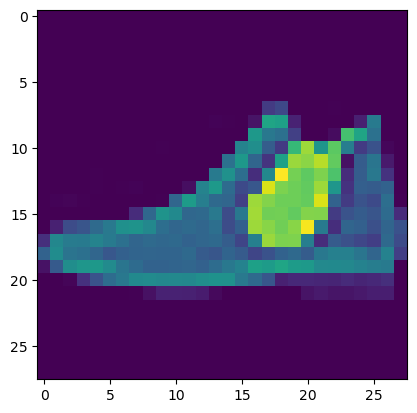

Predicted: T-shirt/top Actual: Shirt


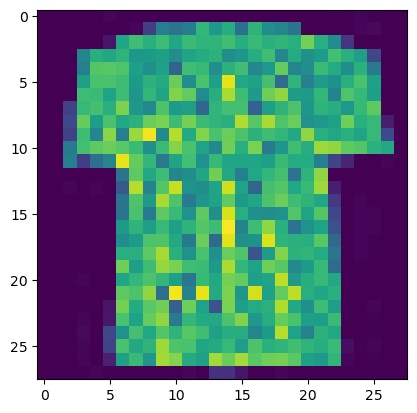

Predicted: Shirt Actual: T-shirt/top


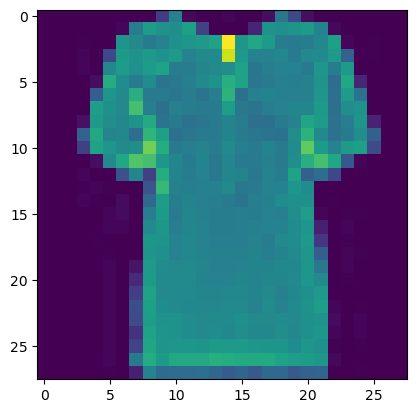

Predicted: Shirt Actual: T-shirt/top


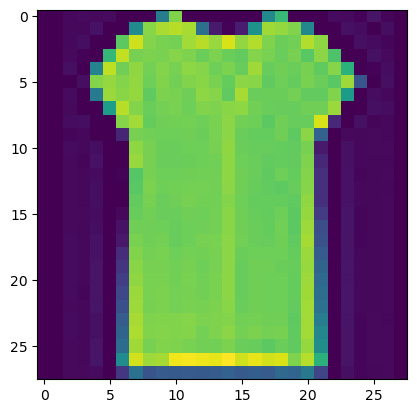

Predicted: Pullover Actual: Shirt


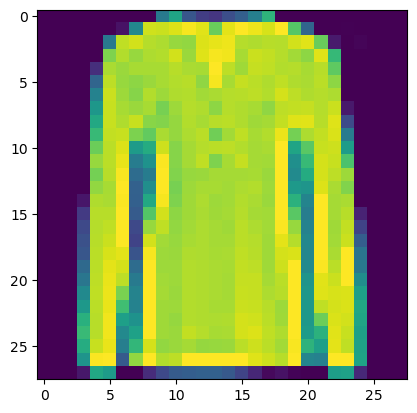

Predicted: Ankle boot Actual: Sneaker


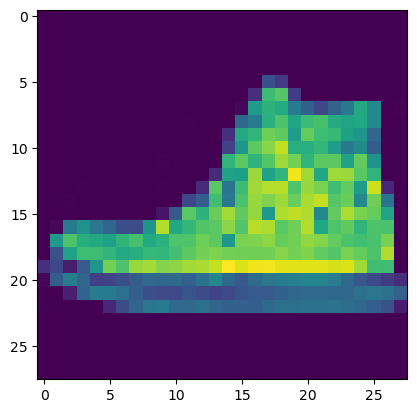

Predicted: Sneaker Actual: Ankle boot


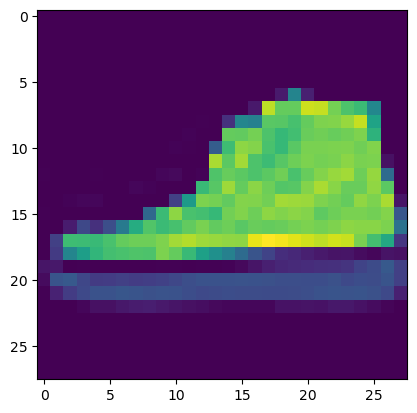

Predicted: Shirt Actual: T-shirt/top


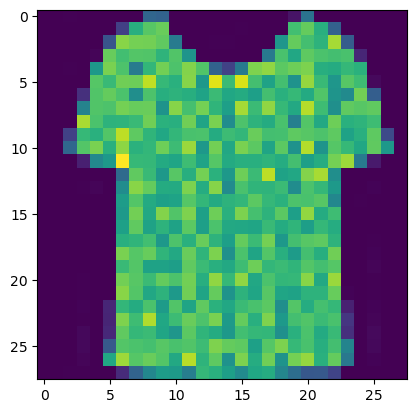

Predicted: Shirt Actual: Pullover


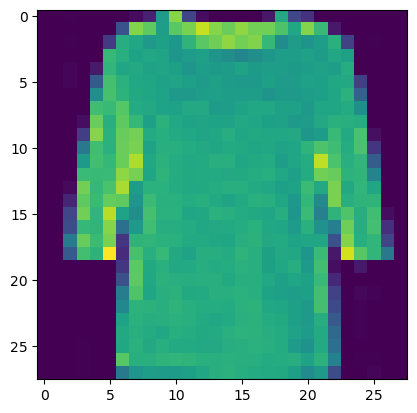

Predicted: Shirt Actual: T-shirt/top


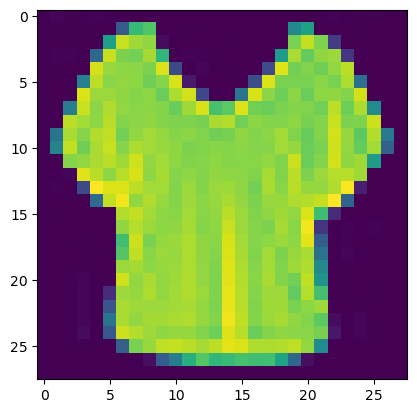

Predicted: Shirt Actual: Coat


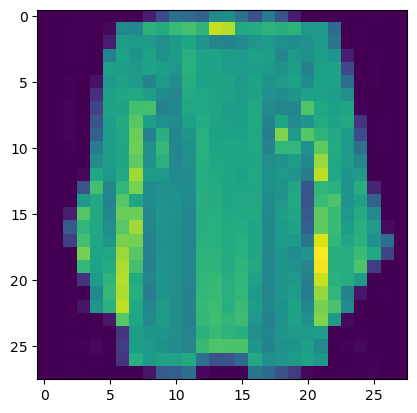

Predicted: Pullover Actual: Shirt


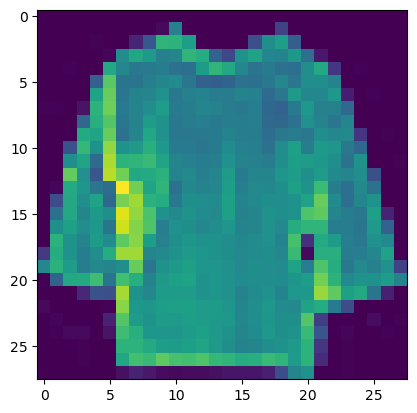

Predicted: Dress Actual: Shirt


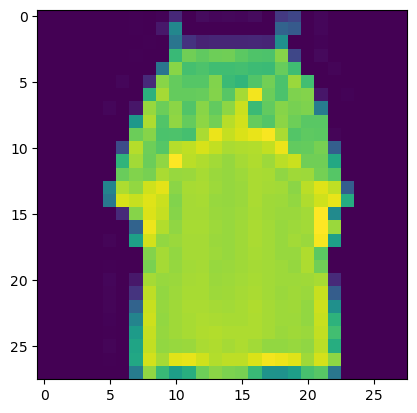

Predicted: Pullover Actual: Shirt


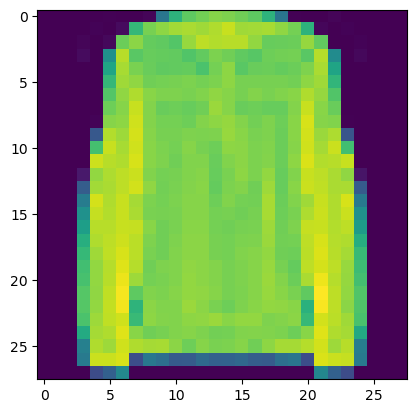

Predicted: Shirt Actual: T-shirt/top


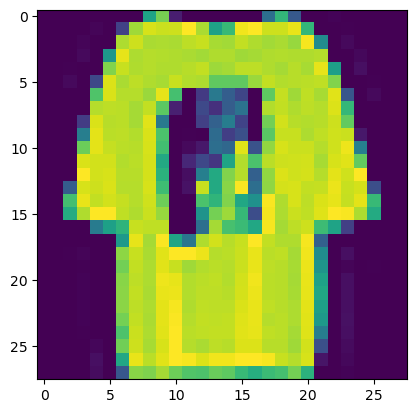

Predicted: Coat Actual: Shirt


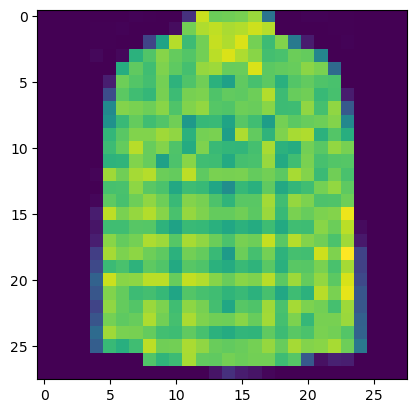

Predicted: T-shirt/top Actual: Shirt


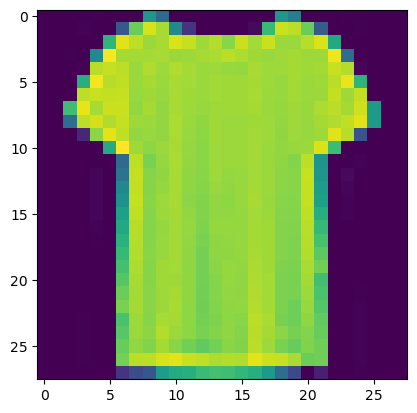

Predicted: Bag Actual: Shirt


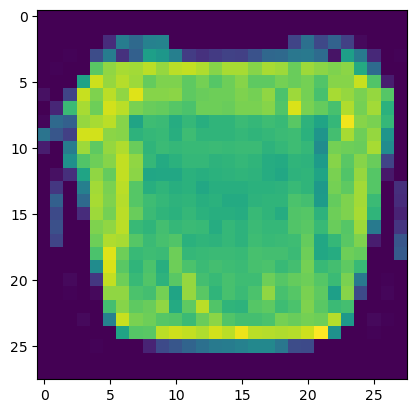

Predicted: Shirt Actual: Coat


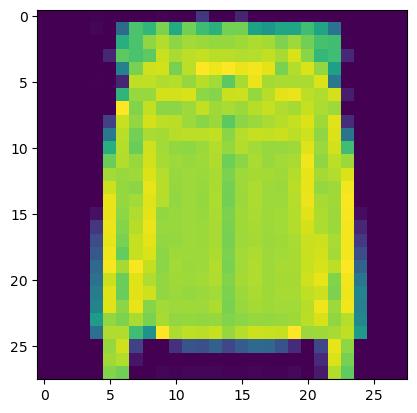

Predicted: Shirt Actual: T-shirt/top


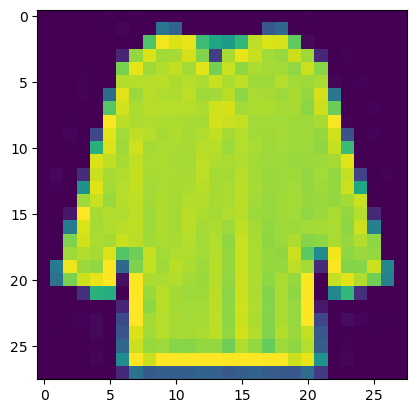

Predicted: Dress Actual: Coat


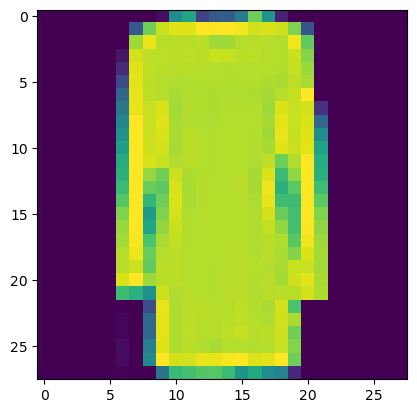

Predicted: Coat Actual: Pullover


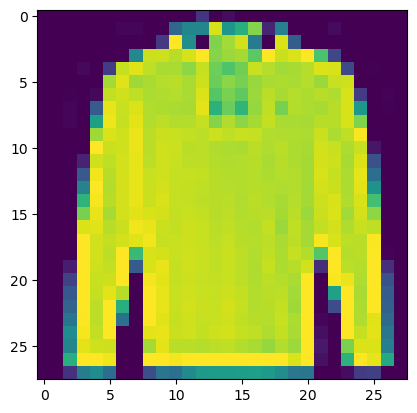

Predicted: Coat Actual: Shirt


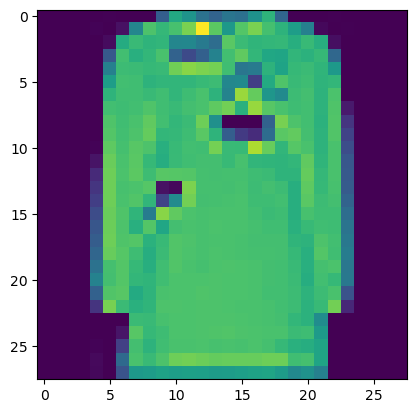

Predicted: Pullover Actual: T-shirt/top


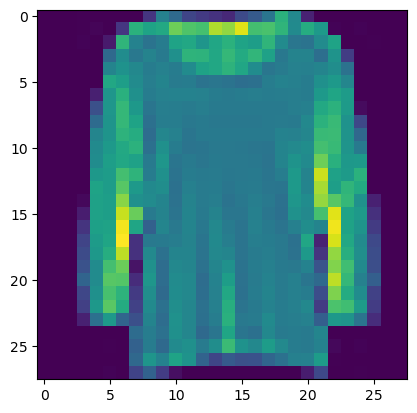

Predicted: T-shirt/top Actual: Shirt


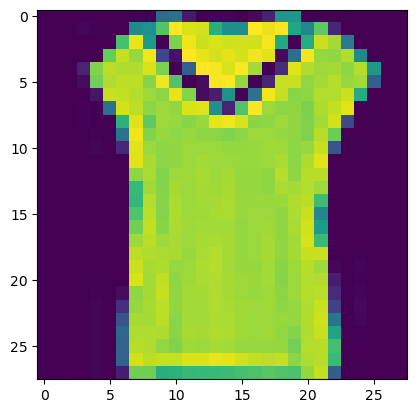

Predicted: Pullover Actual: Coat


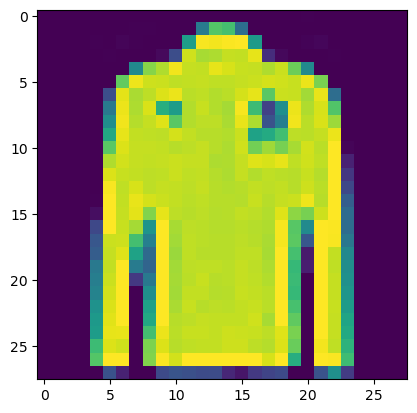

Predicted: T-shirt/top Actual: Shirt


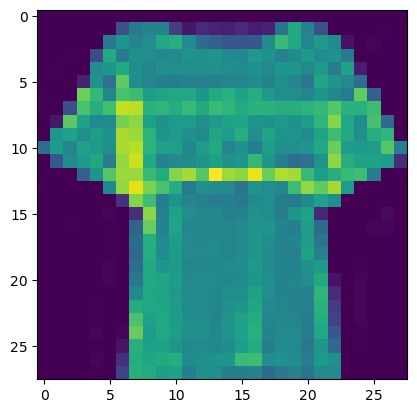

Predicted: Dress Actual: Trouser


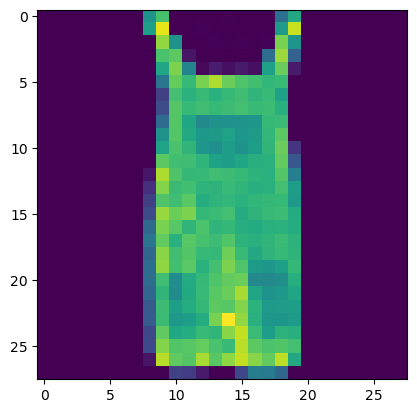

Predicted: Shirt Actual: T-shirt/top


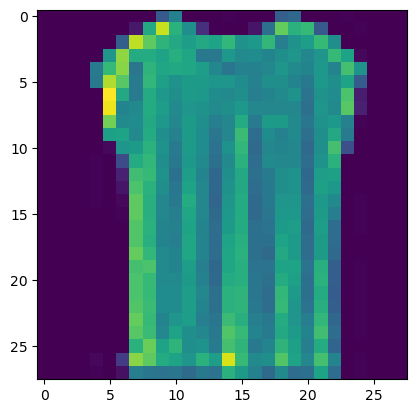

Predicted: Sandal Actual: Ankle boot


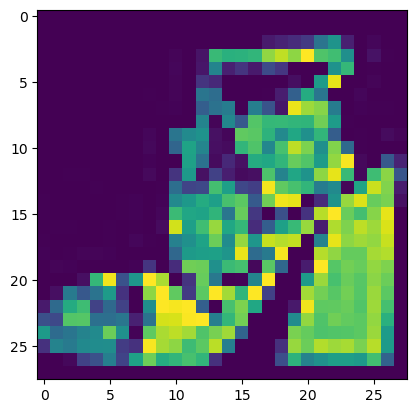

Predicted: T-shirt/top Actual: Shirt


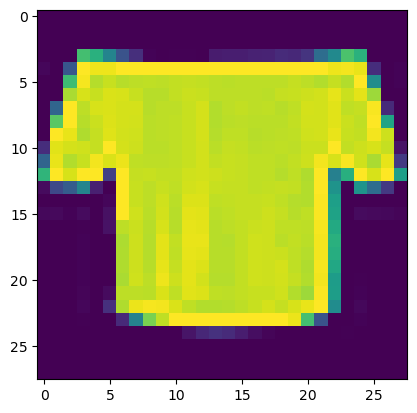

Predicted: Shirt Actual: Pullover


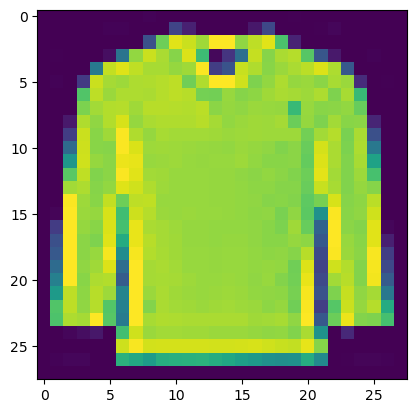

Predicted: Shirt Actual: Pullover


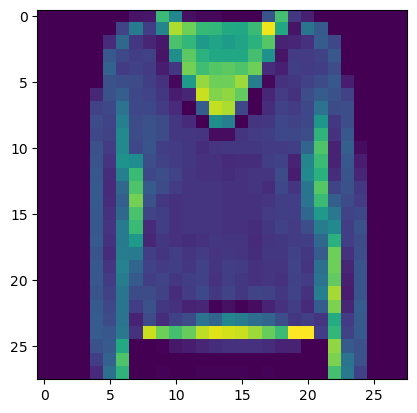

Predicted: T-shirt/top Actual: Shirt


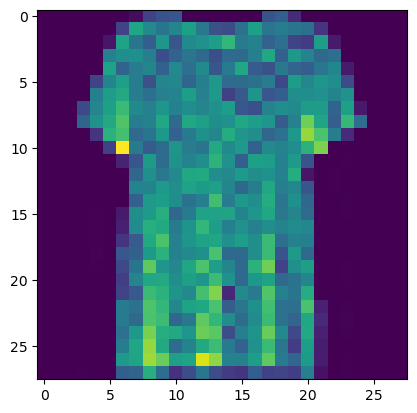

Predicted: Pullover Actual: Shirt


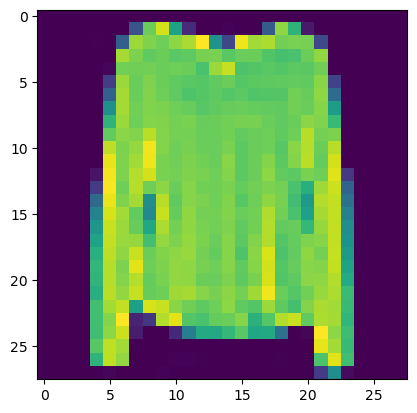

Predicted: T-shirt/top Actual: Shirt


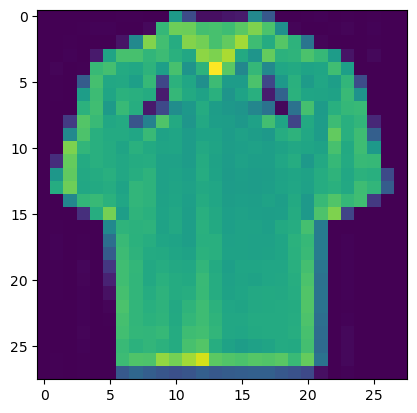

Predicted: Coat Actual: Pullover


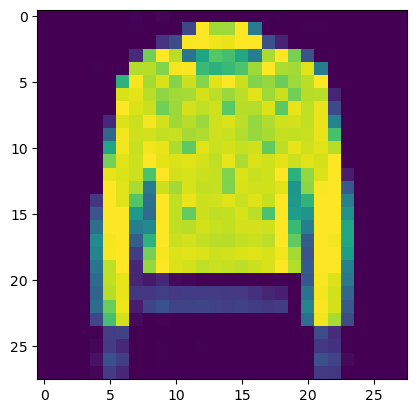

Predicted: Dress Actual: Coat


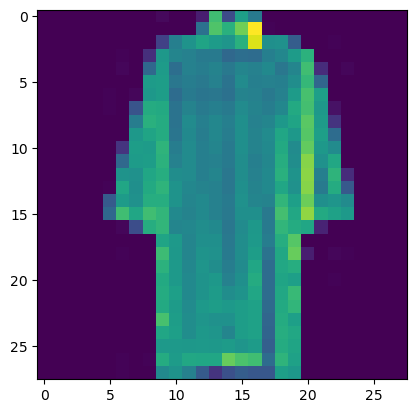

Predicted: Coat Actual: Shirt


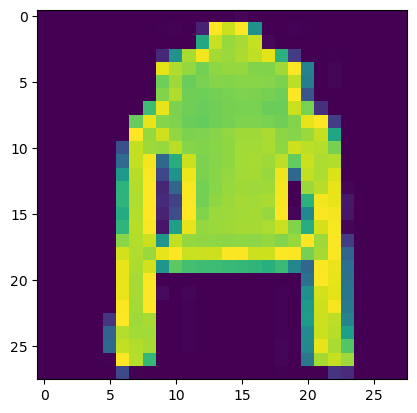

Predicted: Coat Actual: Shirt


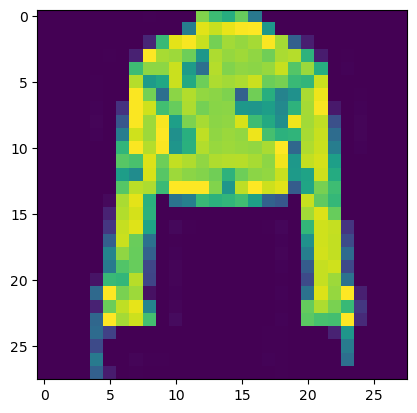

Predicted: Bag Actual: T-shirt/top


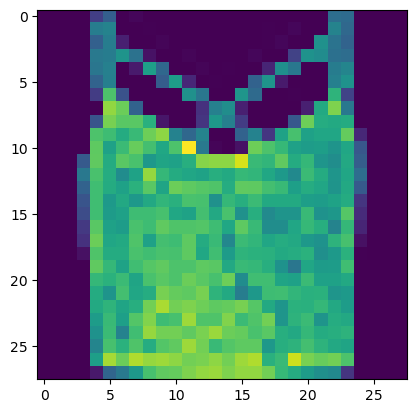

Predicted: T-shirt/top Actual: Shirt


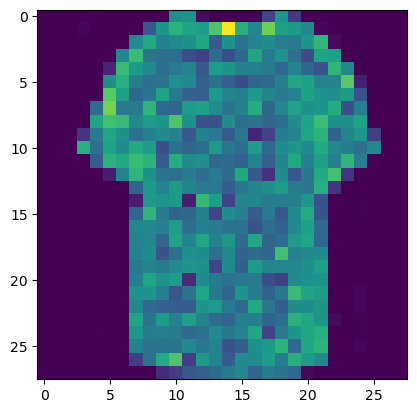

Predicted: Coat Actual: Dress


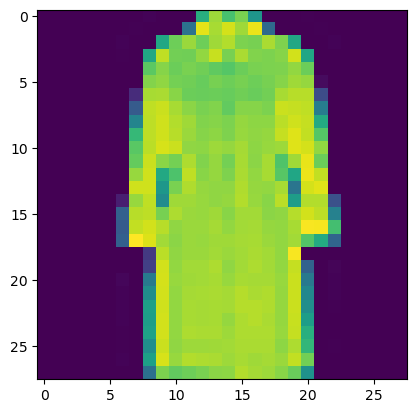

Predicted: Coat Actual: Shirt


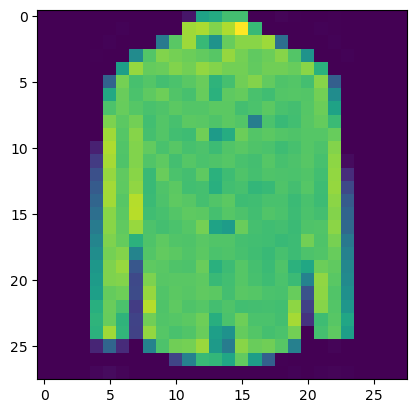

Predicted: Sneaker Actual: Sandal


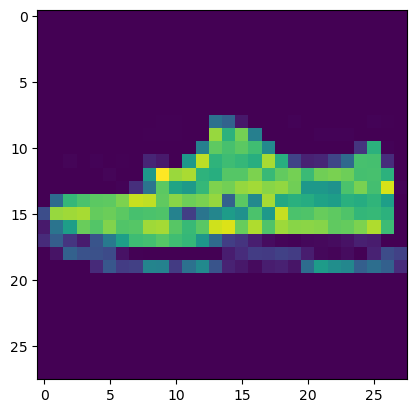

Predicted: Pullover Actual: Bag


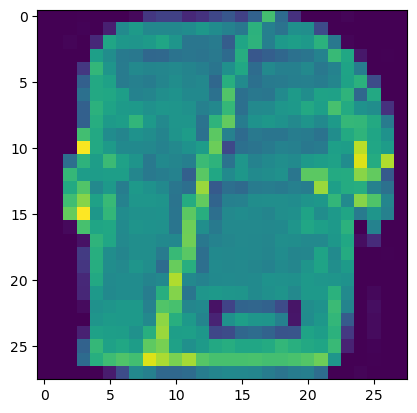

Predicted: Trouser Actual: Dress


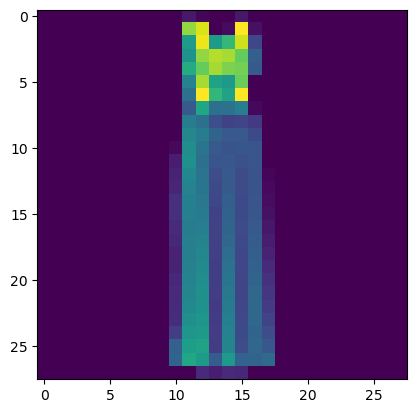

Predicted: T-shirt/top Actual: Shirt


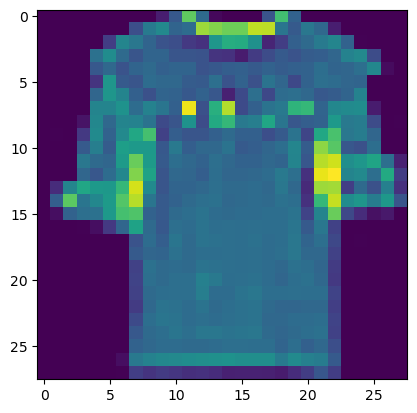

Predicted: Shirt Actual: Pullover


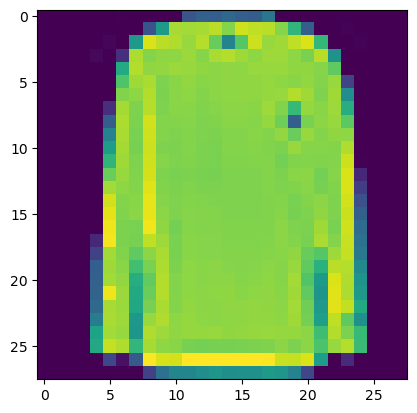

Predicted: Shirt Actual: Pullover


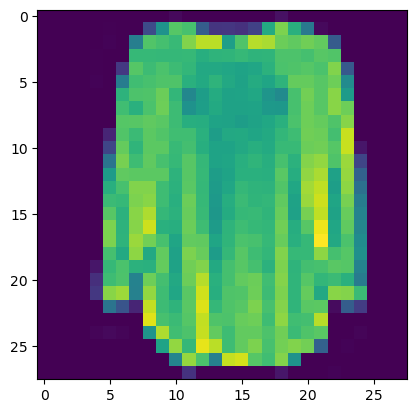

Predicted: Dress Actual: Shirt


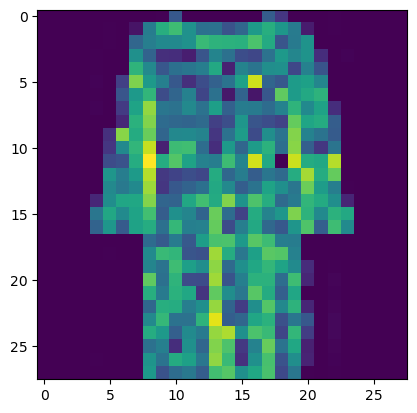

Predicted: Pullover Actual: Coat


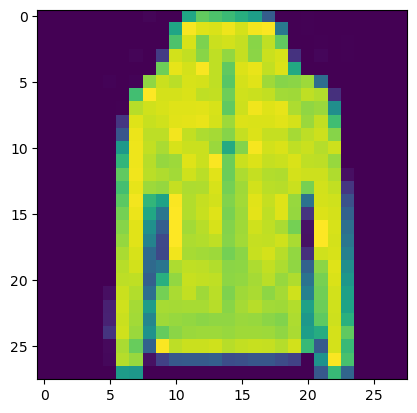

Predicted: Shirt Actual: T-shirt/top


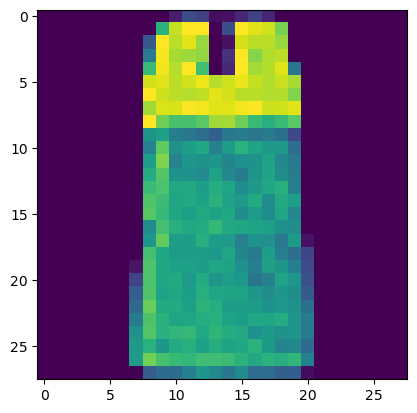

Predicted: T-shirt/top Actual: Shirt


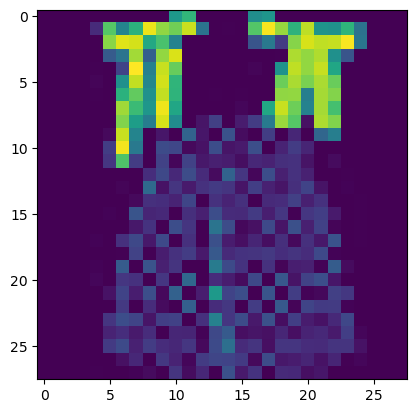

Predicted: Shirt Actual: Pullover


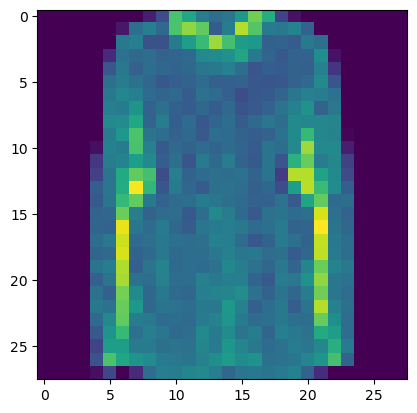

Predicted: Shirt Actual: T-shirt/top


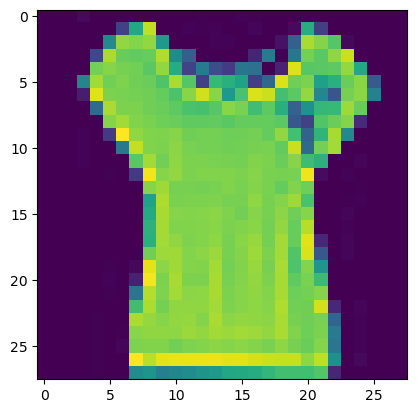

Predicted: Shirt Actual: T-shirt/top


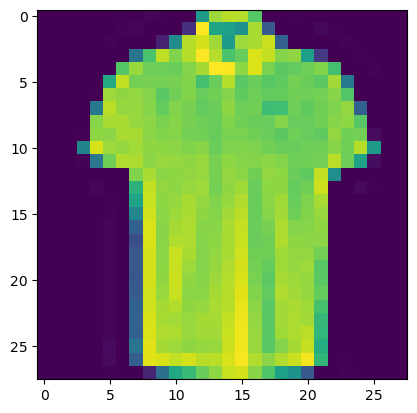

Predicted: Shirt Actual: Coat


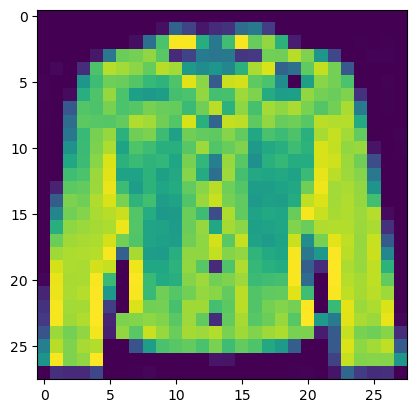

Predicted: Dress Actual: Bag


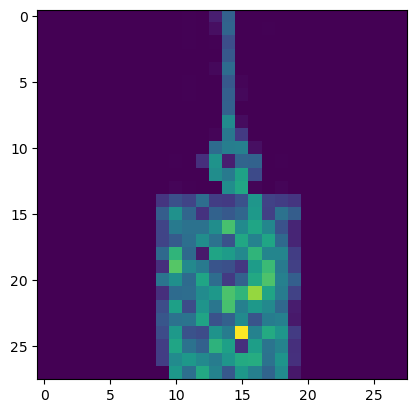

Predicted: Shirt Actual: T-shirt/top


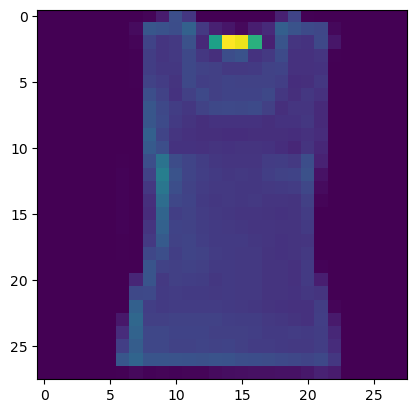

Predicted: Pullover Actual: Shirt


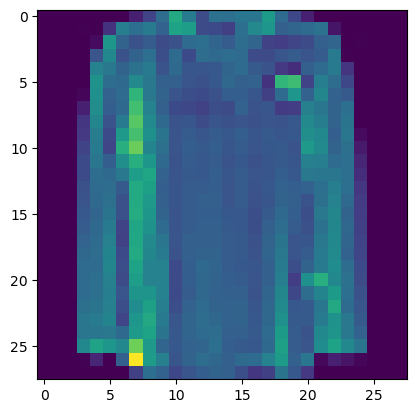

Predicted: T-shirt/top Actual: Shirt


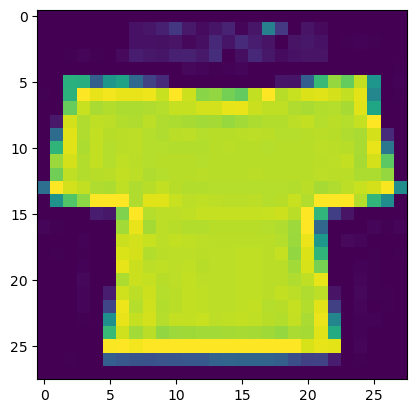

Predicted: Dress Actual: Coat


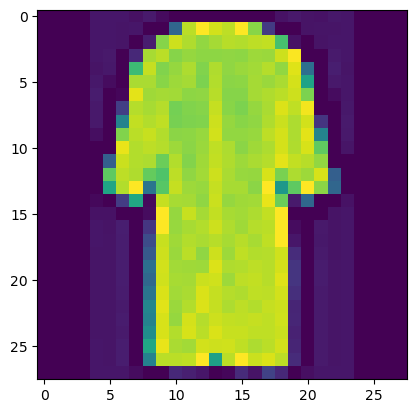

Predicted: T-shirt/top Actual: Shirt


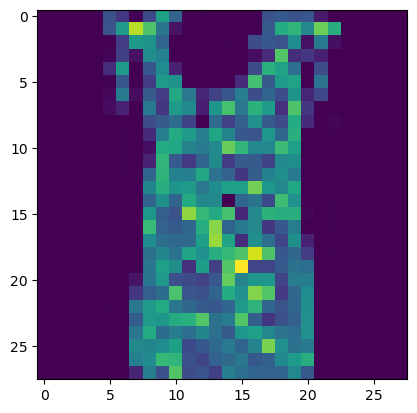

Predicted: Pullover Actual: Coat


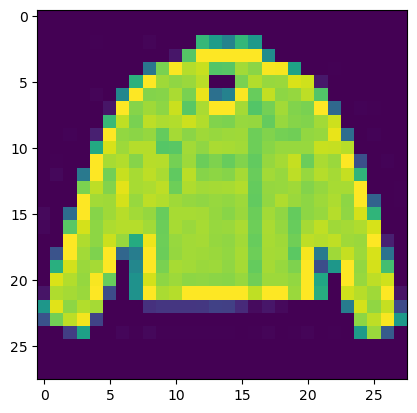

Predicted: T-shirt/top Actual: Shirt


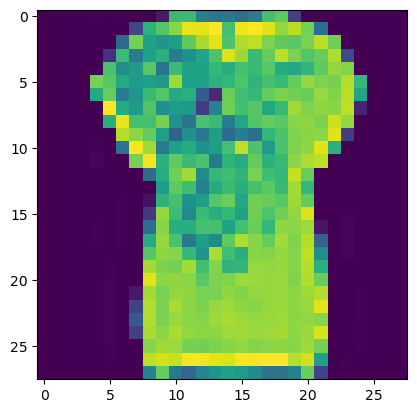

Predicted: Coat Actual: Dress


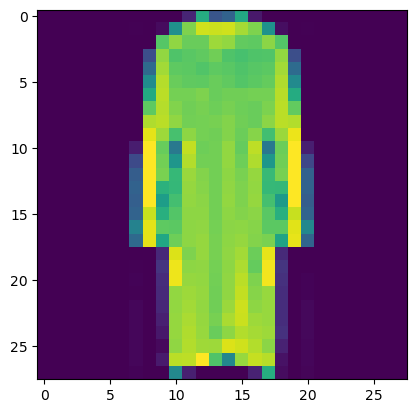

Predicted: Coat Actual: Pullover


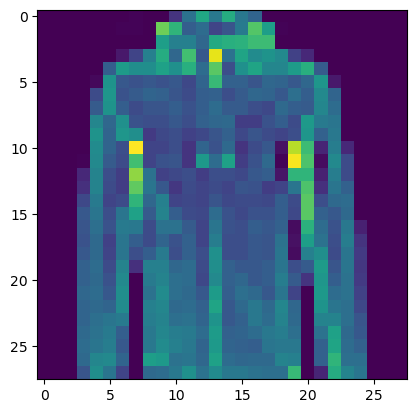

Predicted: Shirt Actual: T-shirt/top


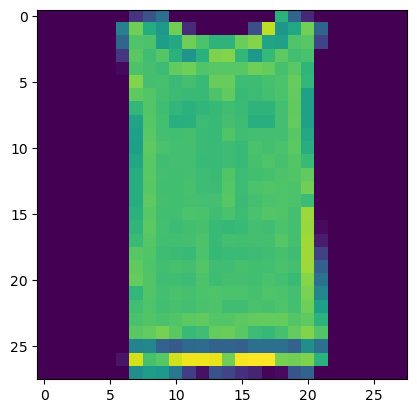

Predicted: Coat Actual: Shirt


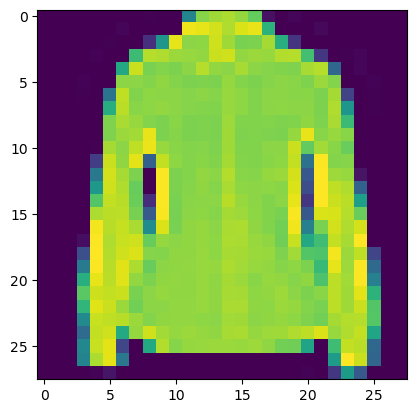

Predicted: Shirt Actual: T-shirt/top


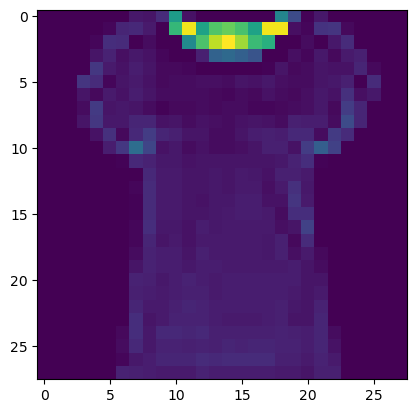

Predicted: Coat Actual: Dress


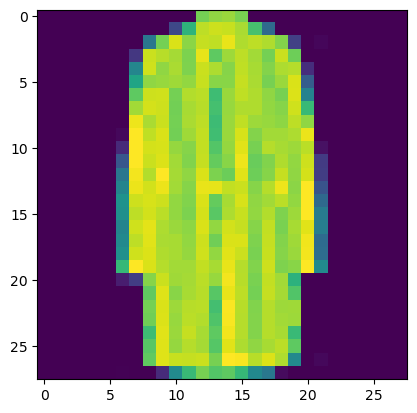

Predicted: T-shirt/top Actual: Shirt


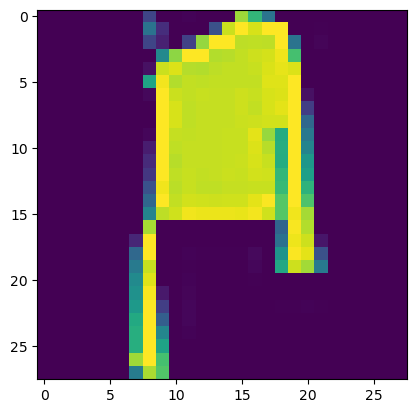

Predicted: T-shirt/top Actual: Shirt


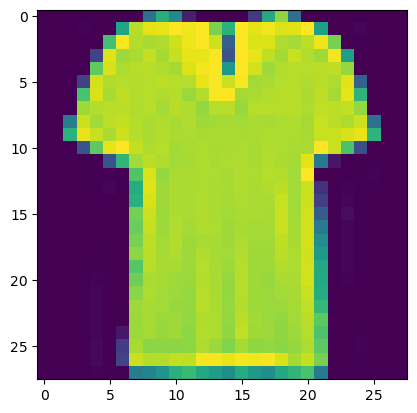

Predicted: Coat Actual: Shirt


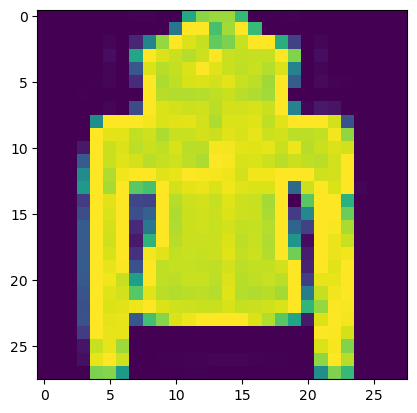

Predicted: Shirt Actual: Pullover


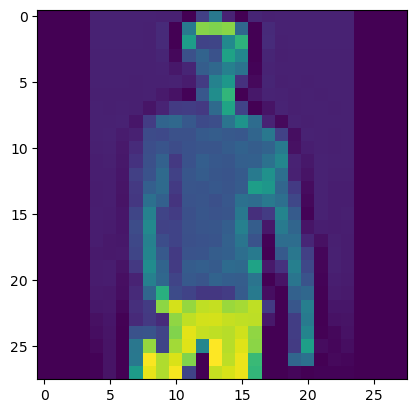

Predicted: Shirt Actual: Dress


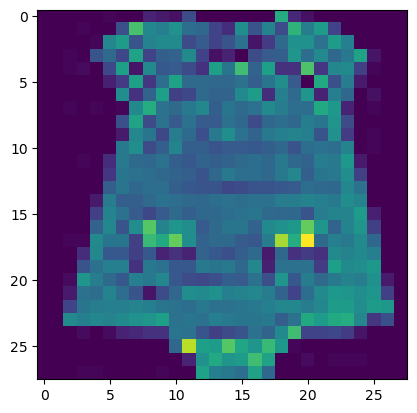

Predicted: Coat Actual: Dress


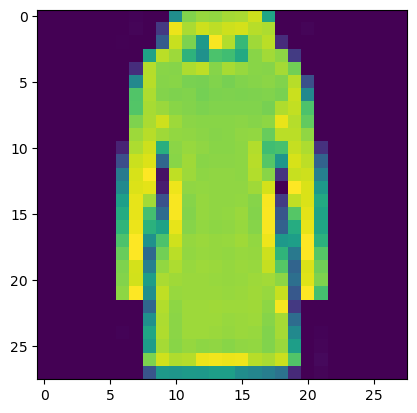

Predicted: T-shirt/top Actual: Dress


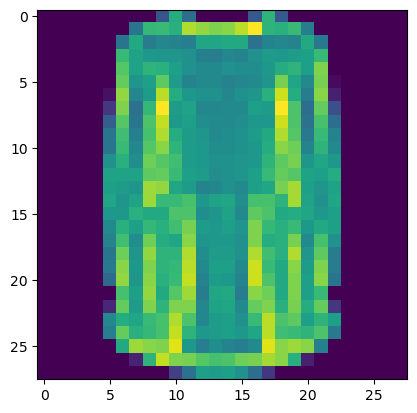

Predicted: T-shirt/top Actual: Shirt


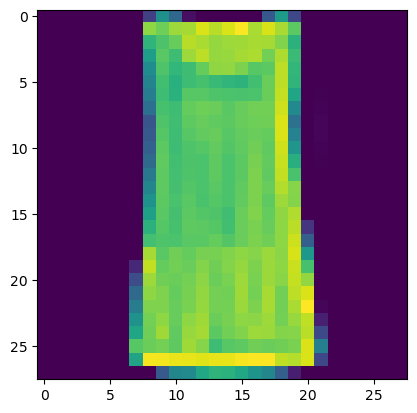

Predicted: Shirt Actual: Coat


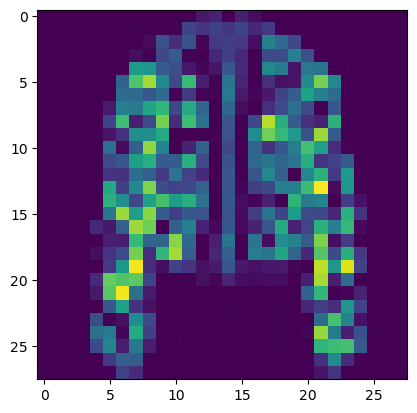

Predicted: Shirt Actual: Coat


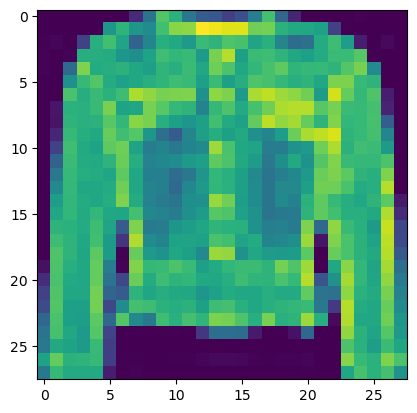

Predicted: Dress Actual: Shirt


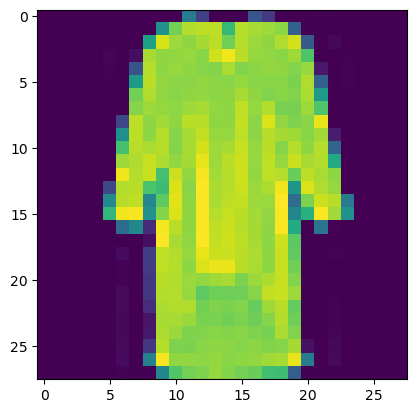

Predicted: Coat Actual: Shirt


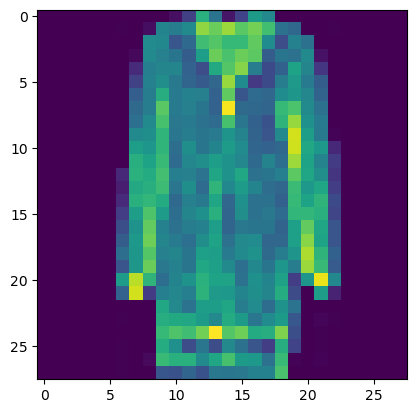

Predicted: T-shirt/top Actual: Pullover


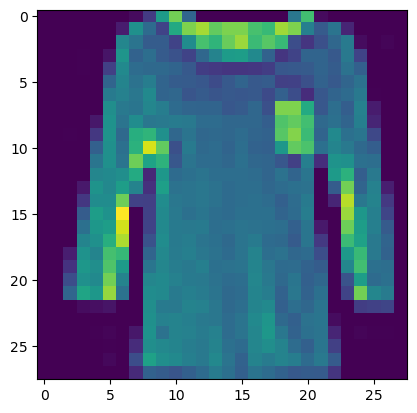

Predicted: T-shirt/top Actual: Bag


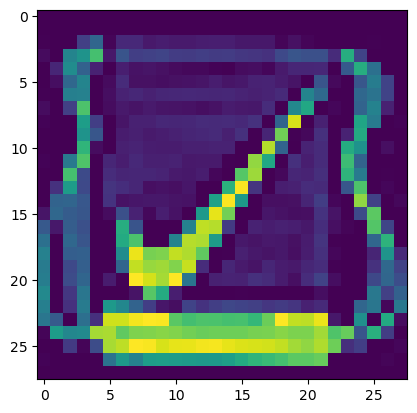

Predicted: Sneaker Actual: Ankle boot


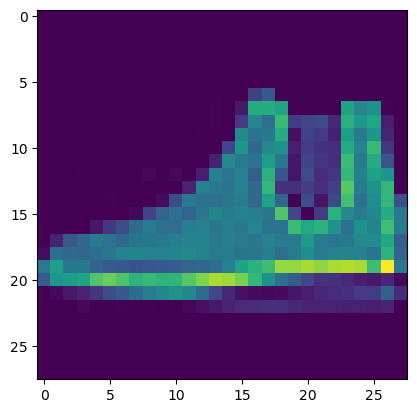

Predicted: T-shirt/top Actual: Shirt


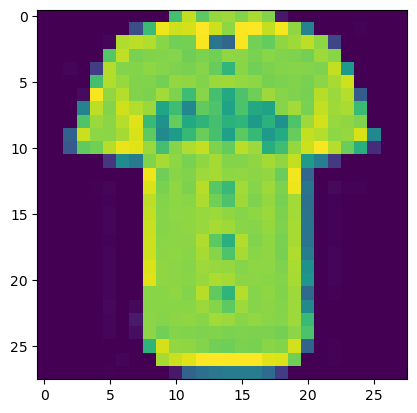

Predicted: Sneaker Actual: Sandal


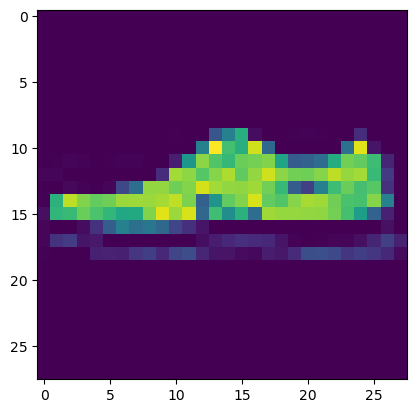

Predicted: T-shirt/top Actual: Shirt


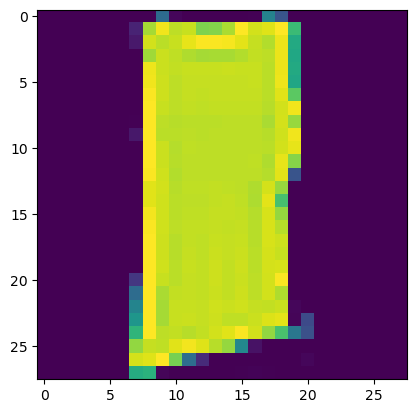

Predicted: T-shirt/top Actual: Shirt


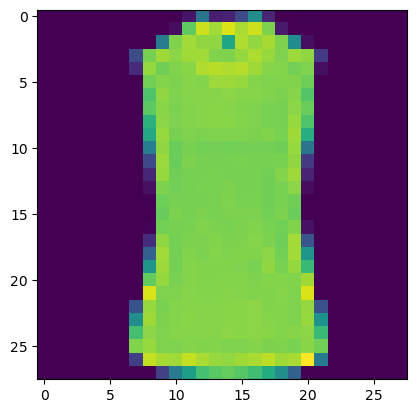

Predicted: Coat Actual: Shirt


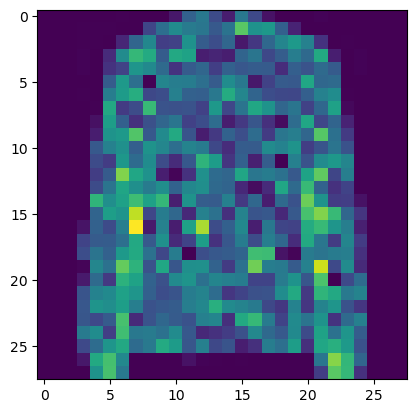

Predicted: Pullover Actual: Shirt


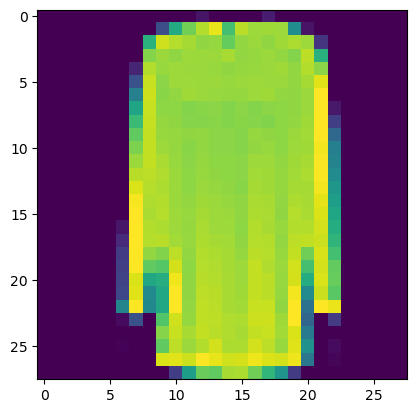

Predicted: T-shirt/top Actual: Shirt


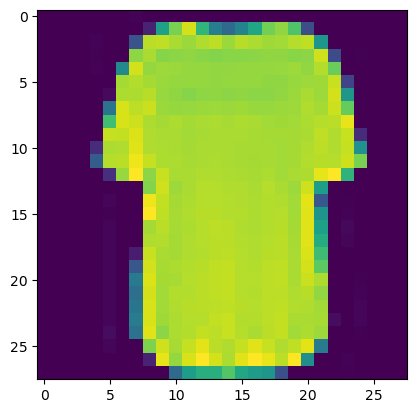

Predicted: Pullover Actual: Shirt


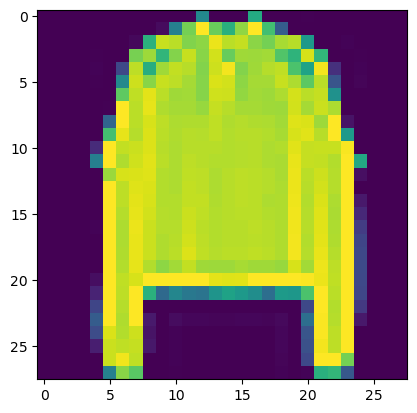

Predicted: Sandal Actual: Ankle boot


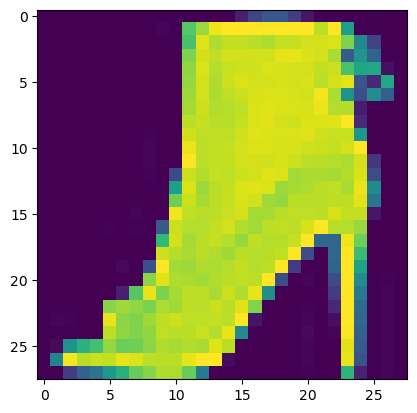

Predicted: Coat Actual: Dress


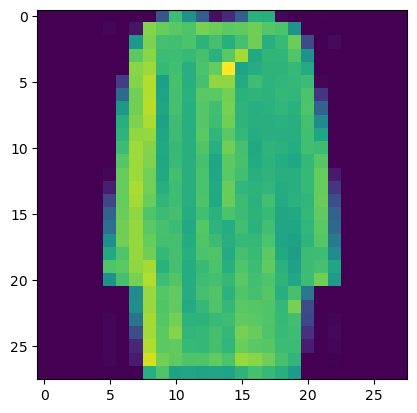

Predicted: Pullover Actual: Coat


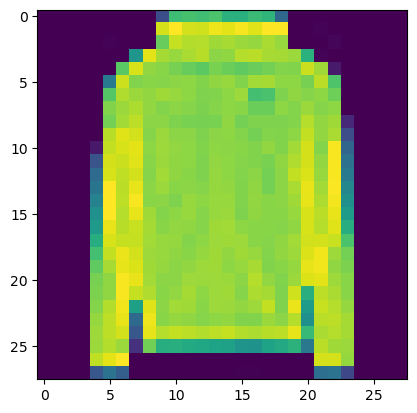

Predicted: Coat Actual: Pullover


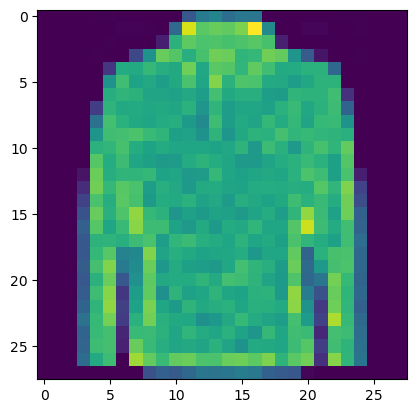

Predicted: Pullover Actual: Coat


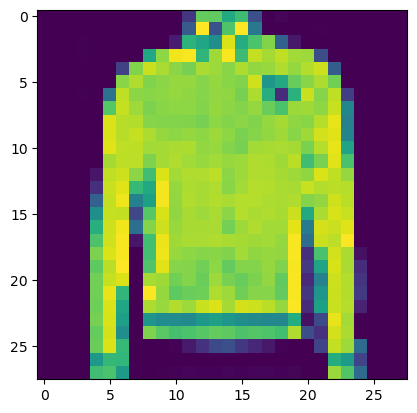

Predicted: Coat Actual: Pullover


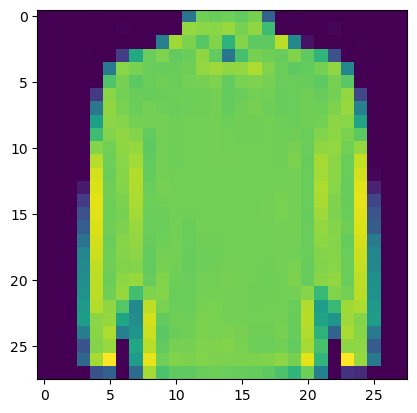

Predicted: Coat Actual: Pullover


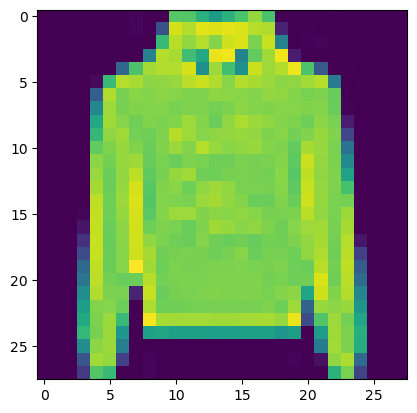

Predicted: Pullover Actual: T-shirt/top


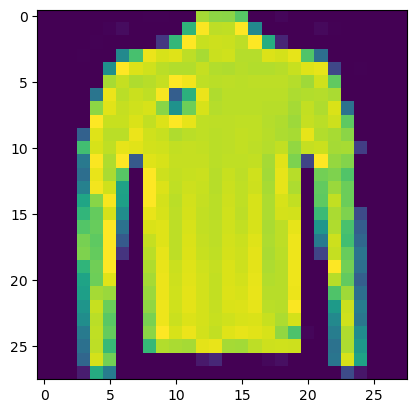

Predicted: Dress Actual: Trouser


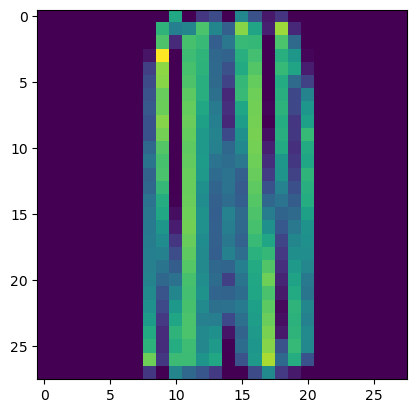

Predicted: T-shirt/top Actual: Shirt


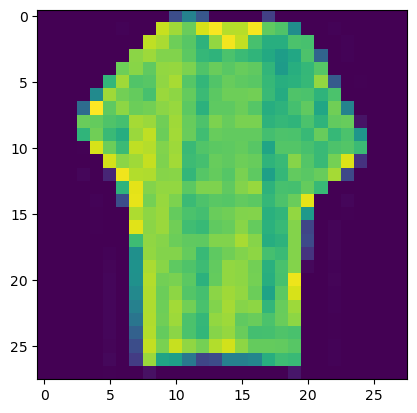

Predicted: Ankle boot Actual: Sneaker


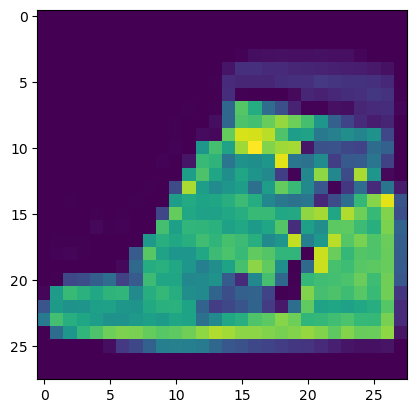

Predicted: Pullover Actual: Shirt


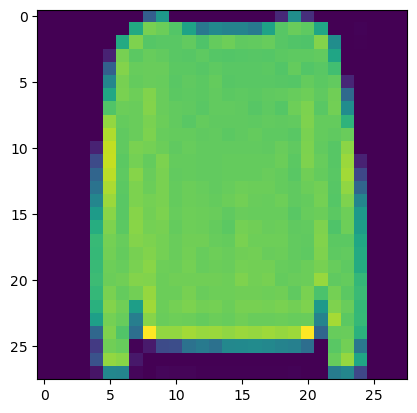

Predicted: Coat Actual: Pullover


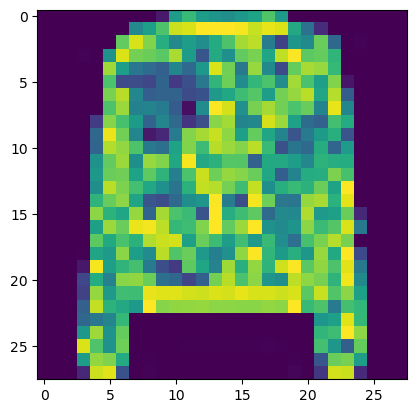

Predicted: T-shirt/top Actual: Dress


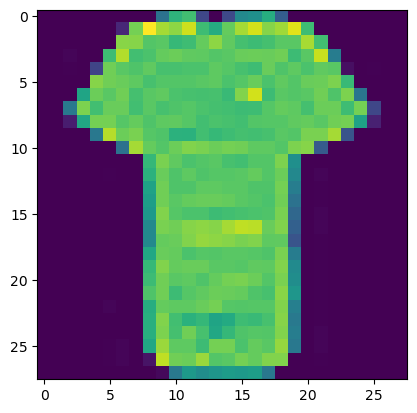

Predicted: Shirt Actual: Dress


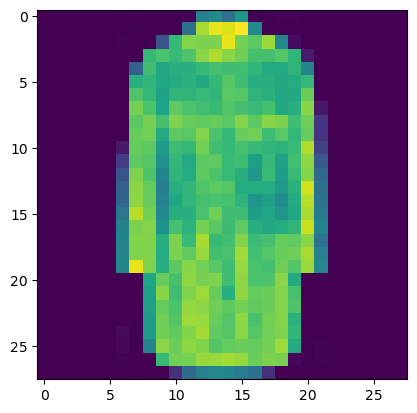

Predicted: Dress Actual: Coat


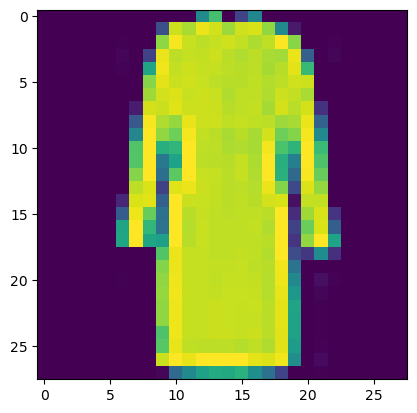

Predicted: Shirt Actual: T-shirt/top


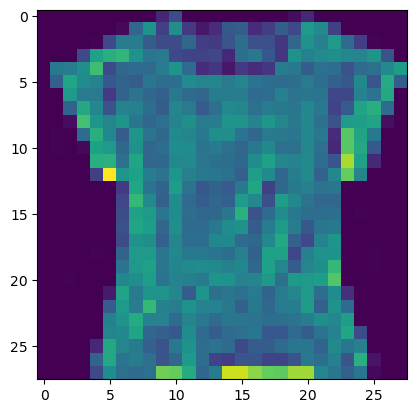

Predicted: Shirt Actual: T-shirt/top


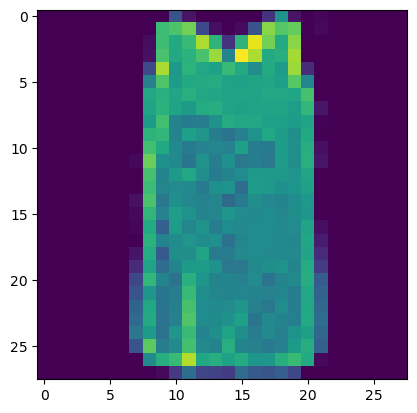

Predicted: Coat Actual: Shirt


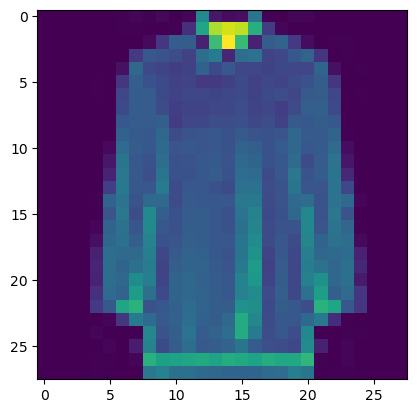

Predicted: Coat Actual: Shirt


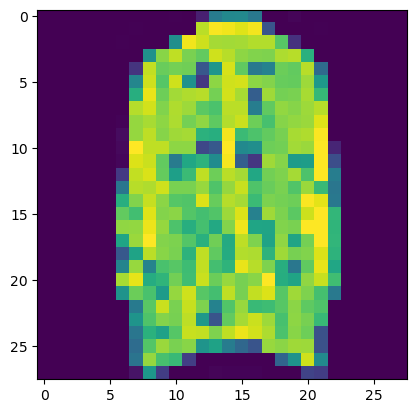

Predicted: T-shirt/top Actual: Shirt


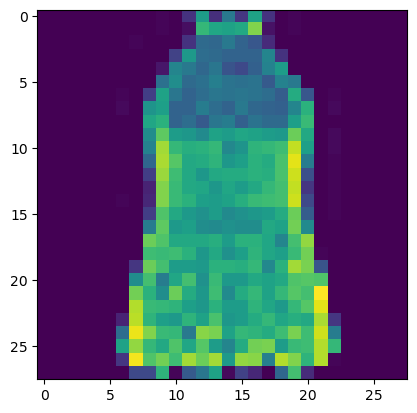

Predicted: Coat Actual: Shirt


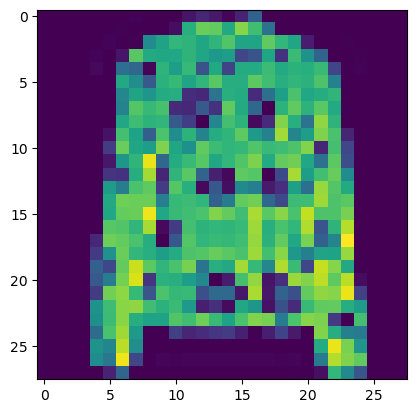

Predicted: Shirt Actual: Dress


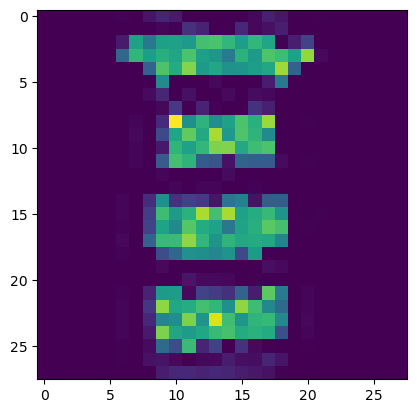

Predicted: T-shirt/top Actual: Pullover


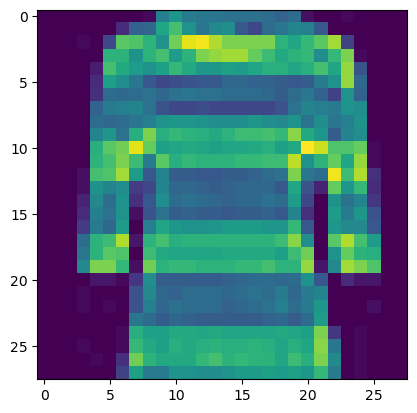

Predicted: Pullover Actual: Coat


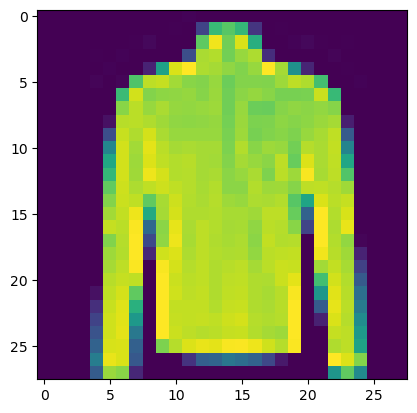

Predicted: T-shirt/top Actual: Shirt


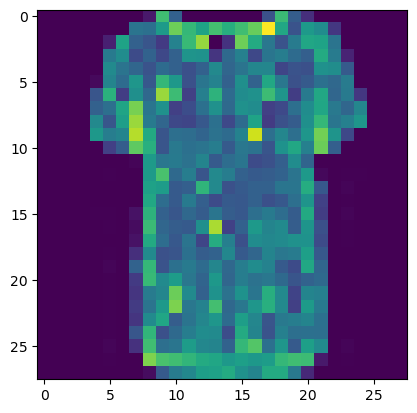

Predicted: Coat Actual: Shirt


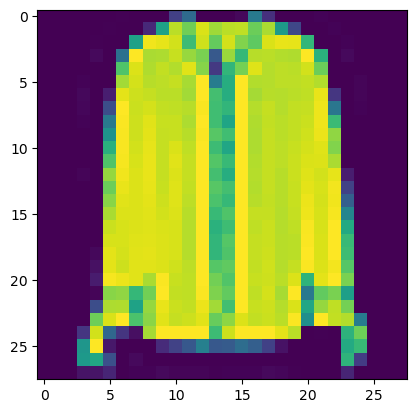

Predicted: T-shirt/top Actual: Dress


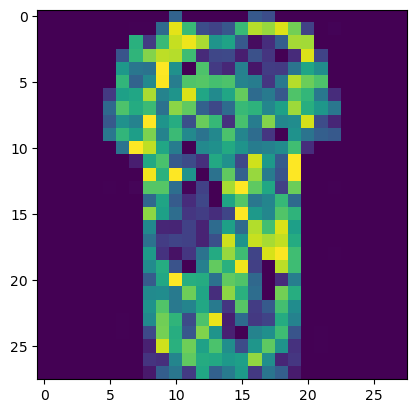

Predicted: Pullover Actual: Shirt


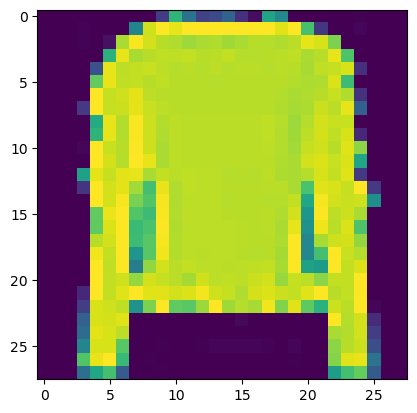

Predicted: Shirt Actual: Pullover


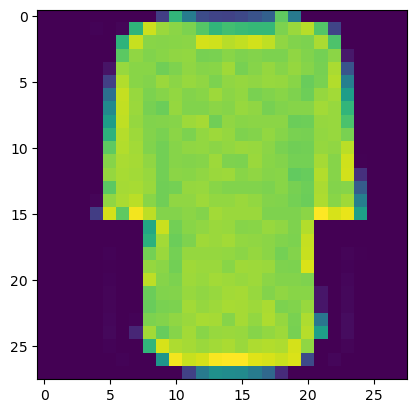

Predicted: Coat Actual: Shirt


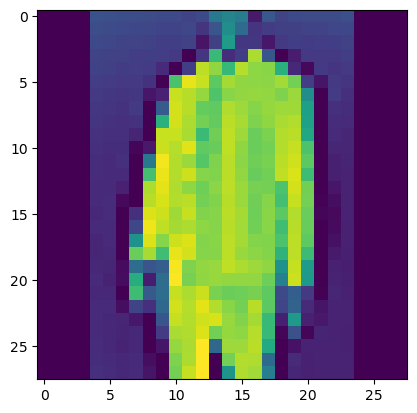

Predicted: Sneaker Actual: Ankle boot


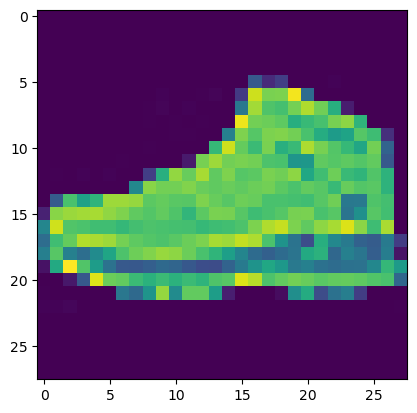

Predicted: T-shirt/top Actual: Shirt


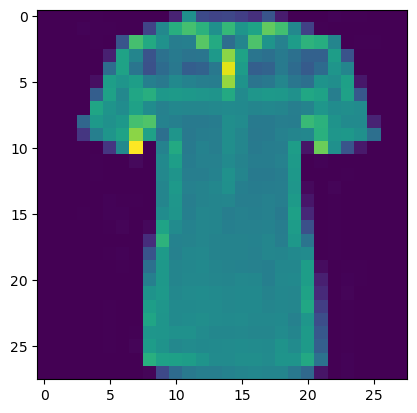

Predicted: T-shirt/top Actual: Shirt


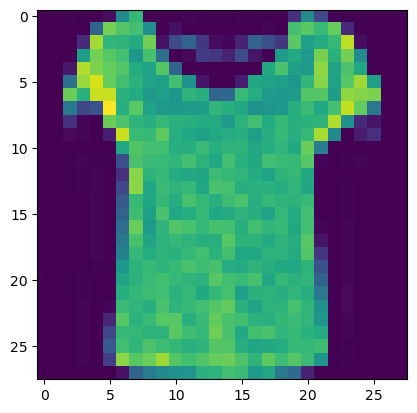

Predicted: Coat Actual: Trouser


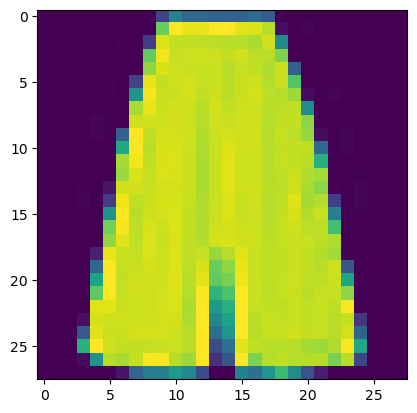

Predicted: Shirt Actual: T-shirt/top


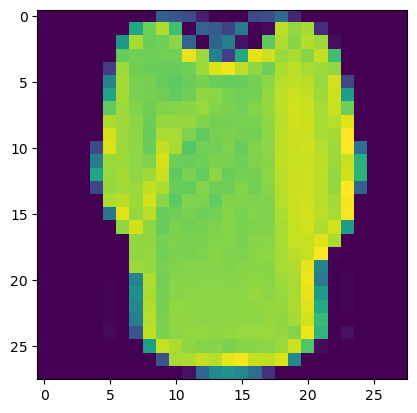

Predicted: Trouser Actual: Pullover


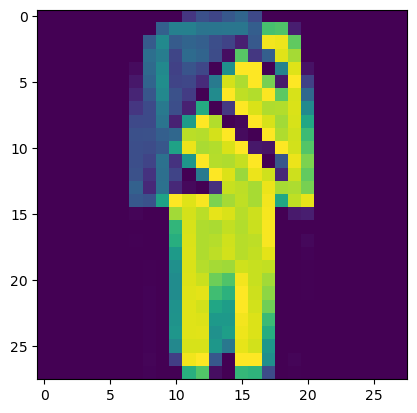

Predicted: Shirt Actual: Dress


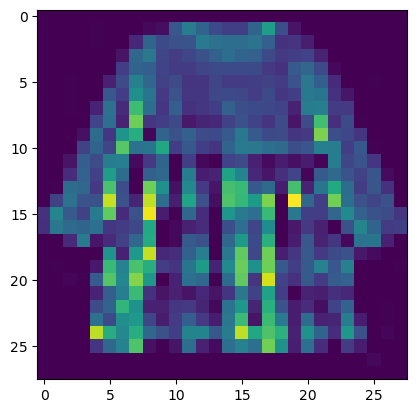

Predicted: Pullover Actual: Shirt


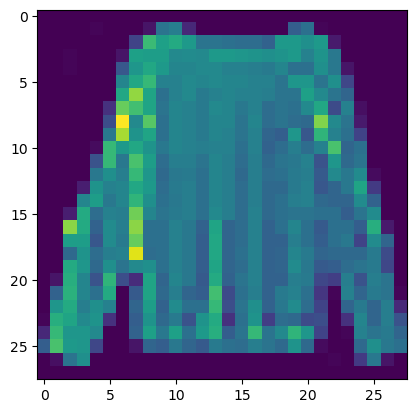

Predicted: Shirt Actual: Pullover


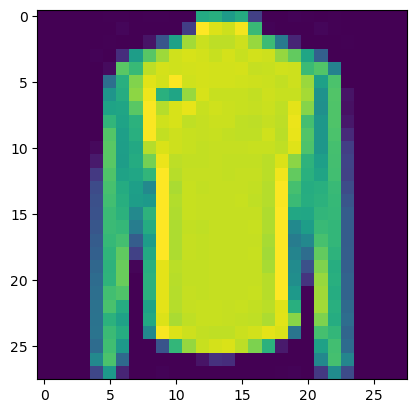

Predicted: Pullover Actual: Coat


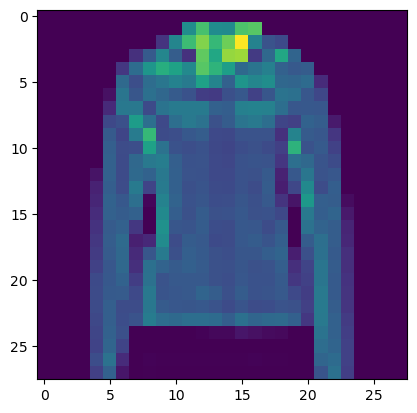

Predicted: Shirt Actual: T-shirt/top


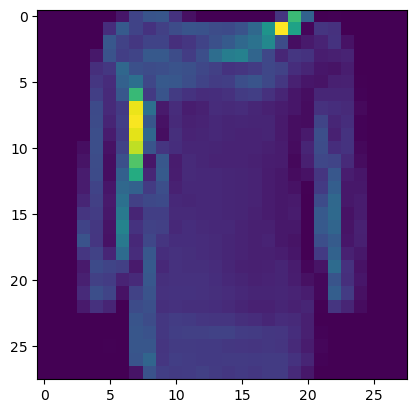

Predicted: Dress Actual: Shirt


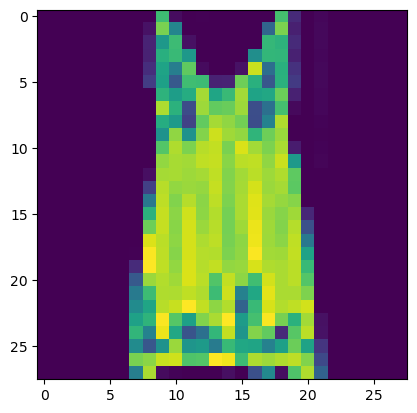

Predicted: Coat Actual: Shirt


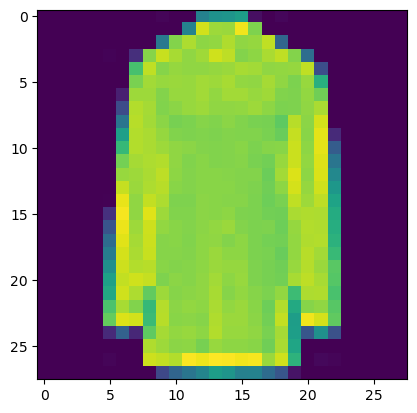

Predicted: Sneaker Actual: Ankle boot


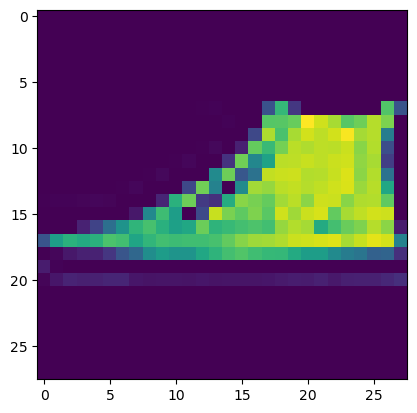

Predicted: Shirt Actual: T-shirt/top


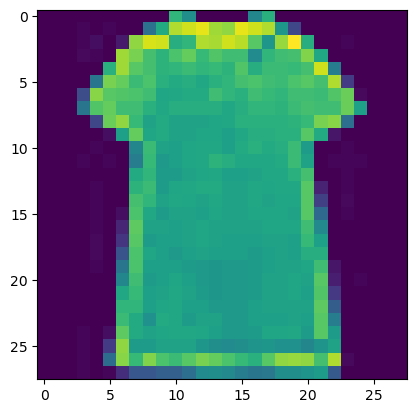

Predicted: Dress Actual: Pullover


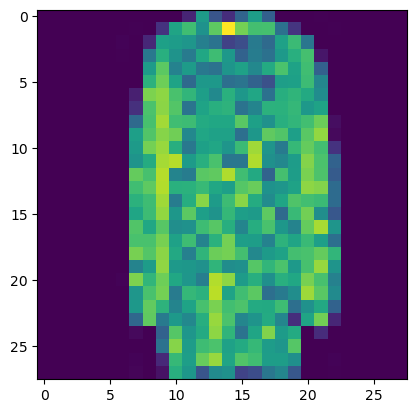

Predicted: T-shirt/top Actual: Shirt


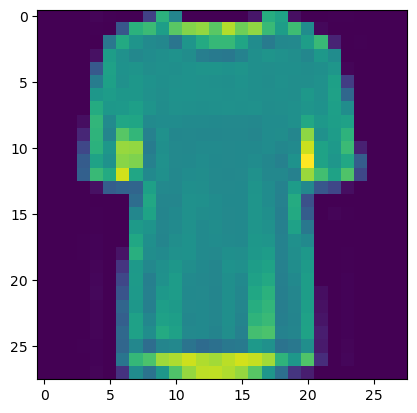

Predicted: Trouser Actual: Dress


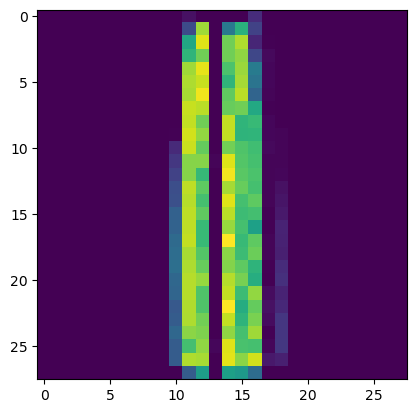

Predicted: Bag Actual: Trouser


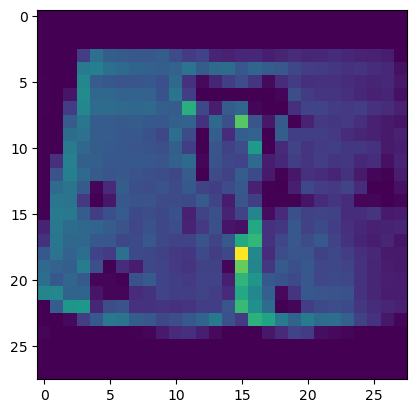

Predicted: T-shirt/top Actual: Shirt


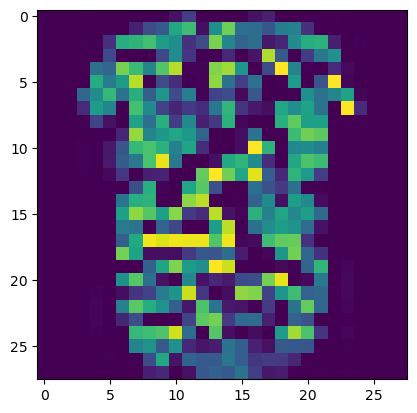

Predicted: Pullover Actual: Coat


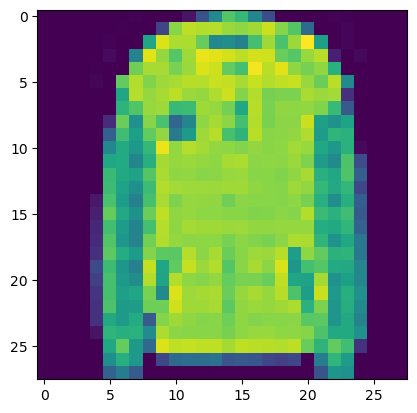

Predicted: Shirt Actual: T-shirt/top


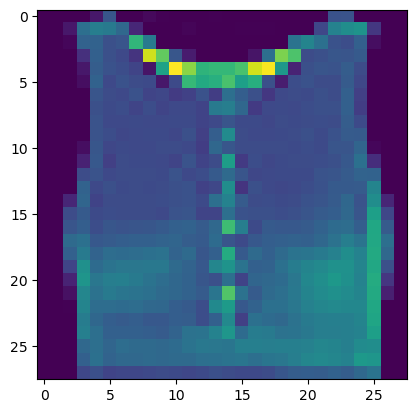

Predicted: Shirt Actual: Coat


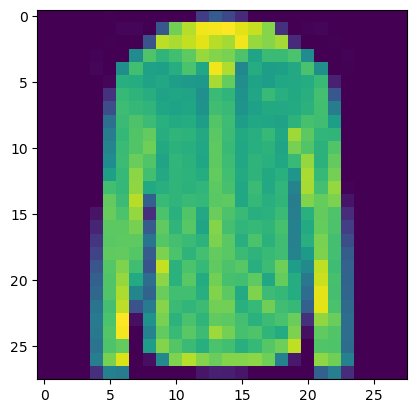

Predicted: Shirt Actual: Dress


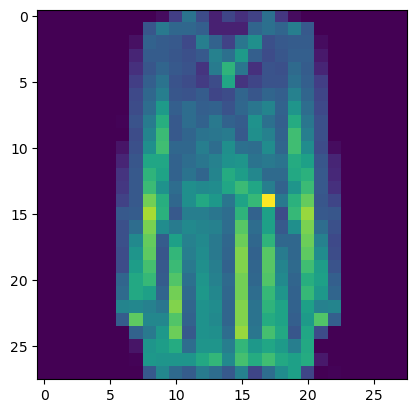

Predicted: T-shirt/top Actual: Shirt


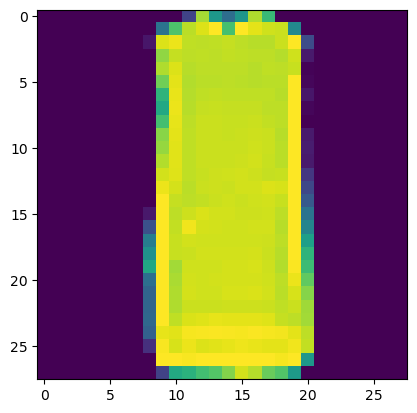

Predicted: Sneaker Actual: Ankle boot


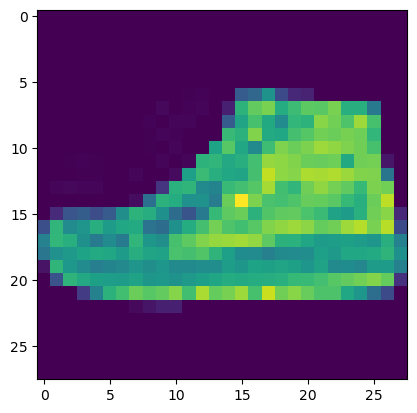

Predicted: Pullover Actual: Coat


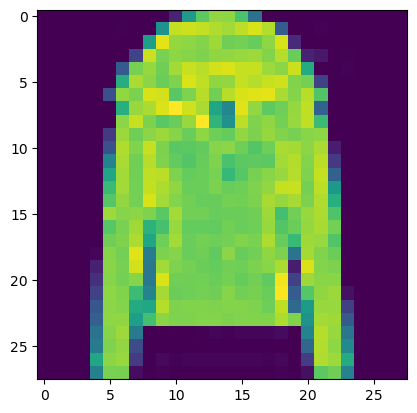

Predicted: T-shirt/top Actual: Shirt


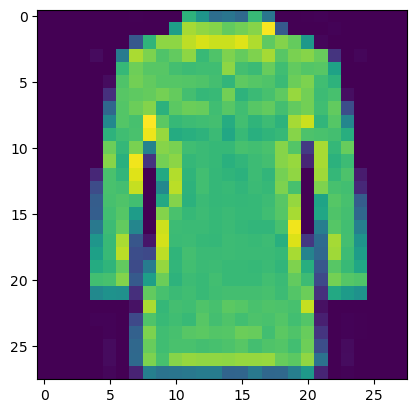

Predicted: Dress Actual: Trouser


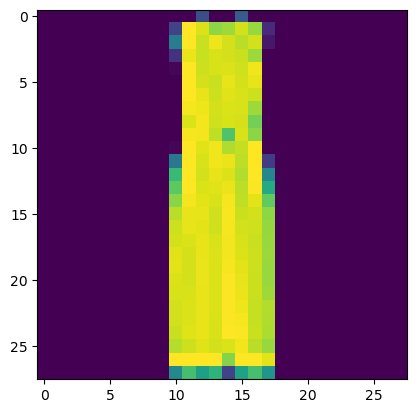

Predicted: Shirt Actual: Pullover


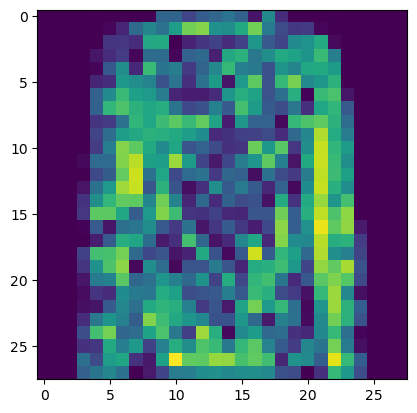

Predicted: Sneaker Actual: Ankle boot


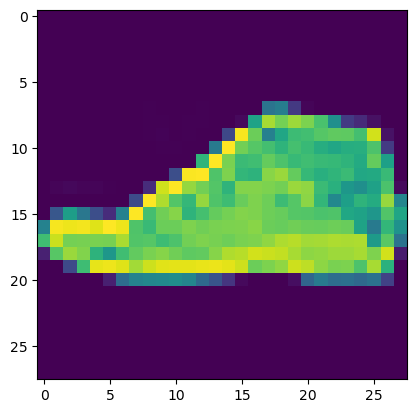

Predicted: Sneaker Actual: Ankle boot


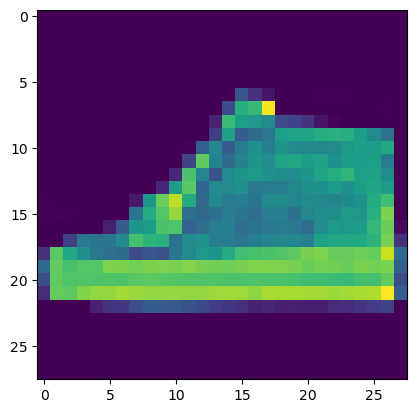

Predicted: Pullover Actual: Coat


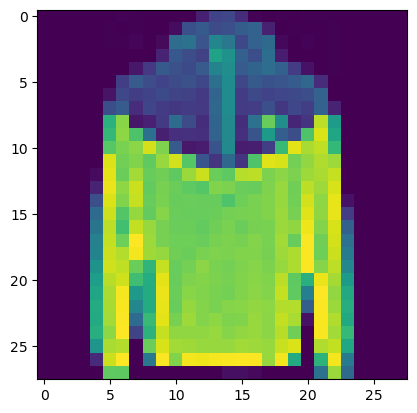

Predicted: Shirt Actual: T-shirt/top


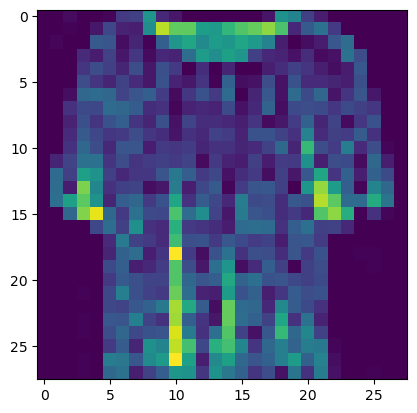

Predicted: Coat Actual: Shirt


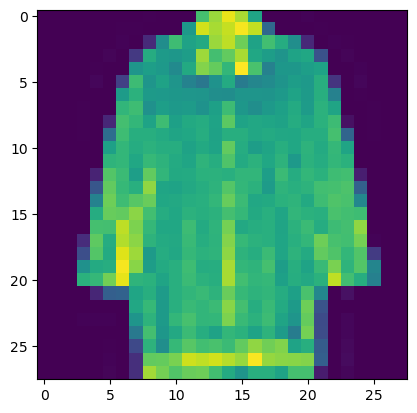

Predicted: Shirt Actual: T-shirt/top


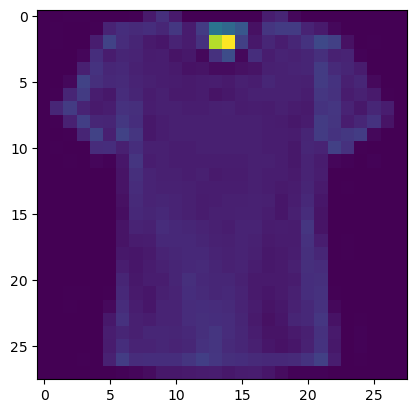

Predicted: Pullover Actual: Coat


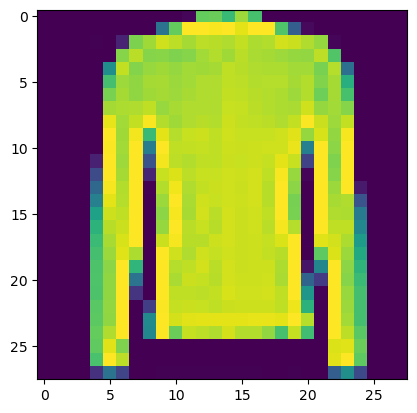

Predicted: Shirt Actual: Coat


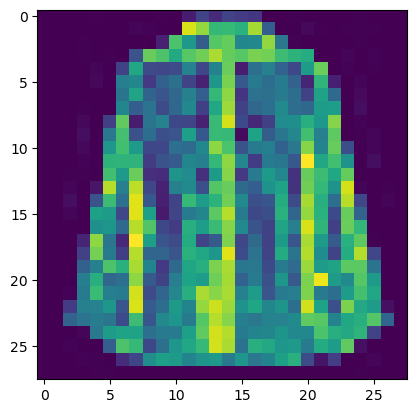

Predicted: Pullover Actual: Shirt


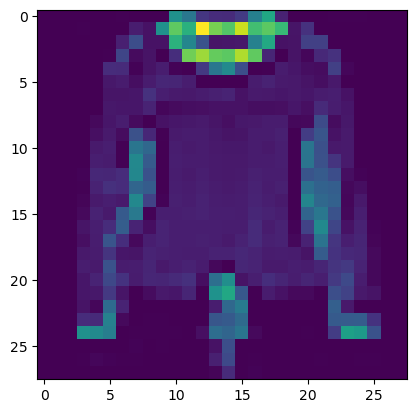

Predicted: Ankle boot Actual: Sneaker


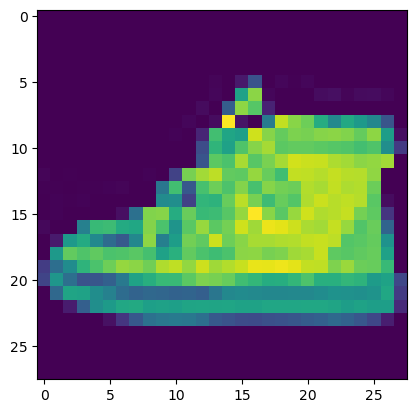

Predicted: T-shirt/top Actual: Bag


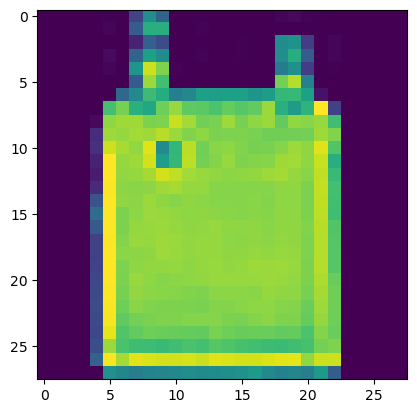

Predicted: Dress Actual: Coat


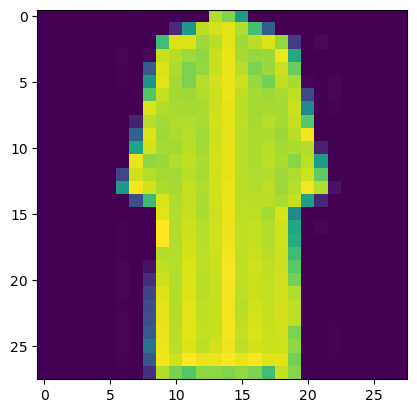

Predicted: Pullover Actual: Shirt


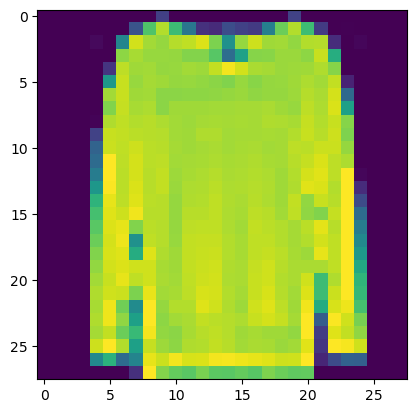

Predicted: Shirt Actual: T-shirt/top


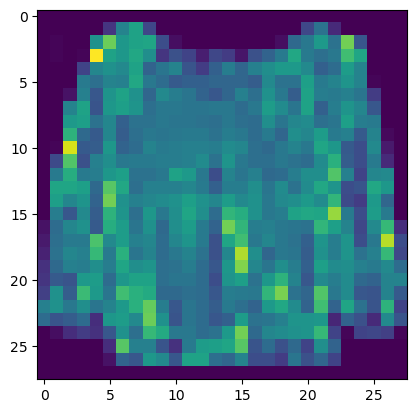

Predicted: Shirt Actual: T-shirt/top


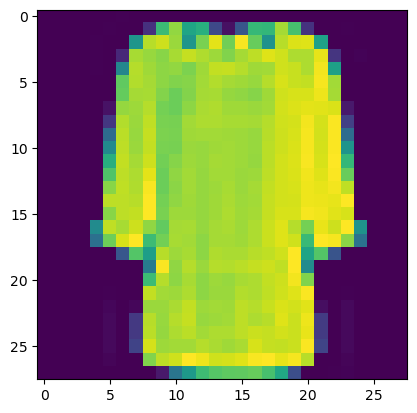

Predicted: Coat Actual: Pullover


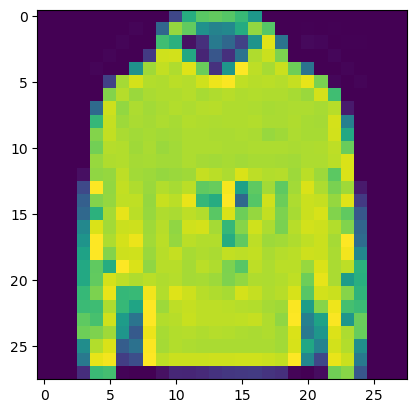

Predicted: Coat Actual: Shirt


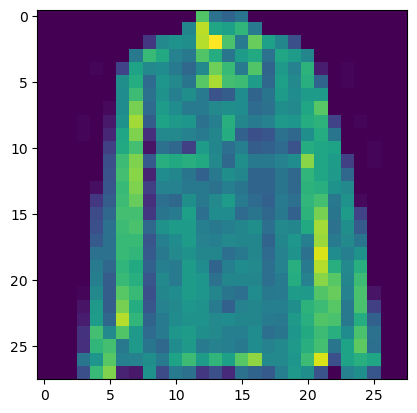

Predicted: T-shirt/top Actual: Shirt


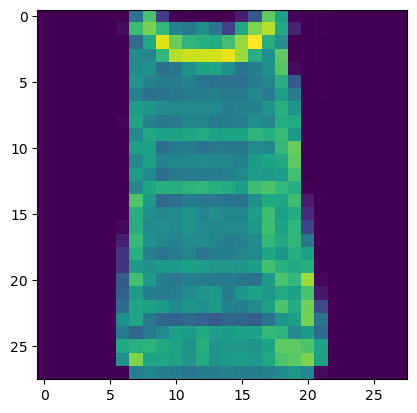

Predicted: Shirt Actual: T-shirt/top


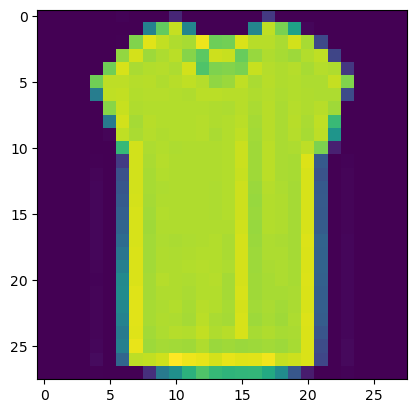

Predicted: T-shirt/top Actual: Shirt


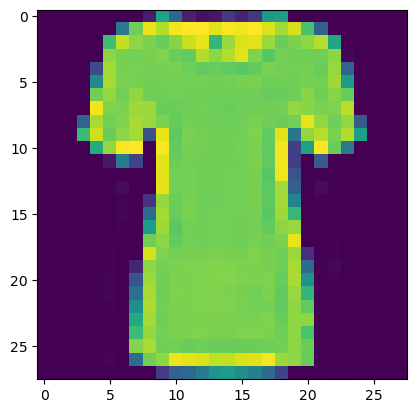

Predicted: Pullover Actual: T-shirt/top


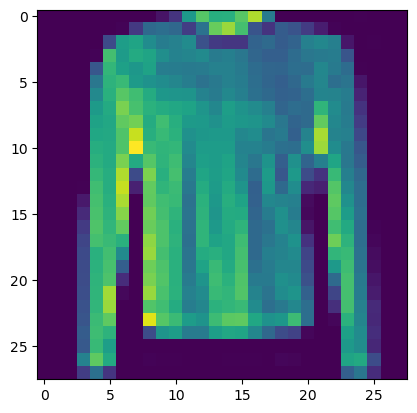

Predicted: Pullover Actual: Shirt


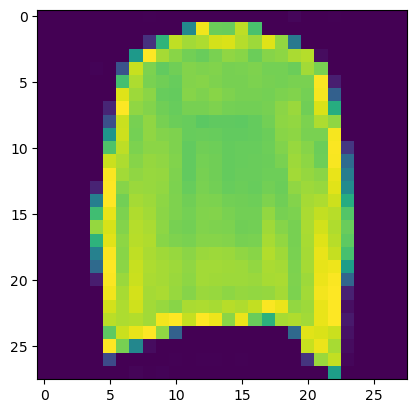

Predicted: Sandal Actual: T-shirt/top


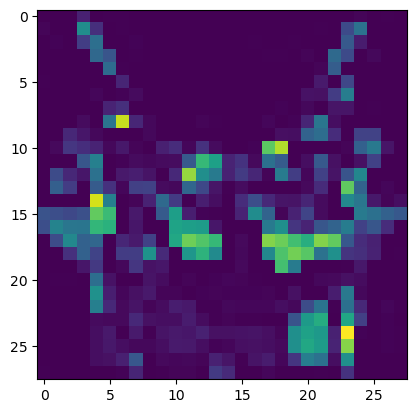

Predicted: Sneaker Actual: Ankle boot


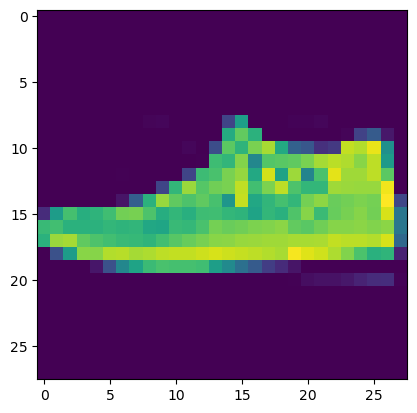

Predicted: Sneaker Actual: Ankle boot


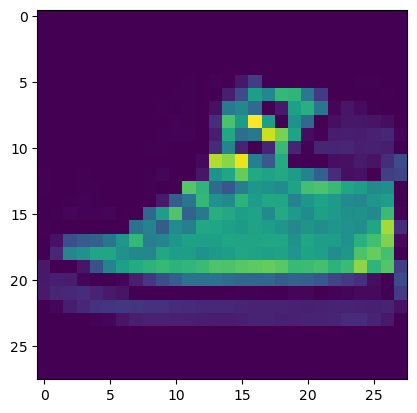

Predicted: Shirt Actual: Dress


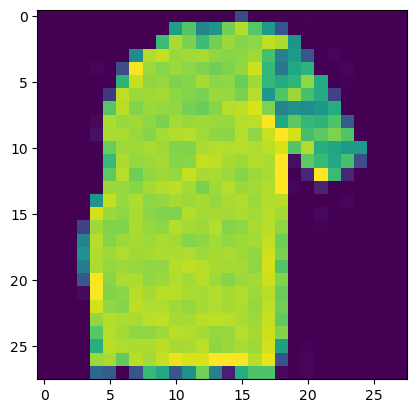

Predicted: Sneaker Actual: Ankle boot


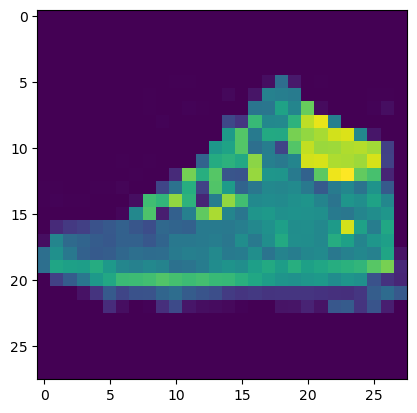

Predicted: Shirt Actual: T-shirt/top


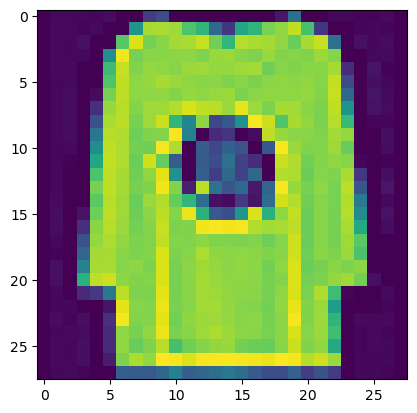

Predicted: Sneaker Actual: Ankle boot


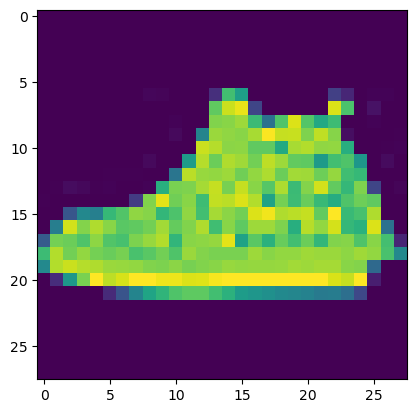

Predicted: Trouser Actual: Shirt


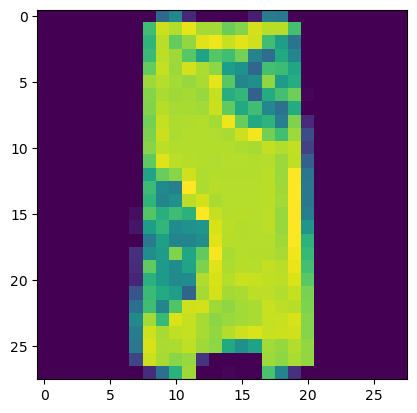

Predicted: Coat Actual: Pullover


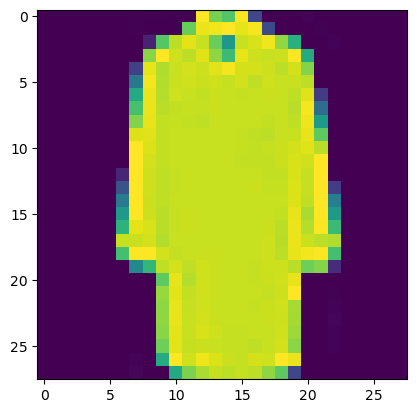

Predicted: Shirt Actual: Dress


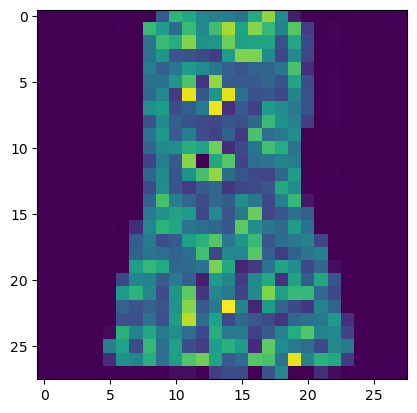

Predicted: T-shirt/top Actual: Shirt


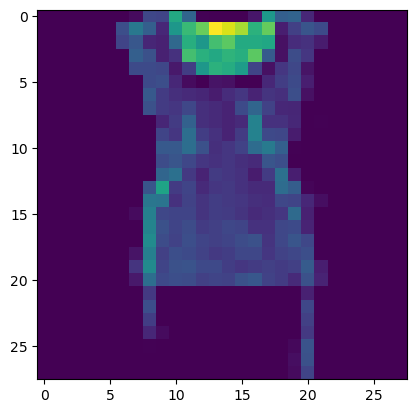

Predicted: Pullover Actual: Coat


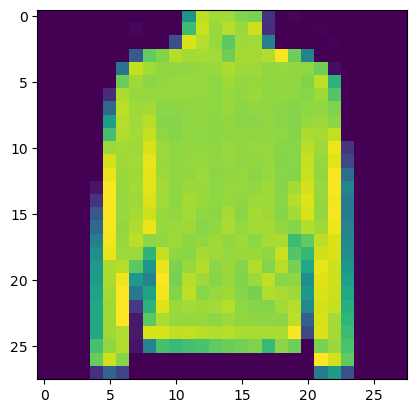

Predicted: Shirt Actual: T-shirt/top


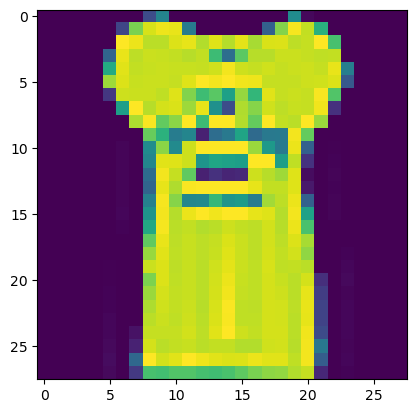

Predicted: T-shirt/top Actual: Shirt


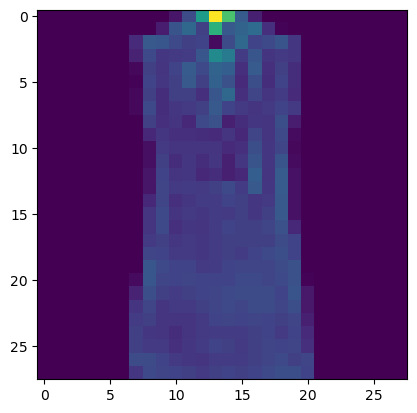

Predicted: Coat Actual: Dress


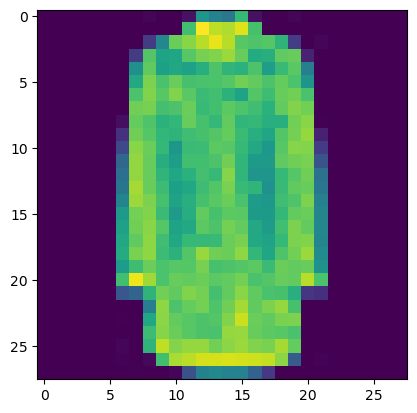

Predicted: Shirt Actual: T-shirt/top


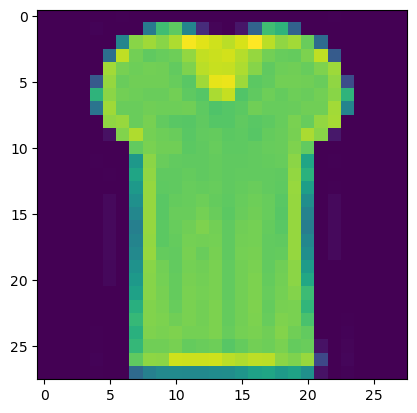

Predicted: Coat Actual: T-shirt/top


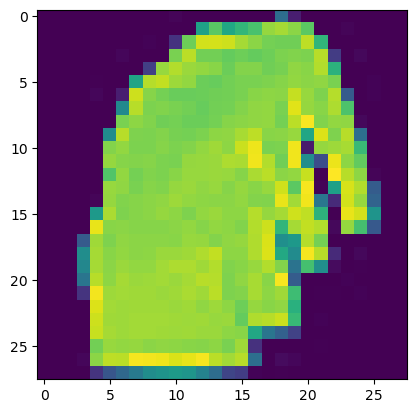

Predicted: Ankle boot Actual: Sneaker


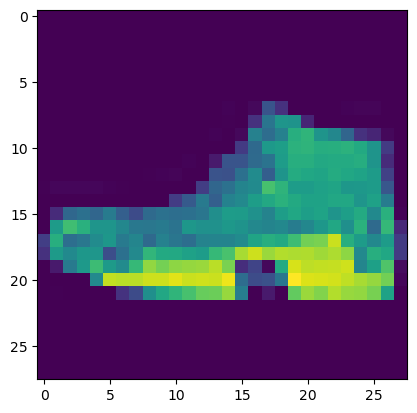

Predicted: Shirt Actual: Dress


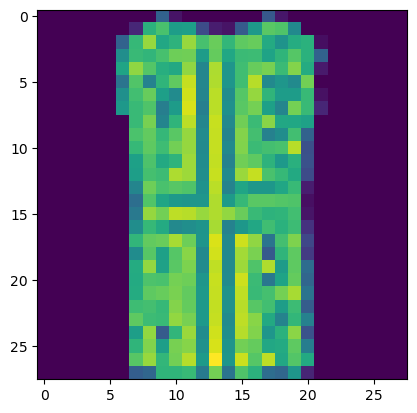

Predicted: Shirt Actual: T-shirt/top


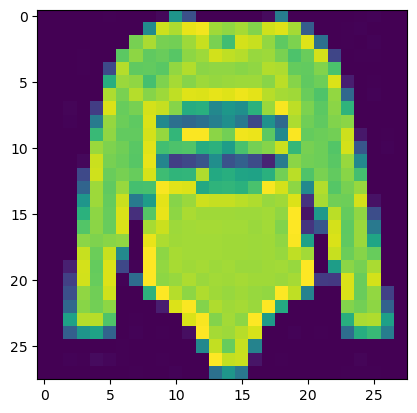

Predicted: Shirt Actual: Coat


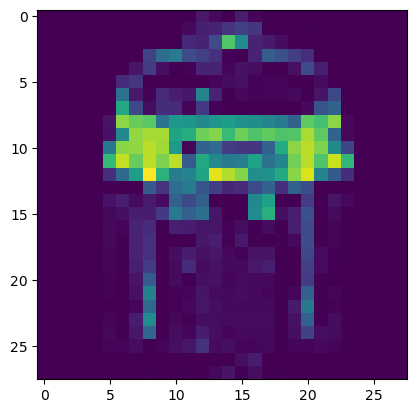

Predicted: Shirt Actual: T-shirt/top


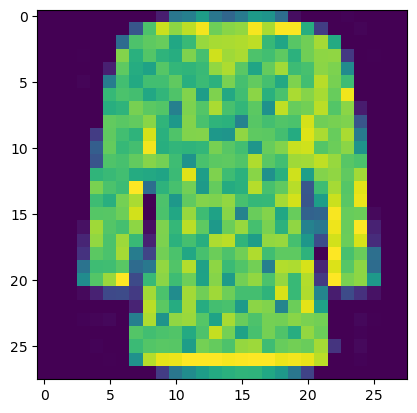

Predicted: Shirt Actual: Pullover


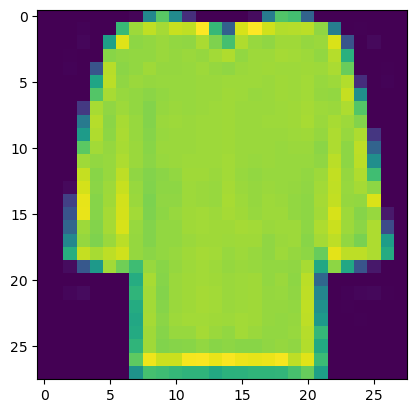

Predicted: Pullover Actual: Shirt


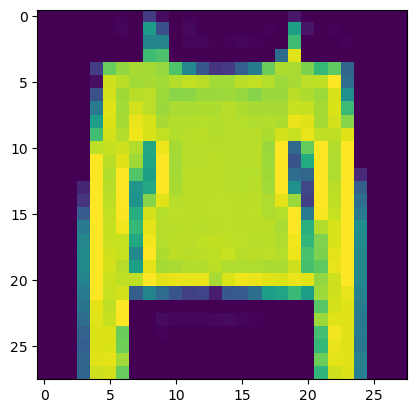

Predicted: Shirt Actual: Dress


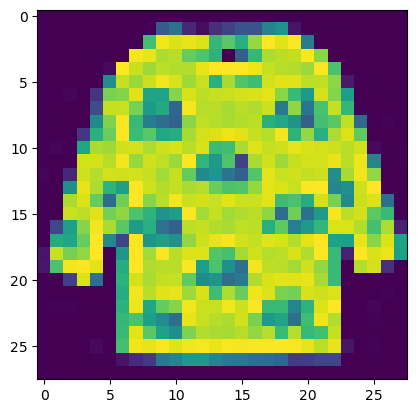

Predicted: T-shirt/top Actual: Shirt


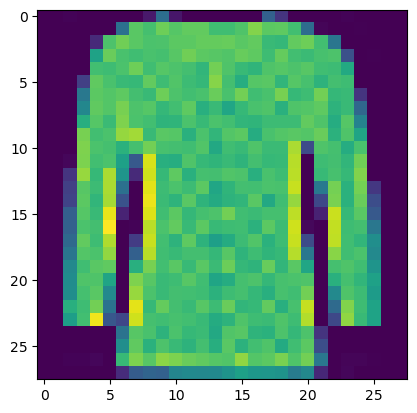

Predicted: Dress Actual: Coat


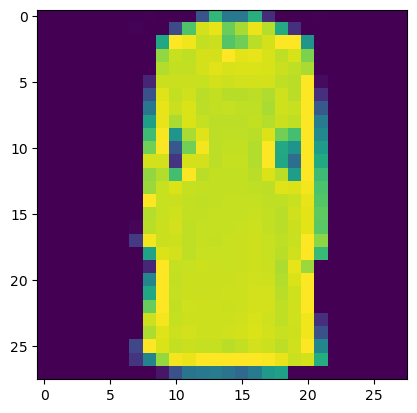

Predicted: Coat Actual: Pullover


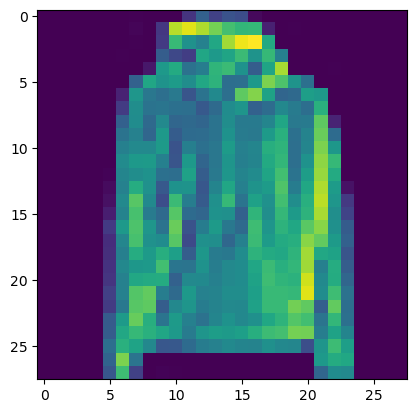

Predicted: Shirt Actual: Pullover


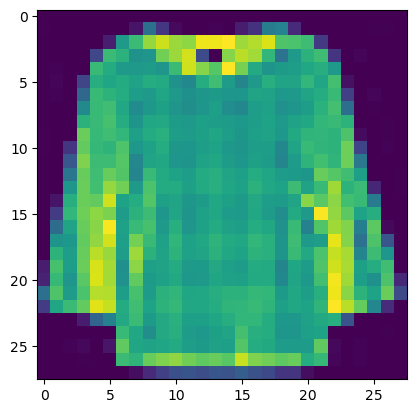

Predicted: Shirt Actual: T-shirt/top


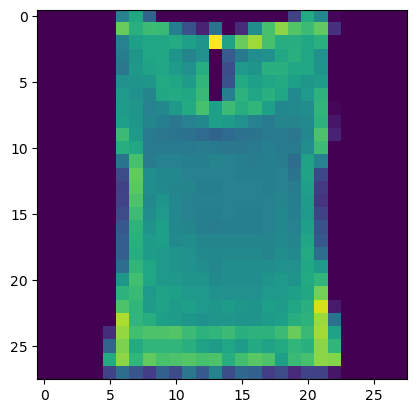

Predicted: Coat Actual: Shirt


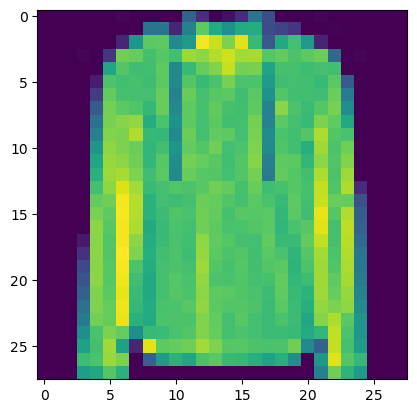

Predicted: Shirt Actual: Pullover


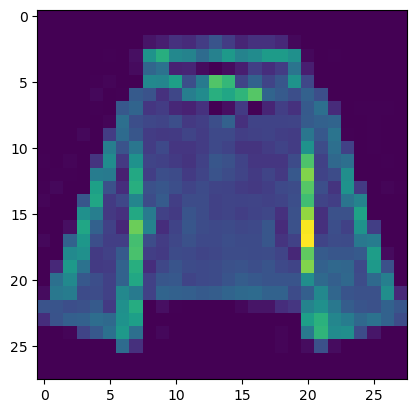

Predicted: T-shirt/top Actual: Pullover


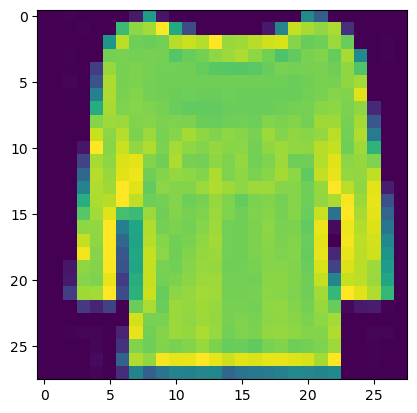

Predicted: Shirt Actual: Coat


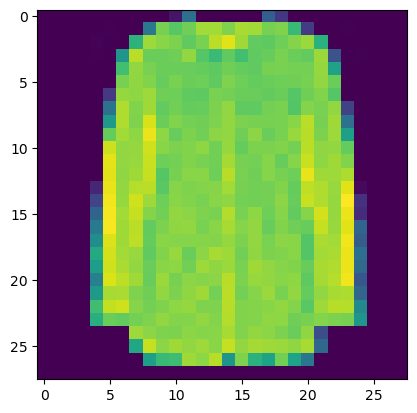

Predicted: Shirt Actual: Coat


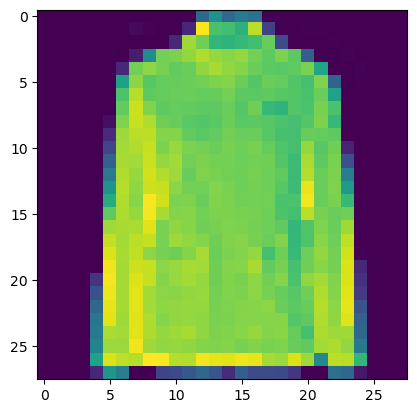

Predicted: Pullover Actual: Shirt


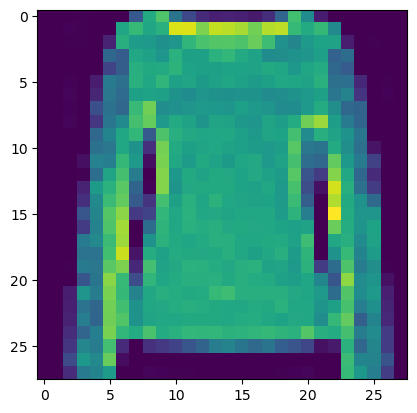

Predicted: Coat Actual: Shirt


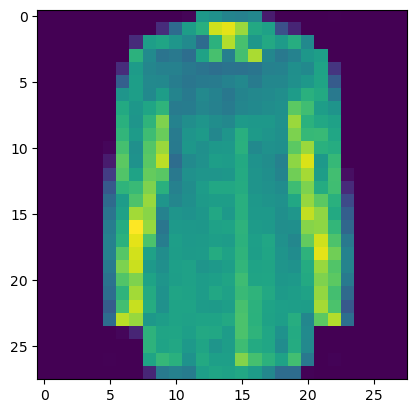

Predicted: Pullover Actual: Dress


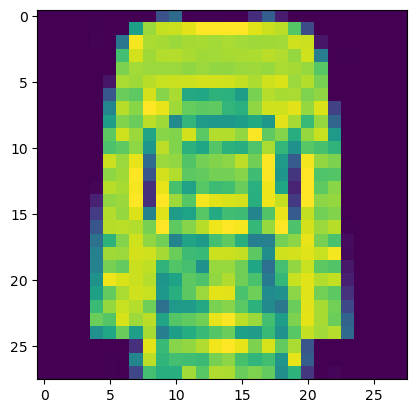

Predicted: Shirt Actual: Coat


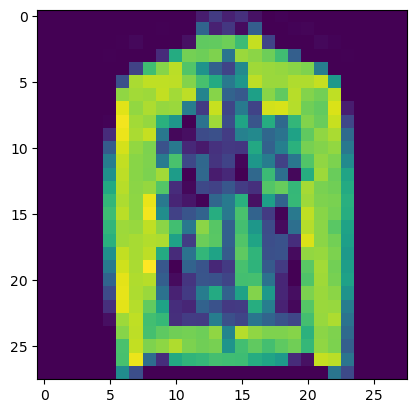

Predicted: Coat Actual: Pullover


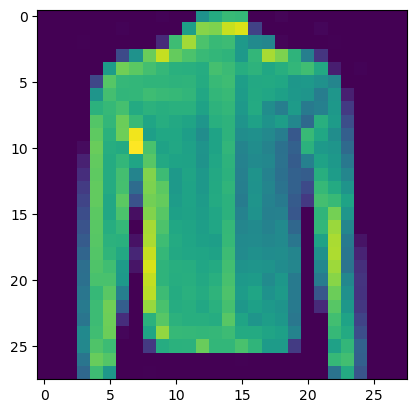

Predicted: T-shirt/top Actual: Dress


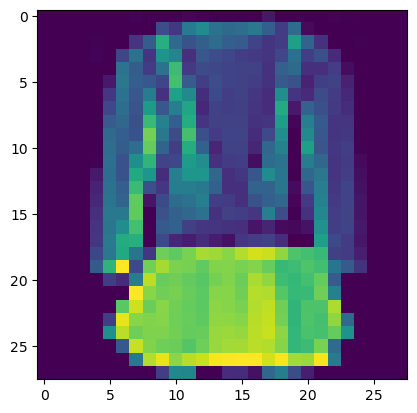

Predicted: Sneaker Actual: Ankle boot


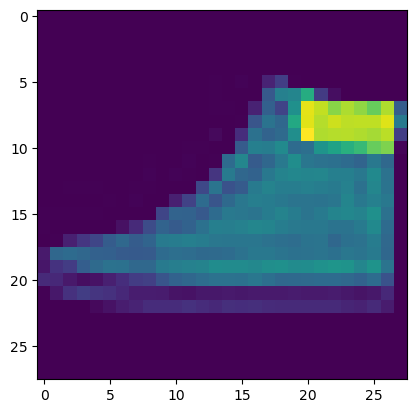

Predicted: Coat Actual: Pullover


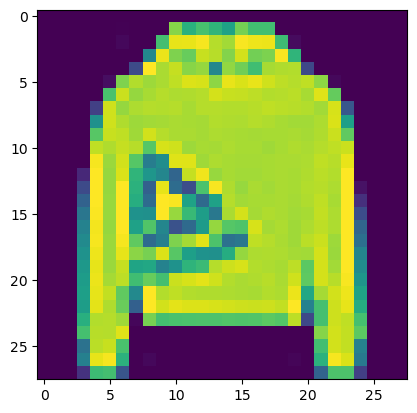

Predicted: T-shirt/top Actual: Shirt


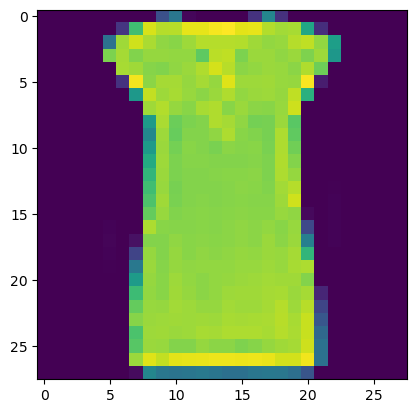

Predicted: Dress Actual: Coat


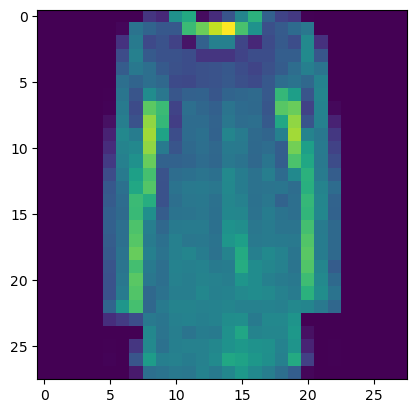

Predicted: Shirt Actual: Coat


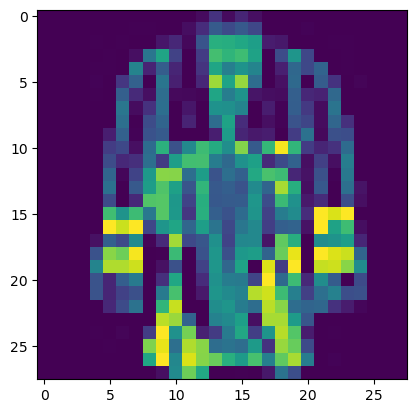

Predicted: Dress Actual: T-shirt/top


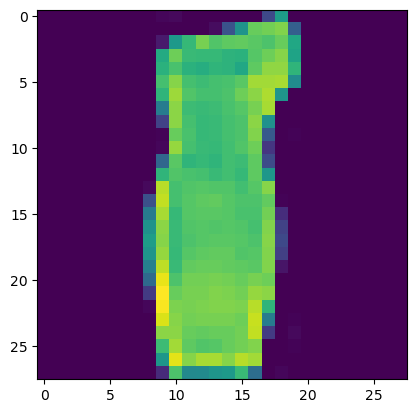

Predicted: Coat Actual: T-shirt/top


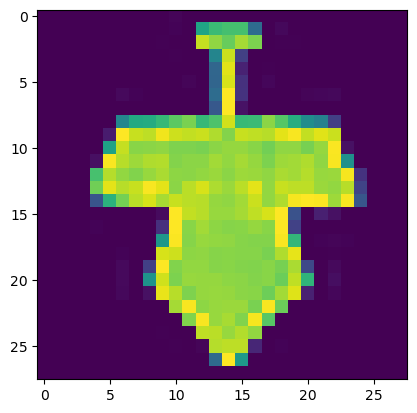

Predicted: Coat Actual: Dress


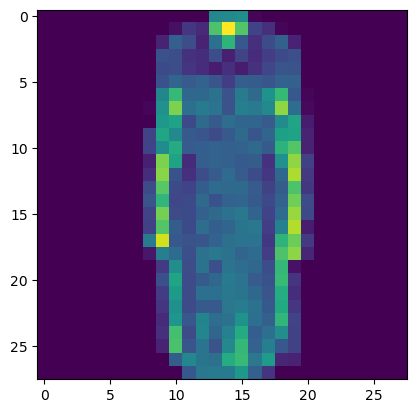

Predicted: Sneaker Actual: Ankle boot


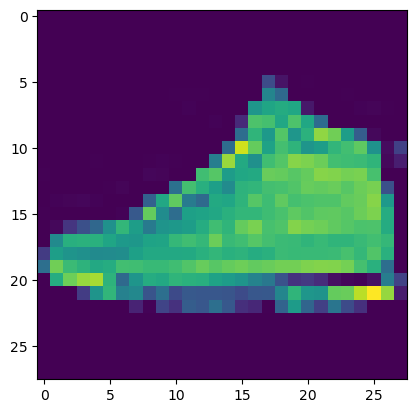

Predicted: Pullover Actual: Trouser


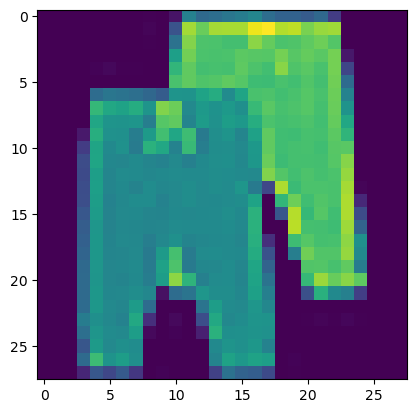

Predicted: Shirt Actual: T-shirt/top


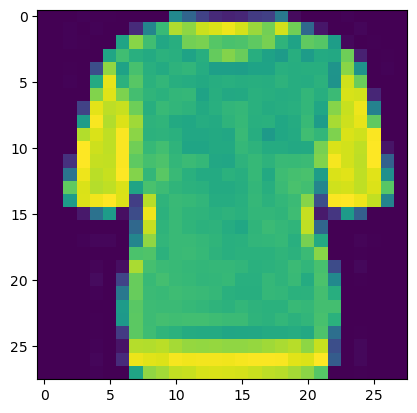

Predicted: Shirt Actual: Coat


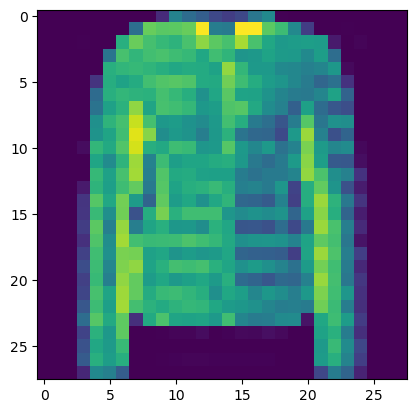

Predicted: Dress Actual: T-shirt/top


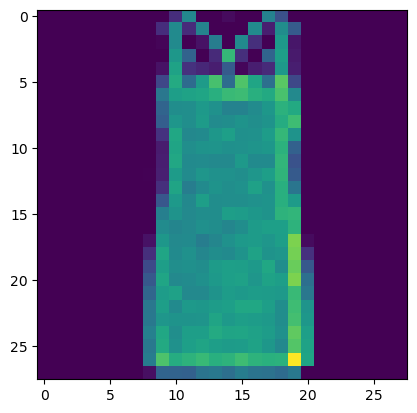

Predicted: Shirt Actual: T-shirt/top


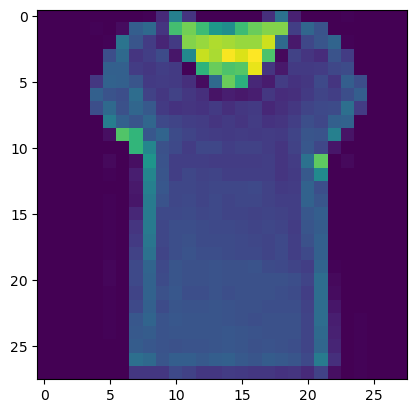

Predicted: Dress Actual: T-shirt/top


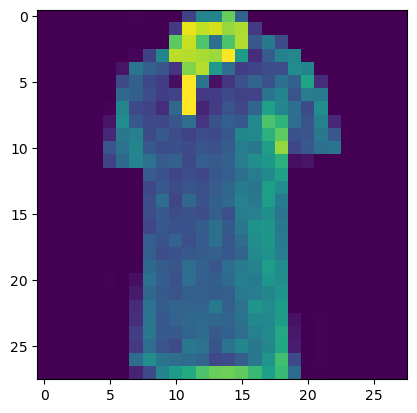

Predicted: Sneaker Actual: Ankle boot


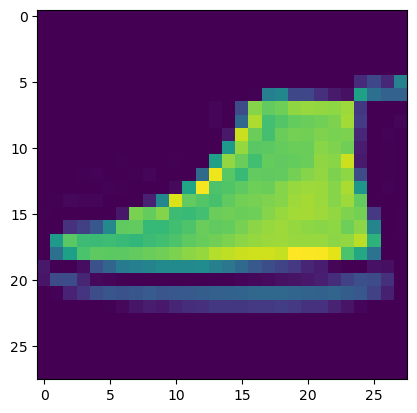

Predicted: Coat Actual: Pullover


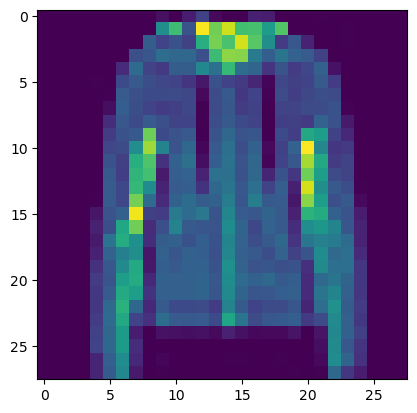

Predicted: Coat Actual: Shirt


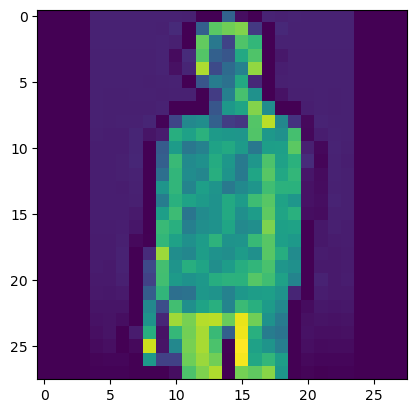

Predicted: Shirt Actual: Pullover


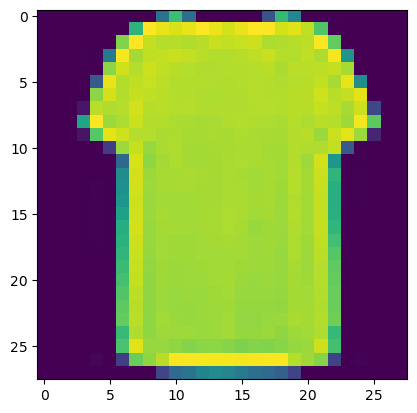

Predicted: T-shirt/top Actual: Shirt


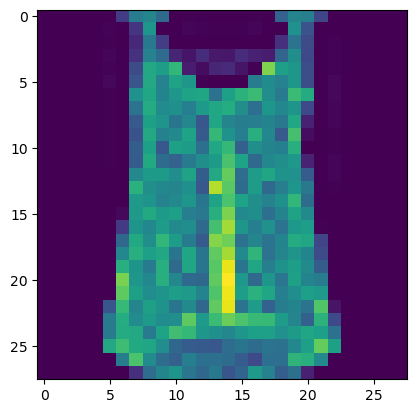

Predicted: Pullover Actual: Shirt


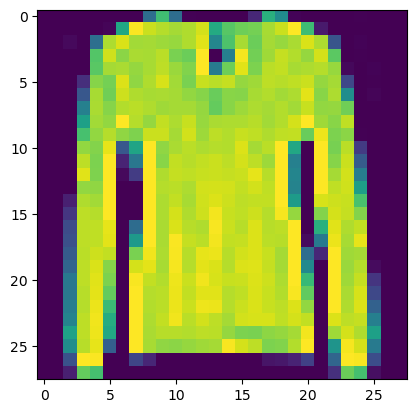

Predicted: Shirt Actual: T-shirt/top


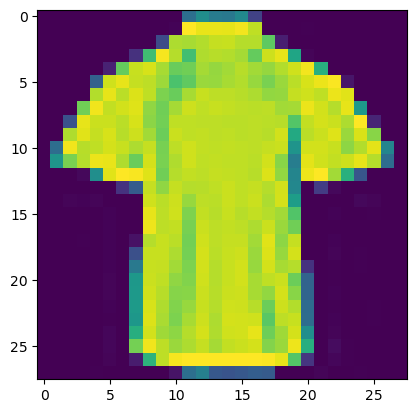

Predicted: Pullover Actual: Shirt


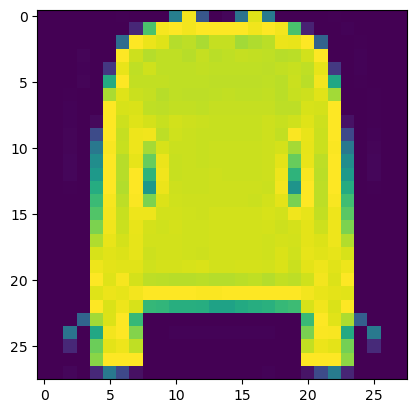

Predicted: Coat Actual: Shirt


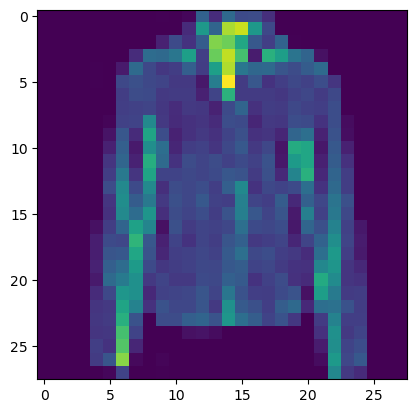

Predicted: Coat Actual: Shirt


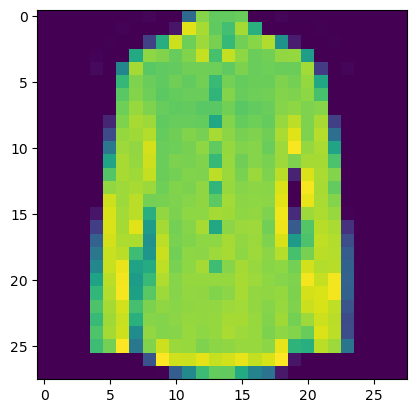

Predicted: Coat Actual: T-shirt/top


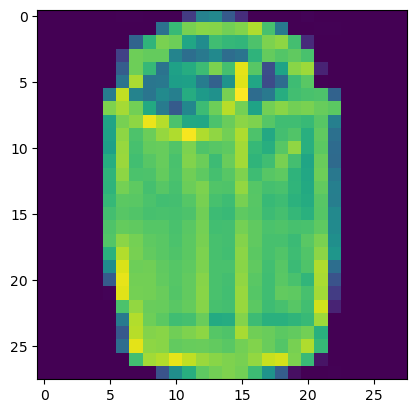

Predicted: Shirt Actual: T-shirt/top


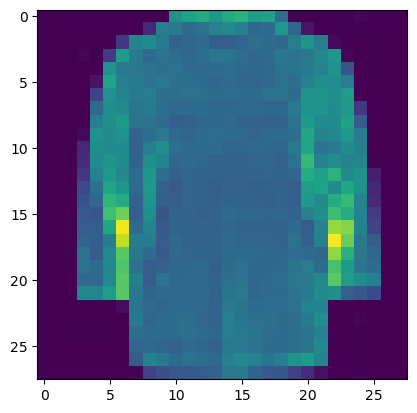

Predicted: Sneaker Actual: Ankle boot


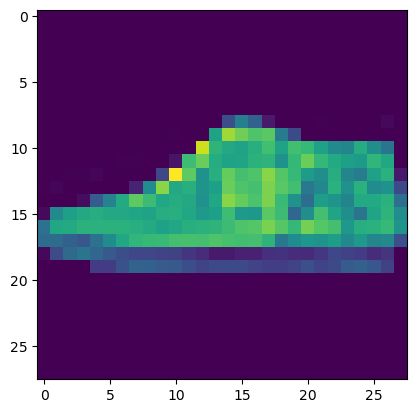

Predicted: Dress Actual: Trouser


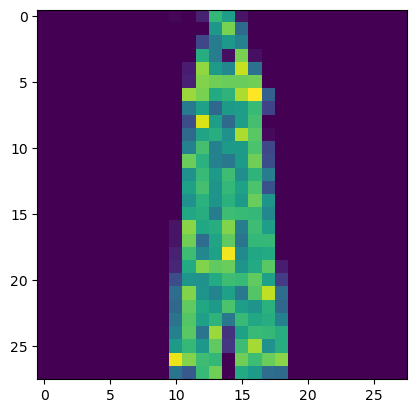

Predicted: Dress Actual: Shirt


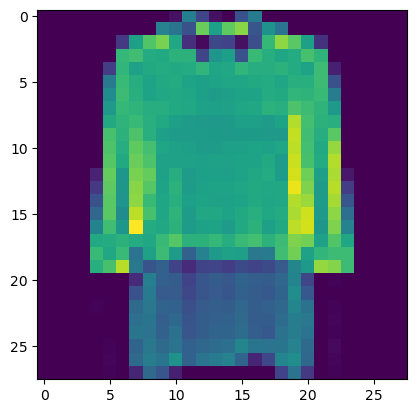

Predicted: Shirt Actual: Pullover


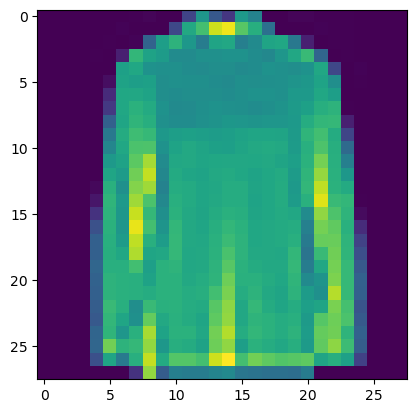

Predicted: Dress Actual: Bag


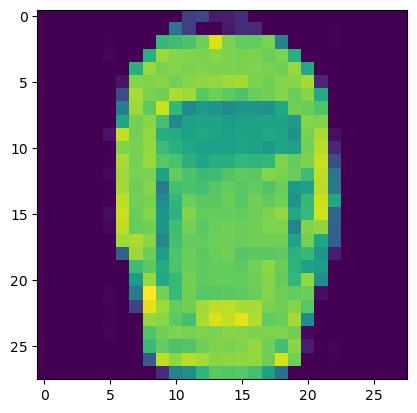

Predicted: Sneaker Actual: Ankle boot


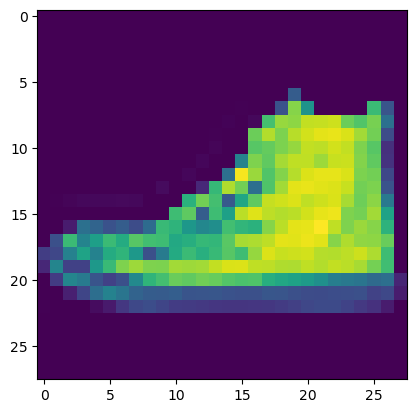

Predicted: Shirt Actual: Dress


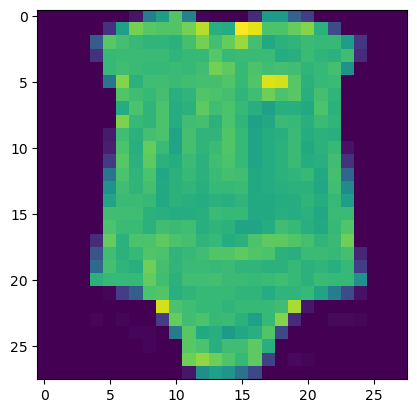

Predicted: Shirt Actual: T-shirt/top


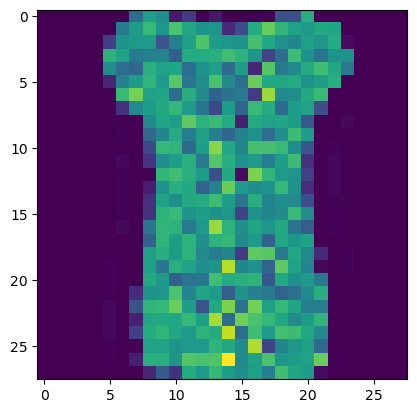

Predicted: Pullover Actual: Coat


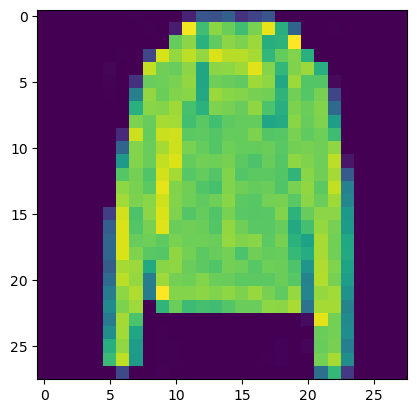

Predicted: Pullover Actual: Shirt


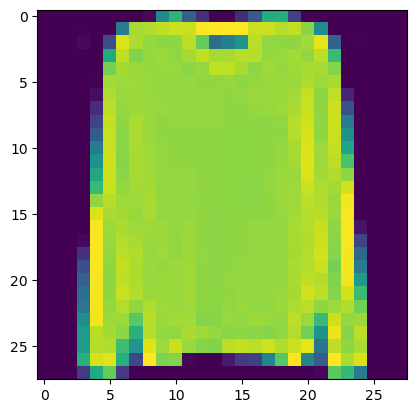

Predicted: Pullover Actual: Coat


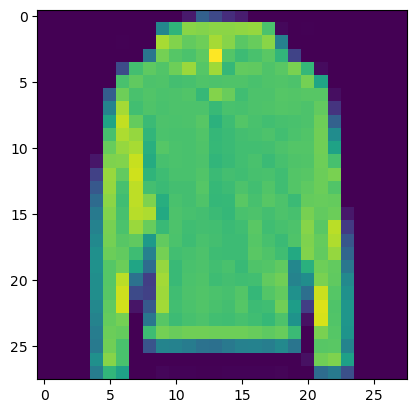

Predicted: T-shirt/top Actual: Shirt


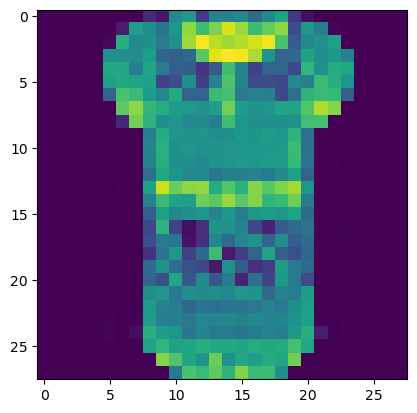

Predicted: Coat Actual: T-shirt/top


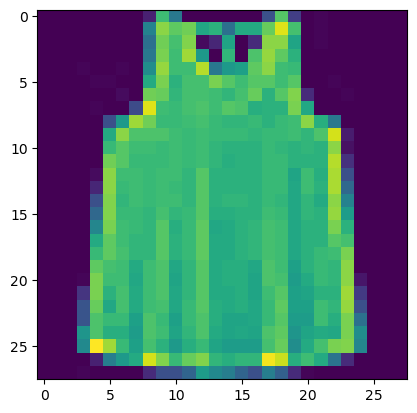

Predicted: Coat Actual: Shirt


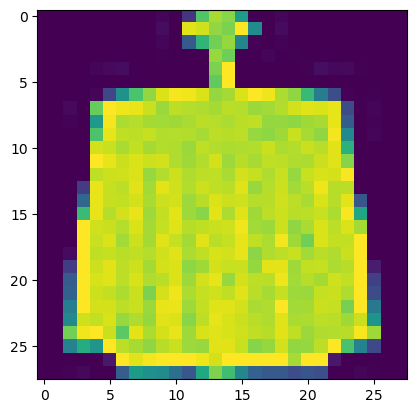

Predicted: Dress Actual: Shirt


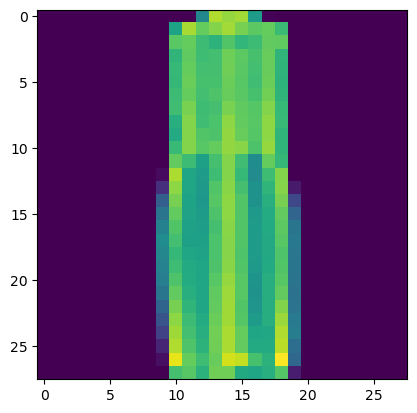

Predicted: Sneaker Actual: Ankle boot


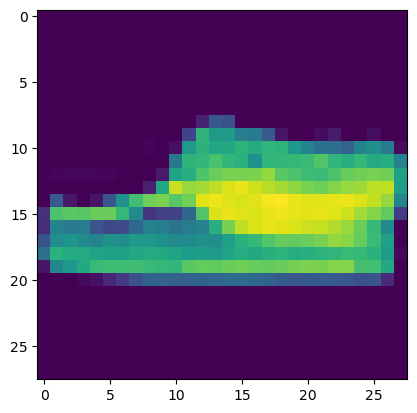

Predicted: Sneaker Actual: Ankle boot


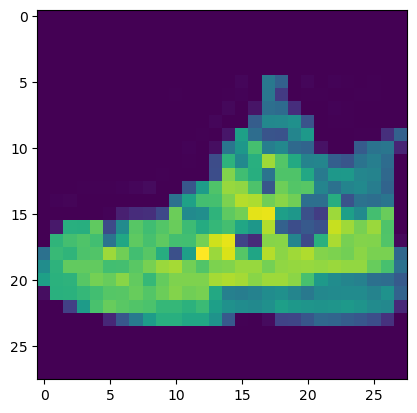

Predicted: Coat Actual: Dress


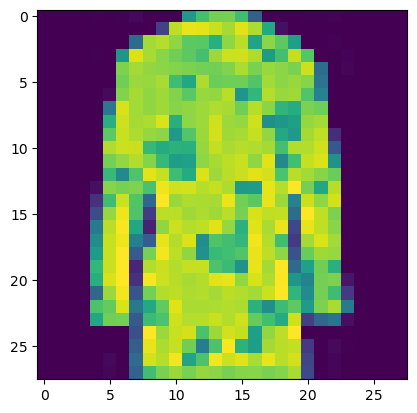

Predicted: Pullover Actual: Shirt


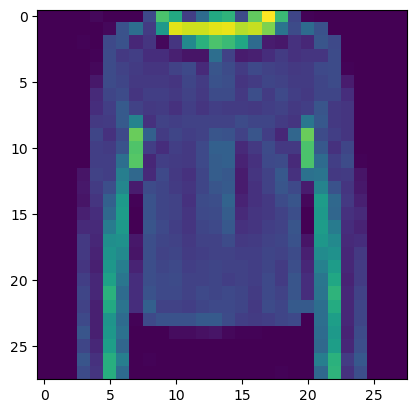

Predicted: Dress Actual: Coat


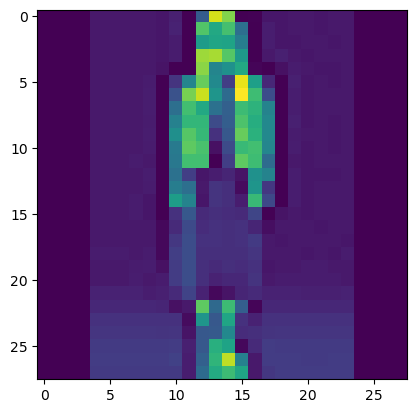

Predicted: Dress Actual: Coat


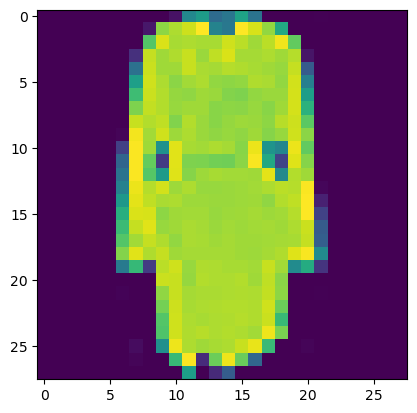

Predicted: Pullover Actual: Dress


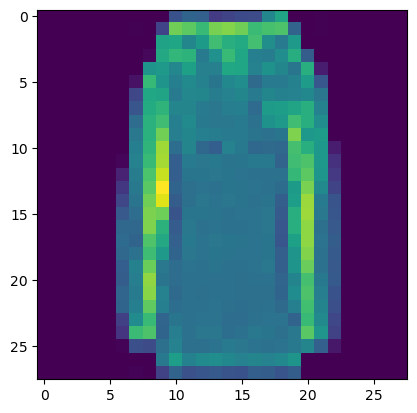

Predicted: Pullover Actual: Coat


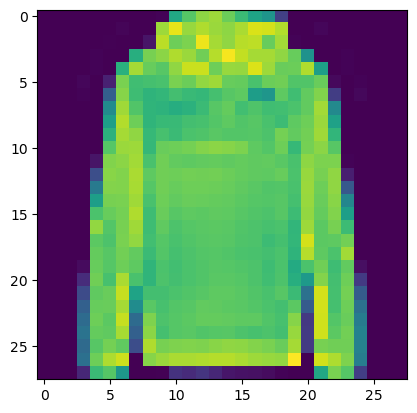

Predicted: Shirt Actual: Dress


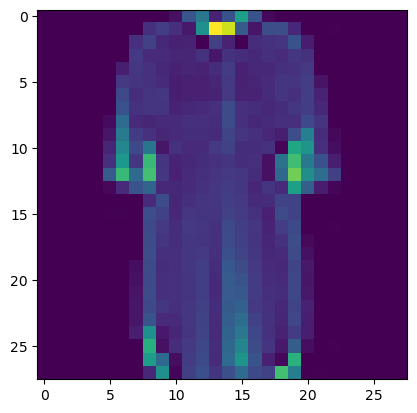

Predicted: Pullover Actual: Coat


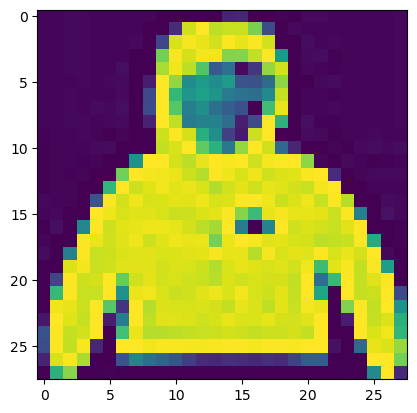

Predicted: Dress Actual: Coat


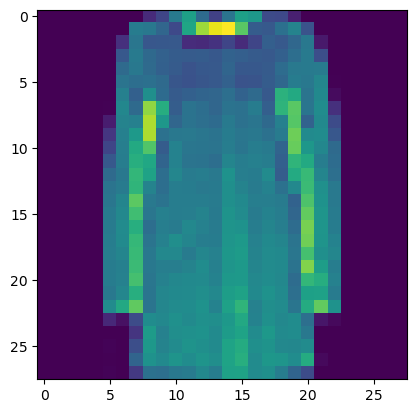

Predicted: Sneaker Actual: Ankle boot


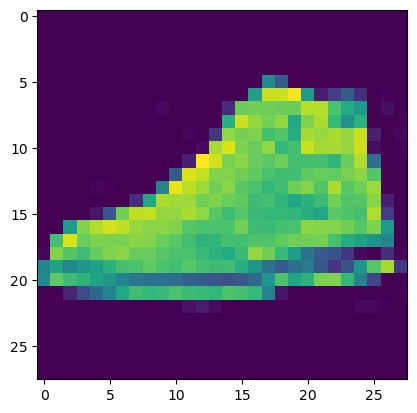

Predicted: T-shirt/top Actual: Dress


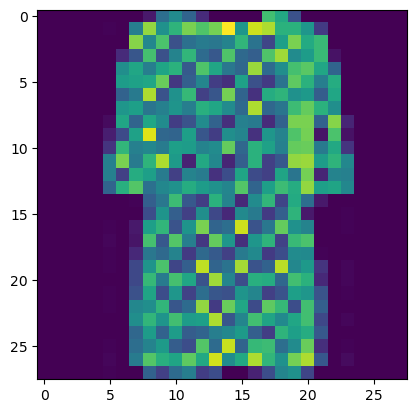

Predicted: Coat Actual: Shirt


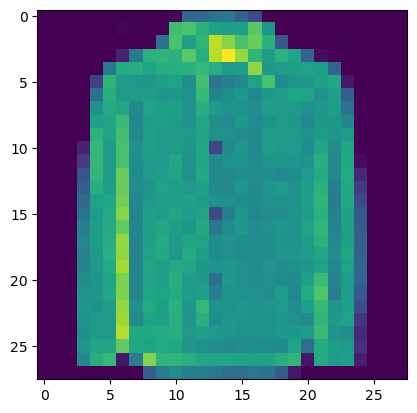

Predicted: Dress Actual: Bag


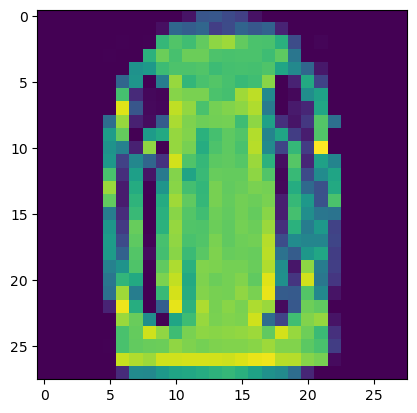

Predicted: Coat Actual: Shirt


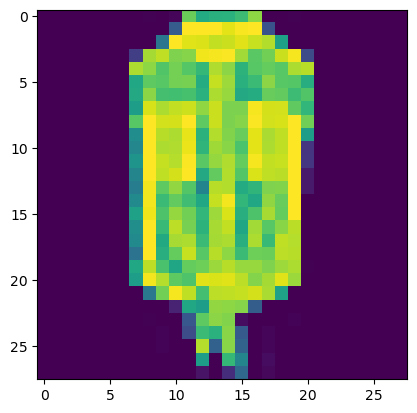

Predicted: Shirt Actual: T-shirt/top


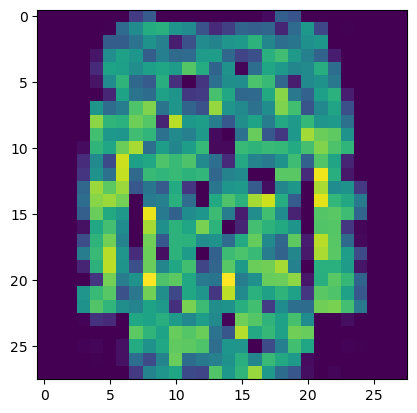

Predicted: Shirt Actual: Pullover


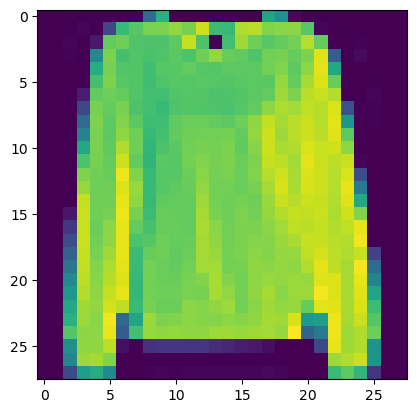

Predicted: Trouser Actual: Dress


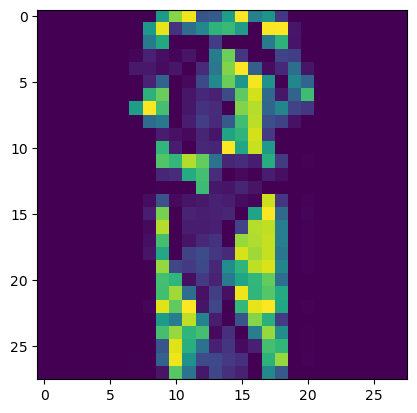

Predicted: Shirt Actual: Coat


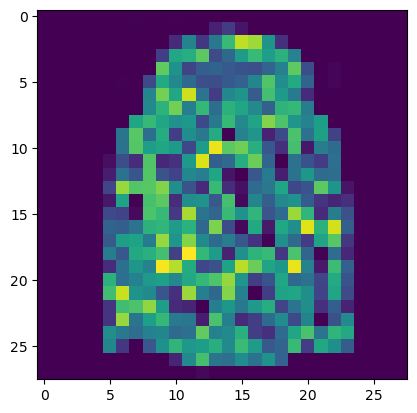

Predicted: Shirt Actual: T-shirt/top


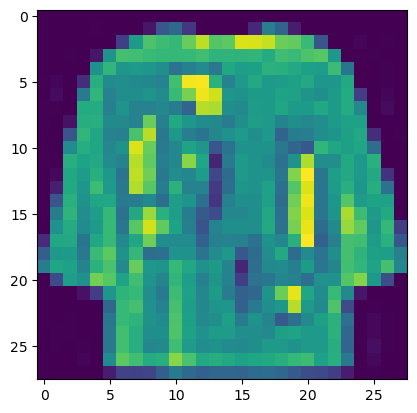

Predicted: Pullover Actual: Coat


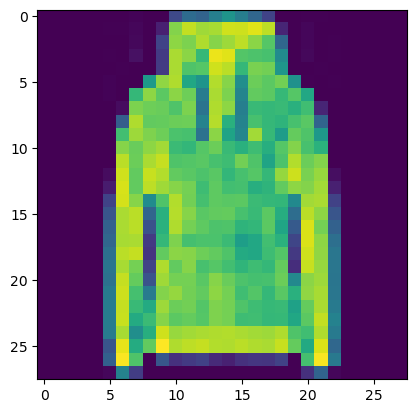

Predicted: Sneaker Actual: Ankle boot


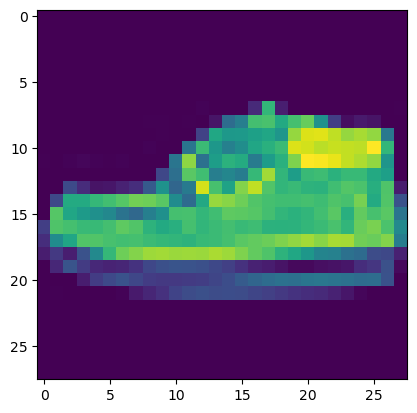

Predicted: Dress Actual: Shirt


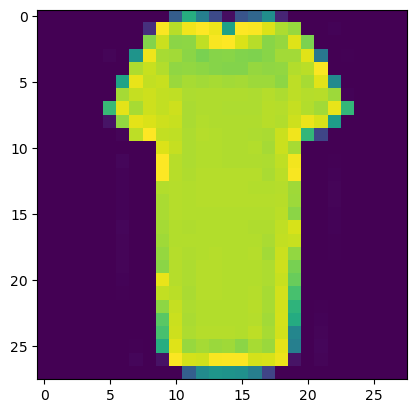

Predicted: T-shirt/top Actual: Shirt


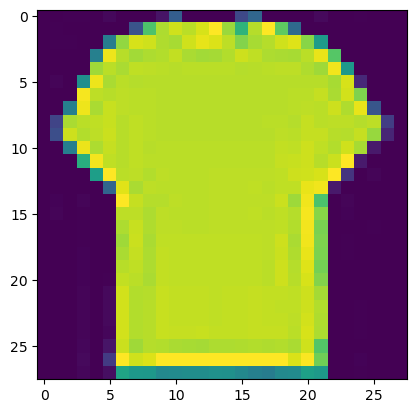

Predicted: Shirt Actual: T-shirt/top


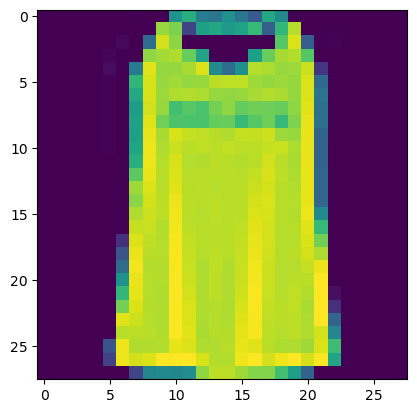

Predicted: Pullover Actual: Coat


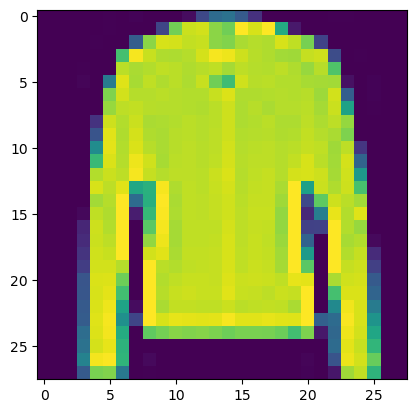

Predicted: Coat Actual: Bag


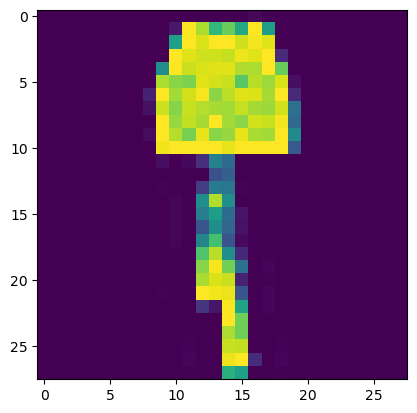

Predicted: Shirt Actual: T-shirt/top


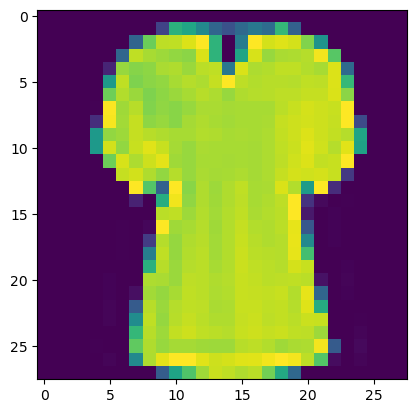

Predicted: Sneaker Actual: Ankle boot


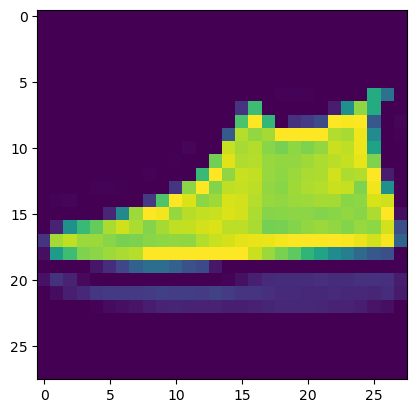

Predicted: T-shirt/top Actual: Shirt


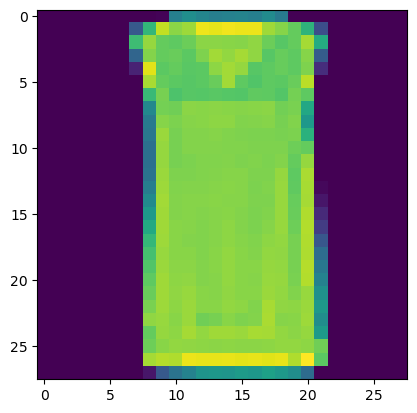

Predicted: T-shirt/top Actual: Shirt


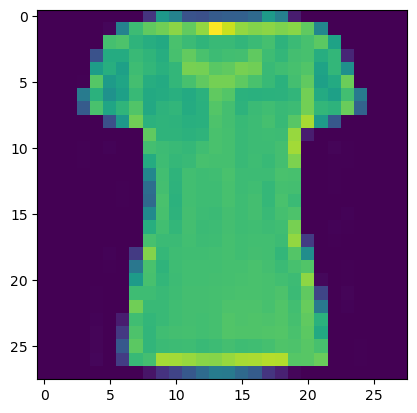

Predicted: Pullover Actual: Shirt


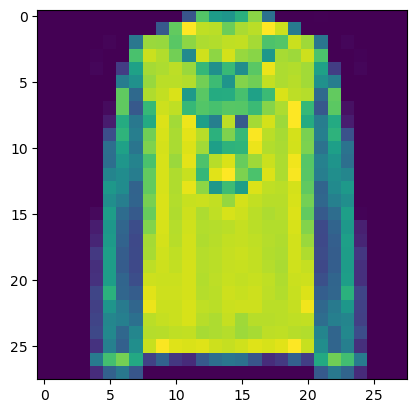

Predicted: Shirt Actual: T-shirt/top


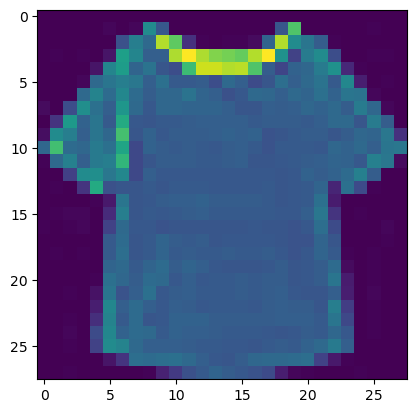

Predicted: Pullover Actual: Shirt


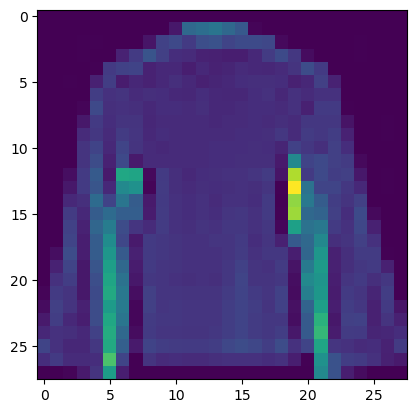

Predicted: Pullover Actual: Shirt


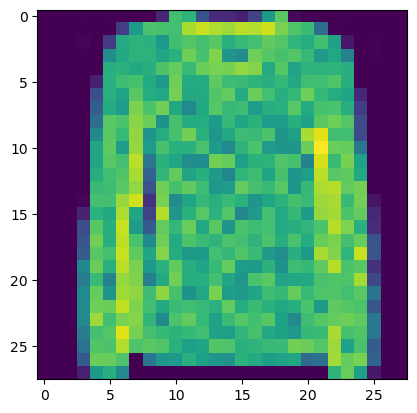

Predicted: Dress Actual: T-shirt/top


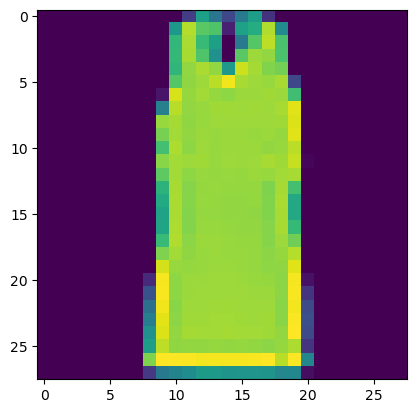

Predicted: Pullover Actual: Coat


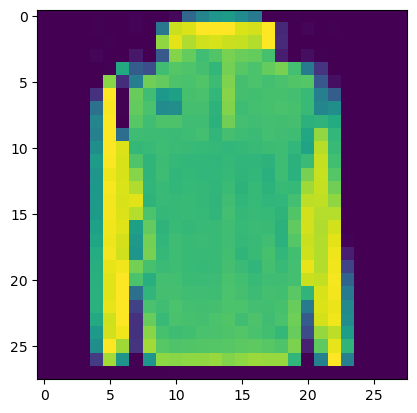

Predicted: Coat Actual: Dress


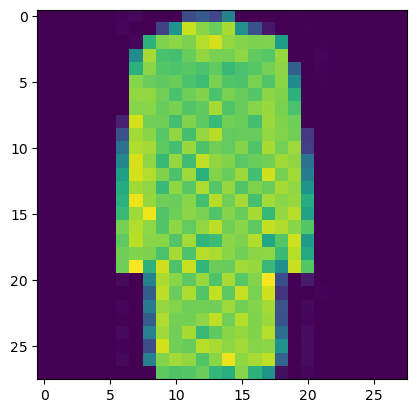

Predicted: Shirt Actual: Pullover


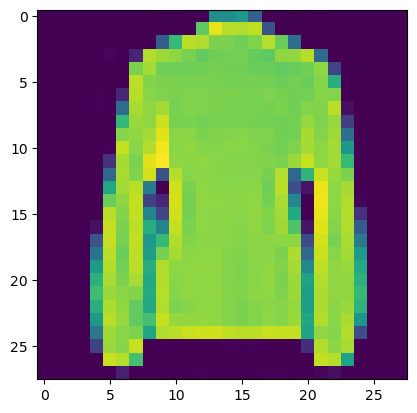

Predicted: Dress Actual: T-shirt/top


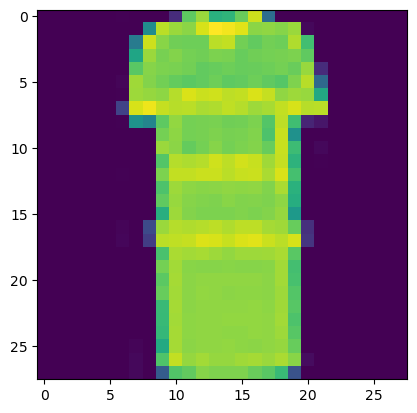

Predicted: Shirt Actual: Coat


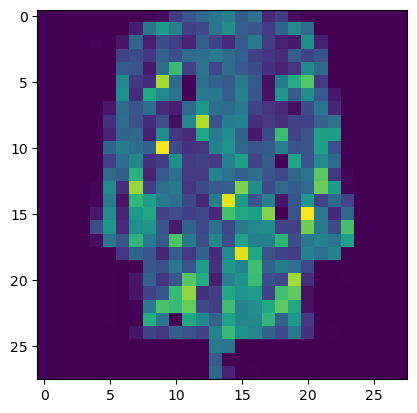

Predicted: Shirt Actual: Pullover


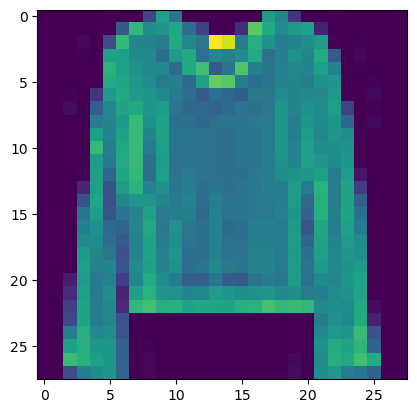

Predicted: Shirt Actual: T-shirt/top


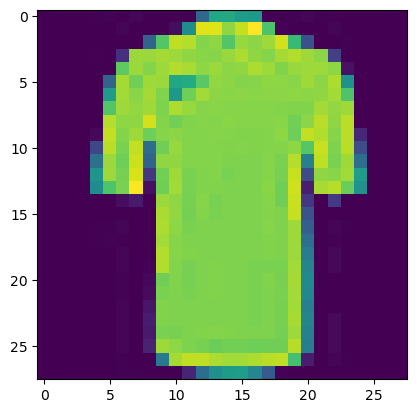

Predicted: Pullover Actual: Coat


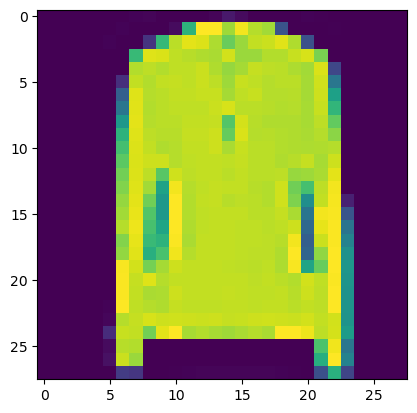

Predicted: T-shirt/top Actual: Shirt


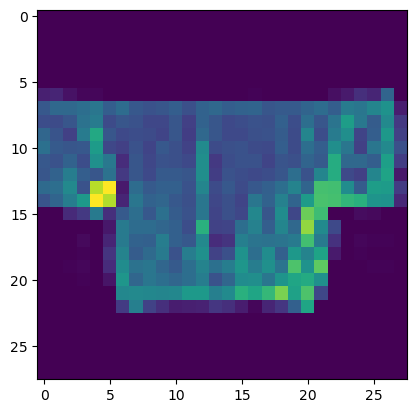

Predicted: Coat Actual: Dress


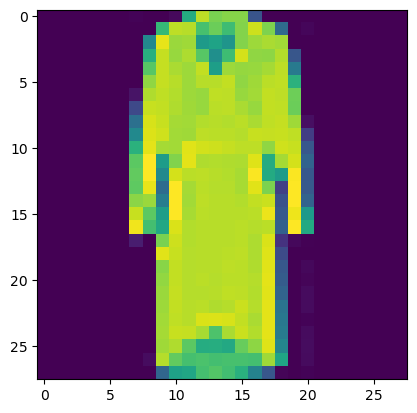

Predicted: Coat Actual: Pullover


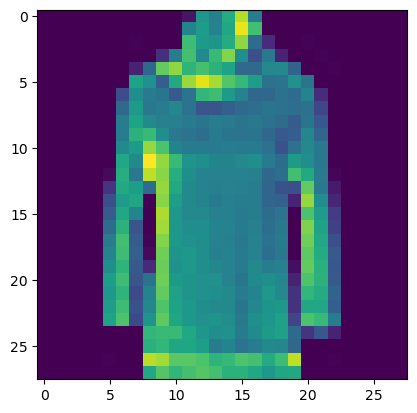

Predicted: Shirt Actual: T-shirt/top


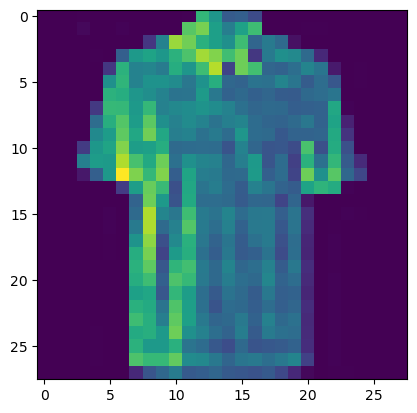

Predicted: Shirt Actual: Dress


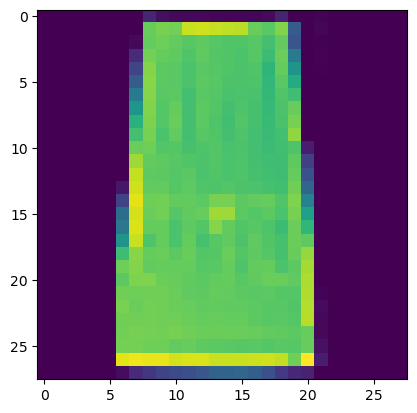

Predicted: Ankle boot Actual: Sandal


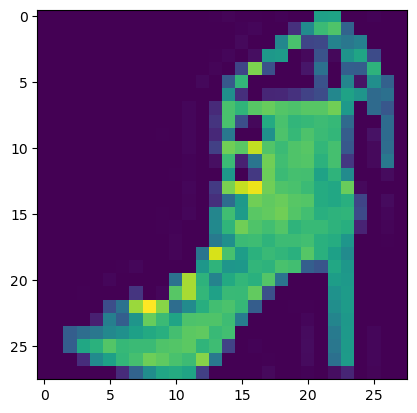

Predicted: Coat Actual: Pullover


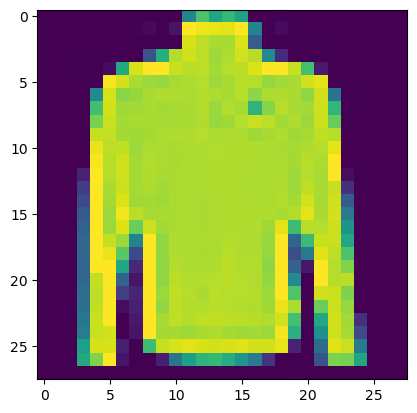

Predicted: Ankle boot Actual: Sandal


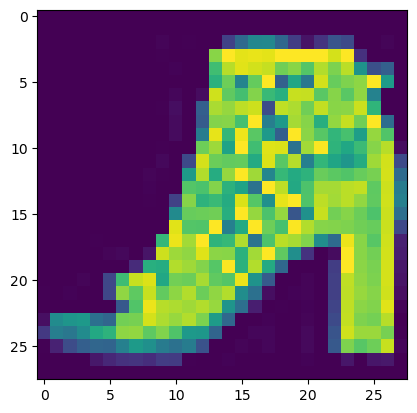

Predicted: Dress Actual: T-shirt/top


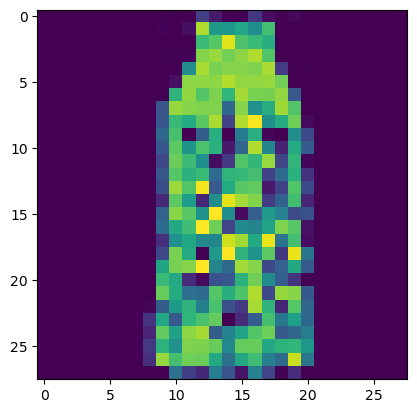

Predicted: Dress Actual: Shirt


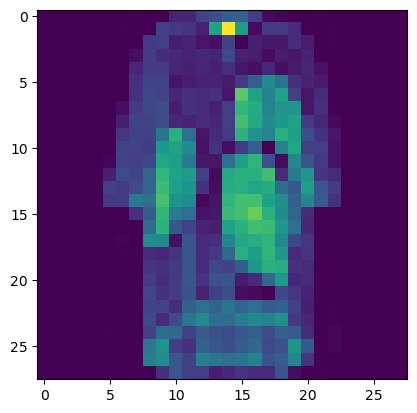

Predicted: Coat Actual: Bag


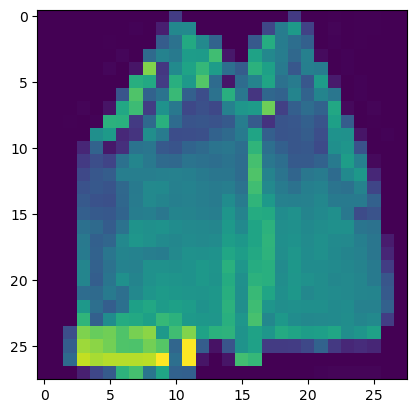

Predicted: T-shirt/top Actual: Shirt


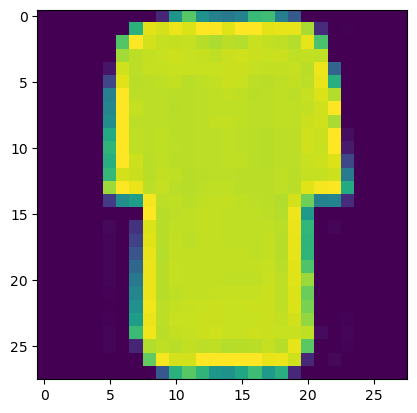

Predicted: Dress Actual: Shirt


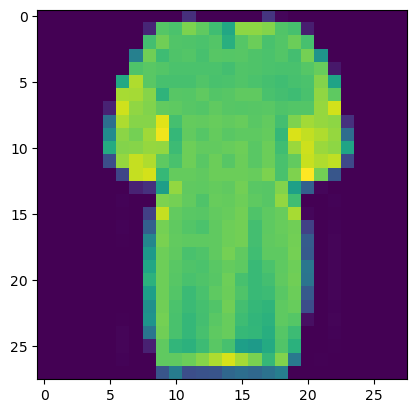

Predicted: Coat Actual: Shirt


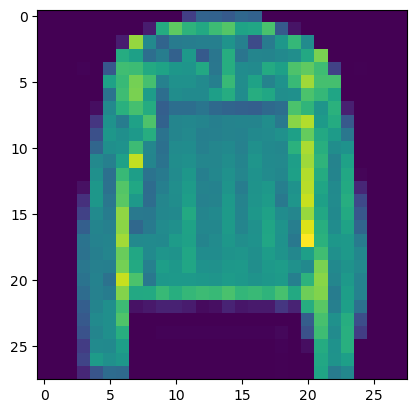

Predicted: Sneaker Actual: Bag


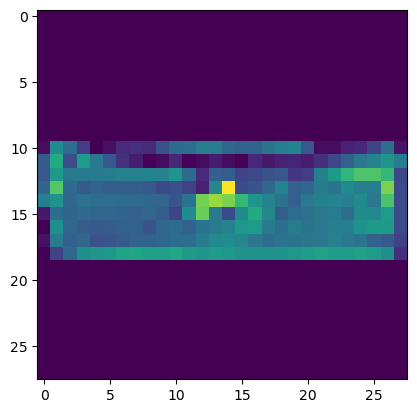

Predicted: Coat Actual: Shirt


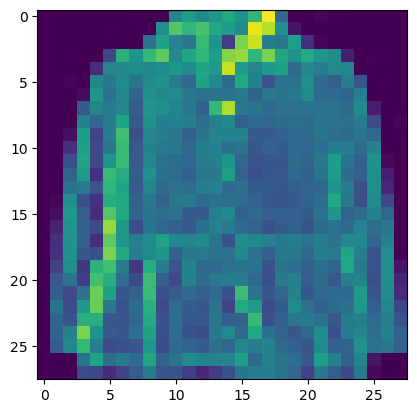

Predicted: Pullover Actual: Coat


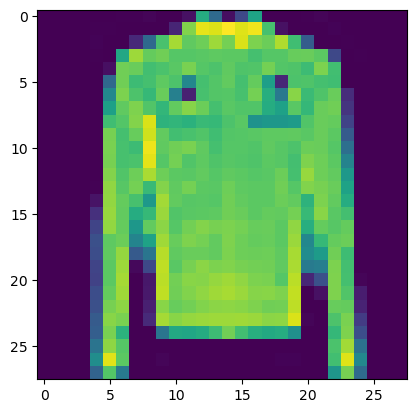

Predicted: Coat Actual: Shirt


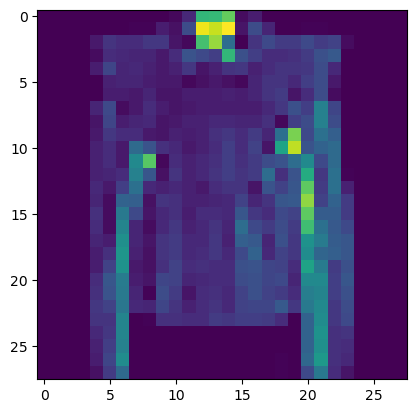

Predicted: Pullover Actual: Coat


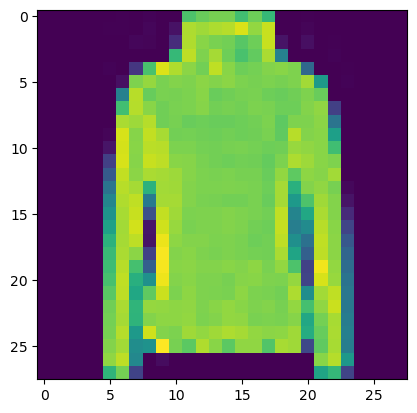

Predicted: Dress Actual: T-shirt/top


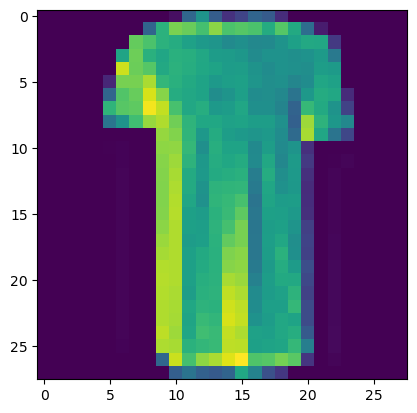

Predicted: T-shirt/top Actual: Shirt


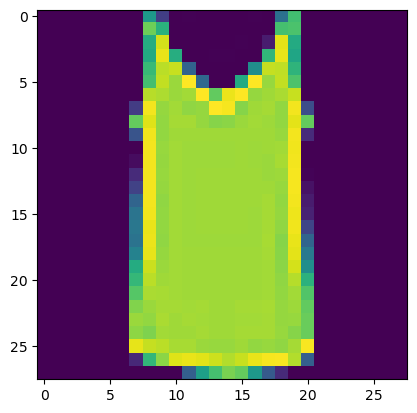

Predicted: Shirt Actual: Coat


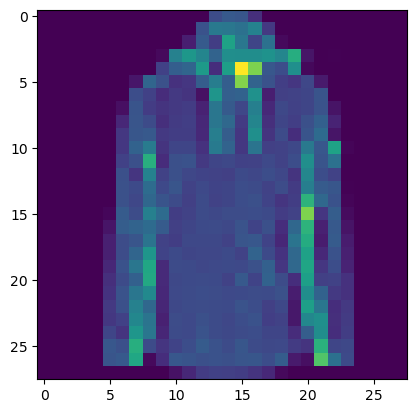

Predicted: Pullover Actual: Coat


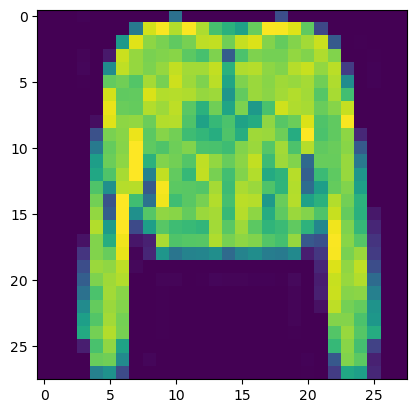

Predicted: Ankle boot Actual: Sneaker


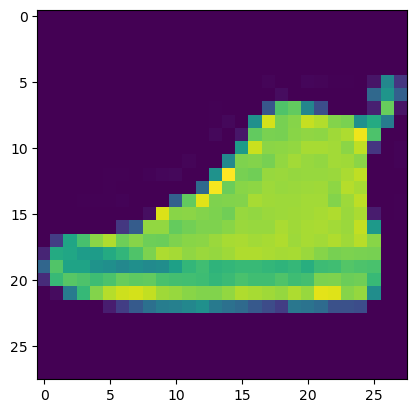

Predicted: T-shirt/top Actual: Shirt


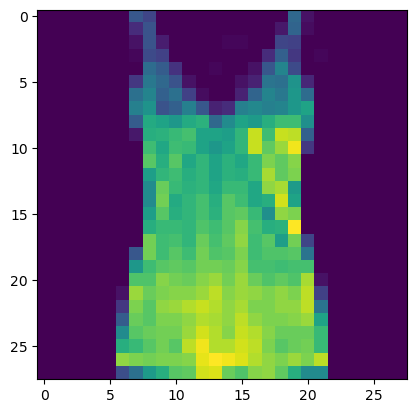

Predicted: T-shirt/top Actual: Shirt


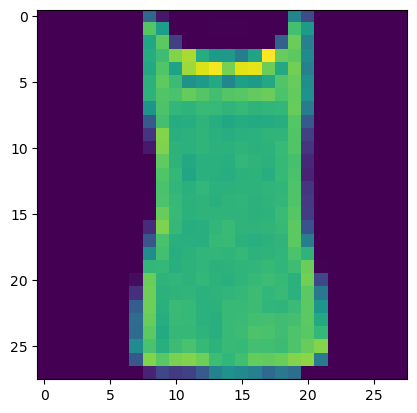

Predicted: T-shirt/top Actual: Shirt


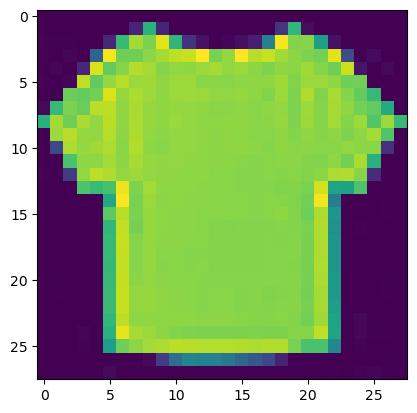

Predicted: T-shirt/top Actual: Shirt


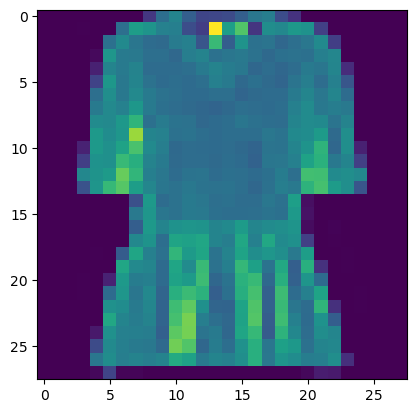

Predicted: T-shirt/top Actual: Dress


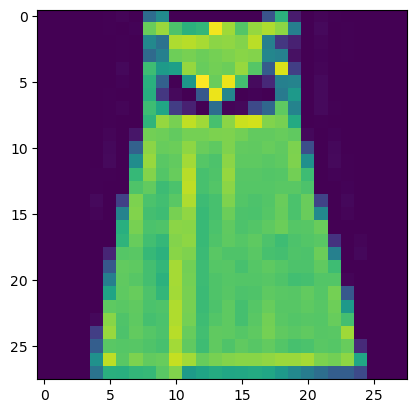

Predicted: Coat Actual: Dress


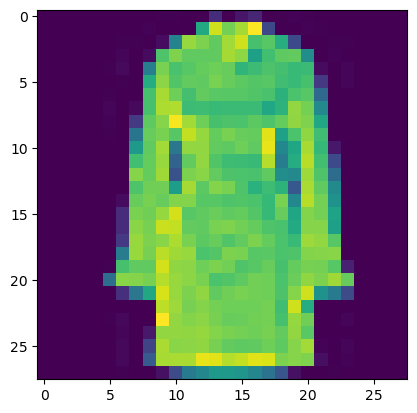

Predicted: Coat Actual: Shirt


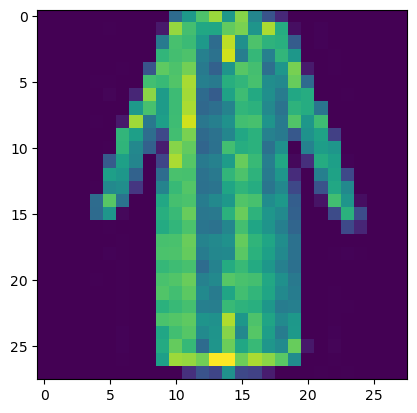

Predicted: Shirt Actual: Dress


In [ ]:
model_test(test_dataset_loader, model, loss_function)
#최종 평가 진행

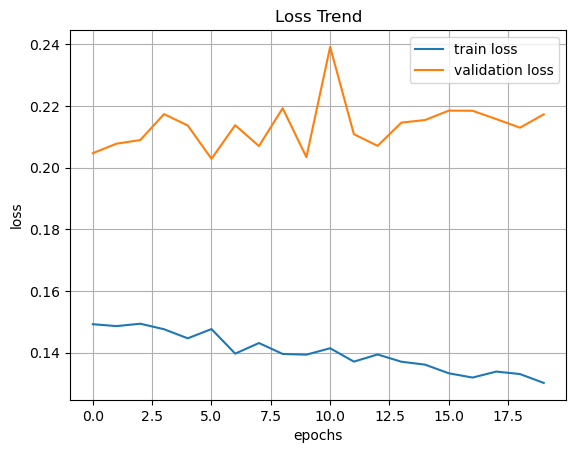

In [ ]:
#Epoch 반복함에 따른 Loss 변화율
plt.title('Loss Trend') #한글이 깨져서 영어로 작성
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

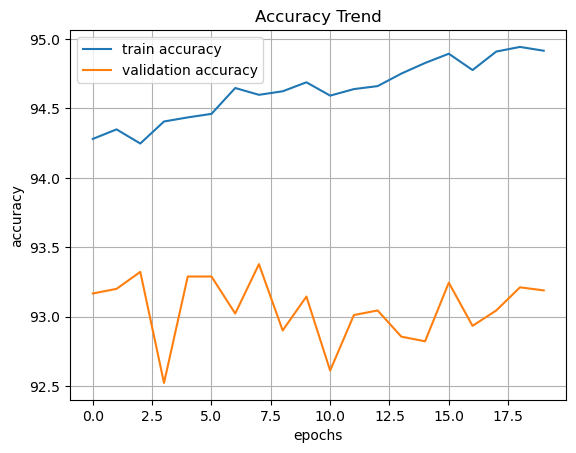

In [ ]:
#Epoch 반복함에 따른 Accuracy 변화율
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()